### Import Packages

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import pandas as pd

### Import Data Sets (includes data cleaning and seperating data into training and testing sets)

In [2]:
#income dataset (by default, is already split into test and train data)

#title headers for the dataset
income_header = ['age', 'workclass', 'fnlwgt','education', 'education-num', 'marital-status','occupation','relationship',\
                'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Above 50K']
income_train_df = pd.read_csv('adult.data', header=None, names=income_header)
income_test_df = pd.read_csv('adult.test', header=None, names=income_header,skiprows=[0]) #skip the first row 
income_df = pd.concat([income_train_df,income_test_df]) #combine training and testing data
income_df['Above 50K'] = income_df['Above 50K'].str.strip('.') #get rid of the '.' character in the results

income_norm_df = income_df.select_dtypes(include=['int64','float64'])  #select quantitative data


#normalize data
income_norm_df = (income_norm_df - income_norm_df.mean()) / (income_norm_df.max() - income_norm_df.min())

income_df = pd.concat([income_norm_df, income_df.select_dtypes(exclude=['int64','float64'])],1)
income_df = pd.get_dummies(income_df) #does one hot encoding

income_df = income_df.sample(frac=1) #shuffle the data


In [3]:
#poker dataset (by default, is already split into test and train data)
poker_header = ['Suit of card #1', 'Rank of card #1', 'Suit of card #2', 'Rank of card #2', 'Suit of card #3',\
                'Rank of card #3', 'Suit of card #4', 'Rank of card #4', 'Suit of card #5', 'Rank of card #5','Poker Hand']
poker_test_df = pd.read_csv('poker-hand-testing.data', header=None, names=poker_header)
poker_train_df = pd.read_csv('poker-hand-training-true.data', header=None, names=poker_header)
poker_df= pd.concat([poker_train_df,poker_test_df]) #we can reduce the data size

poker_labels = pd.DataFrame(data=poker_df.iloc[:,-1].values.reshape(len(poker_df),1), columns=['Poker Hand'])


poker_scaler = StandardScaler()
poker_scaler.fit(poker_df.iloc[:,:-1]) #fit scalar to predictors
poker_df = poker_scaler.transform(poker_df.iloc[:,:-1]) #apply scalar to pedictors


poker_df = pd.DataFrame(data=poker_df, columns=np.array(poker_header[:-1]))

poker_df = pd.concat([poker_df, poker_labels],1)
poker_df = poker_df.sample(frac=1) #shuffle the data
# poker_df.iloc[:,0:-1] = (poker_df.iloc[:,0:-1] - poker_df.iloc[:,0:-1].mean()) / (poker_df.iloc[:,0:-1].max()\
#                         - poker_df.iloc[:,0:-1].min())

In [4]:
#wine quality data set 
wine_header = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',\
               'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
wine_df_red = pd.read_csv('winequality-red.csv', header=None, names=wine_header, skiprows=[0],sep=';')
wine_df_white = pd.read_csv('winequality-white.csv', header=None, names=wine_header, skiprows=[0],sep=';')
wine_df = pd.concat([wine_df_red, wine_df_white])

wine_quality = wine_df['quality'] #store the quality row since we don't want to normalize that row
wine_df = (wine_df - wine_df.mean()) / (wine_df.max() - wine_df.min())
wine_df = wine_df.drop(['quality'],axis=1)
wine_df = pd.concat([wine_df,wine_quality],1)
income_df = income_df.sample(frac=1) #shuffle the data

### Partition data into train and test (20/80,50/50,80/20)

In [5]:
#15000 data points is enough (to assist with computation time)
X_Income = income_df.iloc[:15000, 0:-2]         # First column to third last column (>50k and <=50k are 2 seperate columns)
Y_Income = income_df.iloc[:15000, -1]           # Last column: Labels (0 or 1)
X_Poker_1_Cards = poker_df.iloc[:15000, 0:-9]           # Predict with knowledge of 1 card
X_Poker_2_Cards = poker_df.iloc[:15000, 0:-7]           # Predict with knowledge of 2 cards
X_Poker_3_Cards = poker_df.iloc[:15000, 0:-5]           # Predict with knowledge of 3 cards
X_Poker_4_Cards = poker_df.iloc[:15000, 0:-3]           # Predict with knowledge of 4 cards
X_Poker_5_Cards = poker_df.iloc[:15000, 0:-1]           # Predict with knowledge of 5 cards
Y_Poker = poker_df.iloc[:15000, -1] 

#get all the data
# X_Poker_1_Cards = poker_df.iloc[:, 0:-9]           # Predict with knowledge of 1 card
# X_Poker_2_Cards = poker_df.iloc[:, 0:-7]           # Predict with knowledge of 2 cards
# X_Poker_3_Cards = poker_df.iloc[:, 0:-5]           # Predict with knowledge of 3 cards
# X_Poker_4_Cards = poker_df.iloc[:, 0:-3]           # Predict with knowledge of 4 cards
# X_Poker_5_Cards = poker_df.iloc[:, 0:-1]           # Predict with knowledge of 5 cards
# Y_Poker = poker_df.iloc[:, -1] 

X_Wine = wine_df.iloc[:, 0:-1]  
Y_Wine = wine_df.iloc[:, -1] 

In [6]:
Y_Poker.value_counts()

0    7498
1    6362
2     718
3     327
4      45
5      28
6      19
7       3
Name: Poker Hand, dtype: int64

In [7]:
Y_Wine.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [8]:
#edit the labels to consist of -1 and 1
Y_Income = Y_Income.apply(lambda i: -1 if i <1 else 1)
Y_Poker = Y_Poker.apply(lambda i: -1 if i <1 else 1)
Y_Wine = Y_Wine.apply(lambda i: -1 if i <6 else 1)

In [9]:
Y_Poker.value_counts()

 1    7502
-1    7498
Name: Poker Hand, dtype: int64

In [10]:
Y_Wine.value_counts()

 1    4113
-1    2384
Name: quality, dtype: int64

#### Partition 1

In [11]:
X_train_val_Income_1 = X_Income[:int(0.8*len(X_Income))] # Get features from train + val set.
X_test_Income_1      = X_Income[int(0.8*len(X_Income)):] # Get features from test set.     
Y_train_val_Income_1 = Y_Income[:int(0.8*len(Y_Income))] # Get labels from train + val set.
Y_test_Income_1      = Y_Income[int(0.8*len(Y_Income)):] # Get labels from test set.

X_train_val_Poker_1_Cards_1 = X_Poker_1_Cards[:int(0.8*len(X_Poker_1_Cards))] #split 1 with 1 Card
X_test_Poker_1_Cards_1      = X_Poker_1_Cards[int(0.8*len(X_Poker_1_Cards)):] 
Y_train_val_Poker_1 = Y_Poker[:int(0.8*len(Y_Poker))] 
Y_test_Poker_1      = Y_Poker[int(0.8*len(Y_Poker)):] 

X_train_val_Poker_1_Cards_2 = X_Poker_2_Cards[:int(0.8*len(X_Poker_2_Cards))] #split 1 with 2 Cards
X_test_Poker_1_Cards_2      = X_Poker_2_Cards[int(0.8*len(X_Poker_2_Cards)):] 

X_train_val_Poker_1_Cards_3 = X_Poker_3_Cards[:int(0.8*len(X_Poker_3_Cards))] #split 1 with 3 Cards
X_test_Poker_1_Cards_3      = X_Poker_3_Cards[int(0.8*len(X_Poker_3_Cards)):] 

X_train_val_Poker_1_Cards_4 = X_Poker_4_Cards[:int(0.8*len(X_Poker_4_Cards))] #split 1 with 4 Cards
X_test_Poker_1_Cards_4      = X_Poker_4_Cards[int(0.8*len(X_Poker_4_Cards)):] 

X_train_val_Poker_1_Cards_5 = X_Poker_5_Cards[:int(0.8*len(X_Poker_5_Cards))] #split 1 with 5 Cards
X_test_Poker_1_Cards_5      = X_Poker_5_Cards[int(0.8*len(X_Poker_5_Cards)):] 


X_train_val_Wine_1 = X_Wine[:int(0.8*len(X_Wine))] 
X_test_Wine_1      = X_Wine[int(0.8*len(X_Wine)):] 
Y_train_val_Wine_1 = Y_Wine[:int(0.8*len(Y_Wine))] 
Y_test_Wine_1      = Y_Wine[int(0.8*len(Y_Wine)):] 


print('Income: ',X_train_val_Income_1.shape, X_test_Income_1.shape, Y_train_val_Income_1.shape, Y_test_Income_1.shape)
print('Poker: ', X_train_val_Poker_1_Cards_1.shape, X_test_Poker_1_Cards_1.shape, Y_train_val_Poker_1.shape,\
      Y_test_Poker_1.shape)
print('Wine: ', X_train_val_Wine_1.shape, X_test_Wine_1.shape, Y_train_val_Wine_1.shape, Y_test_Wine_1.shape)

Income:  (12000, 108) (3000, 108) (12000,) (3000,)
Poker:  (12000, 2) (3000, 2) (12000,) (3000,)
Wine:  (5197, 11) (1300, 11) (5197,) (1300,)


#### Partition 2

In [12]:
X_train_val_Income_2 = X_Income[:int(0.5*len(X_Income))] 
X_test_Income_2      = X_Income[int(0.5*len(X_Income)):]   
Y_train_val_Income_2 = Y_Income[:int(0.5*len(Y_Income))] 
Y_test_Income_2      = Y_Income[int(0.5*len(Y_Income)):] 

X_train_val_Poker_2_Cards_1 = X_Poker_1_Cards[:int(0.5*len(X_Poker_1_Cards))] #split 2 with 1 Card
X_test_Poker_2_Cards_1      = X_Poker_1_Cards[int(0.5*len(X_Poker_1_Cards)):] 
Y_train_val_Poker_2 = Y_Poker[:int(0.5*len(Y_Poker))] 
Y_test_Poker_2      = Y_Poker[int(0.5*len(Y_Poker)):] 

X_train_val_Poker_2_Cards_2 = X_Poker_2_Cards[:int(0.5*len(X_Poker_2_Cards))] #split 2 with 2 Cards
X_test_Poker_2_Cards_2      = X_Poker_2_Cards[int(0.5*len(X_Poker_2_Cards)):] 

X_train_val_Poker_2_Cards_3 = X_Poker_3_Cards[:int(0.5*len(X_Poker_3_Cards))] #split 2 with 3 Cards
X_test_Poker_2_Cards_3      = X_Poker_3_Cards[int(0.5*len(X_Poker_3_Cards)):] 

X_train_val_Poker_2_Cards_4 = X_Poker_4_Cards[:int(0.5*len(X_Poker_4_Cards))] #split 2 with 4 Cards
X_test_Poker_2_Cards_4      = X_Poker_4_Cards[int(0.5*len(X_Poker_4_Cards)):] 

X_train_val_Poker_2_Cards_5 = X_Poker_5_Cards[:int(0.5*len(X_Poker_5_Cards))] #split 2 with 5 Cards
X_test_Poker_2_Cards_5      = X_Poker_5_Cards[int(0.5*len(X_Poker_5_Cards)):] 


X_train_val_Wine_2 = X_Wine[:int(0.5*len(X_Wine))] 
X_test_Wine_2      = X_Wine[int(0.5*len(X_Wine)):] 
Y_train_val_Wine_2 = Y_Wine[:int(0.5*len(Y_Wine))] 
Y_test_Wine_2      = Y_Wine[int(0.5*len(Y_Wine)):] 


print('Income: ',X_train_val_Income_2.shape, X_test_Income_2.shape, Y_train_val_Income_2.shape, Y_test_Income_2.shape)
print('Poker: ', X_train_val_Poker_2_Cards_2.shape, X_test_Poker_2_Cards_2.shape, Y_train_val_Poker_2.shape,\
      Y_test_Poker_2.shape)
print('Wine: ', X_train_val_Wine_2.shape, X_test_Wine_2.shape, Y_train_val_Wine_2.shape, Y_test_Wine_2.shape)

Income:  (7500, 108) (7500, 108) (7500,) (7500,)
Poker:  (7500, 4) (7500, 4) (7500,) (7500,)
Wine:  (3248, 11) (3249, 11) (3248,) (3249,)


#### Partition 3

In [13]:
X_train_val_Income_3 = X_Income[:int(0.2*len(X_Income))] 
X_test_Income_3      = X_Income[int(0.2*len(X_Income)):]   
Y_train_val_Income_3 = Y_Income[:int(0.2*len(Y_Income))] 
Y_test_Income_3      = Y_Income[int(0.2*len(Y_Income)):] 

X_train_val_Poker_3_Cards_1 = X_Poker_1_Cards[:int(0.2*len(X_Poker_1_Cards))] #split 2 with 1 Card
X_test_Poker_3_Cards_1      = X_Poker_1_Cards[int(0.2*len(X_Poker_1_Cards)):] 
Y_train_val_Poker_3 = Y_Poker[:int(0.2*len(Y_Poker))] 
Y_test_Poker_3      = Y_Poker[int(0.2*len(Y_Poker)):] 

X_train_val_Poker_3_Cards_2 = X_Poker_2_Cards[:int(0.2*len(X_Poker_2_Cards))] #split 3 with 2 Cards
X_test_Poker_3_Cards_2      = X_Poker_2_Cards[int(0.2*len(X_Poker_2_Cards)):] 

X_train_val_Poker_3_Cards_3 = X_Poker_3_Cards[:int(0.2*len(X_Poker_3_Cards))] #split 3 with 3 Cards
X_test_Poker_3_Cards_3      = X_Poker_3_Cards[int(0.2*len(X_Poker_3_Cards)):] 

X_train_val_Poker_3_Cards_4 = X_Poker_4_Cards[:int(0.2*len(X_Poker_4_Cards))] #split 3 with 4 Cards
X_test_Poker_3_Cards_4      = X_Poker_4_Cards[int(0.2*len(X_Poker_4_Cards)):] 

X_train_val_Poker_3_Cards_5 = X_Poker_5_Cards[:int(0.2*len(X_Poker_5_Cards))] #split 3 with 5 Cards
X_test_Poker_3_Cards_5      = X_Poker_5_Cards[int(0.2*len(X_Poker_5_Cards)):] 


X_train_val_Wine_3 = X_Wine[:int(0.2*len(X_Wine))] 
X_test_Wine_3      = X_Wine[int(0.2*len(X_Wine)):] 
Y_train_val_Wine_3 = Y_Wine[:int(0.2*len(Y_Wine))] 
Y_test_Wine_3      = Y_Wine[int(0.2*len(Y_Wine)):] 


print('Income: ',X_train_val_Income_3.shape, X_test_Income_3.shape, Y_train_val_Income_3.shape, Y_test_Income_3.shape)
print('Poker: ', X_train_val_Poker_3_Cards_3.shape, X_test_Poker_3_Cards_3.shape, Y_train_val_Poker_3.shape,\
      Y_test_Poker_3.shape)
print('Wine: ', X_train_val_Wine_3.shape, X_test_Wine_3.shape, Y_train_val_Wine_3.shape, Y_test_Wine_3.shape)

Income:  (3000, 108) (12000, 108) (3000,) (12000,)
Poker:  (3000, 6) (12000, 6) (3000,) (12000,)
Wine:  (1299, 11) (5198, 11) (1299,) (5198,)


In [14]:
def draw_heatmap_logistic(acc, acc_desc, c_list, split):
    plt.figure(figsize = (9,5))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=c_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'test/train splits', ylabel='$C$')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
def draw_heatmap_logistic_test(acc, acc_desc, split):
    plt.figure(figsize = (9,2))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels='')
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'test/train splits', ylabel='accuracy')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    

In [15]:
def draw_heatmap_SVM(acc, acc_desc, c_list, split):
    plt.figure(figsize = (9,5))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=c_list, cmap = "PRGn")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'test/train splits', ylabel='$C$')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
def draw_heatmap_SVM_test(acc, acc_desc, split):
    plt.figure(figsize = (9,2))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels='', cmap = "PRGn")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'test/train splits', ylabel='accuracy')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    

In [16]:
def draw_heatmap_KNN(acc, acc_desc, k_list, split):
    plt.figure(figsize = (9,5))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=k_list,cmap="YlGnBu")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'test/train splits', ylabel='$K$')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
def draw_heatmap_KNN_test(acc, acc_desc, split):
    plt.figure(figsize = (9,2))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels='',cmap="YlGnBu")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'test/train splits', ylabel='accuracy')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    

In [17]:
def draw_heatmap_MLP(acc, acc_desc, activation_list, split):
    plt.figure(figsize = (9,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=activation_list, cmap="RdYlGn")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'test/train splits', ylabel='$activation$')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
def draw_heatmap_MLP_test(acc, acc_desc, split):
    plt.figure(figsize = (9,2))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels='',cmap="RdYlGn")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'test/train splits', ylabel='accuracy')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    

In [18]:
def draw_heatmap_tree(acc, acc_desc, depth_list, split):
    plt.figure(figsize = (9,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=depth_list, cmap="Spectral")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'test/train splits', ylabel='$max depth$')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
def draw_heatmap_tree_test(acc, acc_desc, split):
    plt.figure(figsize = (9,2))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels='',cmap="Spectral")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'test/train splits', ylabel='accuracy')
    plt.title(acc_desc)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

### Classifier 1: Logistic Regression

In [19]:
#logisitic regression with cross validation of 3
def logisticReg(X_train_pred_1, Y_train_val_1, X_train_pred_2, Y_train_val_2, X_train_pred_3, Y_train_val_3,\
               X_test_1, Y_test_1, X_test_2, Y_test_2, X_test_3, Y_test_3, title1, title2, title3):
    # Initialize model.
    logReg = LogisticRegression(solver='liblinear', multi_class='ovr')
    
    c_list = (0.001, 0.01, 0.1, 1, 10)
    test_train_split = ['80% Test 20% Train', '50% Test 50% Train', '20% Test 80% Train']
    
    grid_search_1 = GridSearchCV(logReg, {'C': c_list},  cv = 3, return_train_score= True, iid = True)
    grid_search_1.fit(X_train_pred_1, Y_train_val_1)
    
    grid_search_2 = GridSearchCV(logReg, {'C': c_list},  cv = 3, return_train_score= True, iid = True)
    grid_search_2.fit(X_train_pred_2, Y_train_val_2)
    
    grid_search_3 = GridSearchCV(logReg, {'C': c_list},  cv = 3, return_train_score= True, iid = True)
    grid_search_3.fit(X_train_pred_3, Y_train_val_3)

    
    #training accuracy
    train_acc_1 = grid_search_1.cv_results_['mean_train_score']
    train_acc_2 = grid_search_2.cv_results_['mean_train_score']
    train_acc_3 = grid_search_3.cv_results_['mean_train_score']
    
    #print(train_acc_1)
    train_acc = np.array([[train_acc_1],[train_acc_2], [train_acc_3]]).T
    train_acc = train_acc.reshape(5,3)
    #print(train_acc)
    draw_heatmap_logistic(train_acc, title1, c_list, test_train_split)

    
    #validation accuracy
    logReg = LogisticRegression(solver='liblinear', multi_class='ovr')
    
    val_acc_1 = grid_search_1.cv_results_['mean_test_score'].reshape(5,1)
    val_acc_2 = grid_search_2.cv_results_['mean_test_score'].reshape(5,1)
    val_acc_3 = grid_search_3.cv_results_['mean_test_score'].reshape(5,1)
#     print(val_acc_1, val_acc_2, val_acc_3)
    val_acc = np.array([[val_acc_1], [val_acc_2], [val_acc_3]]).T
    val_acc = val_acc.reshape(5,3)
    #print(train_acc)
    draw_heatmap_logistic(val_acc, title2, c_list, test_train_split)
    
    
    #test accuracy
    counter = 0
 
    pred_1 = grid_search_1.predict(X_test_1) #predict automatically tests on the best parameters
    for i in range(len(pred_1)):
        if pred_1[i] != Y_test_1.iloc[i]:
            counter += 1
    test_acc_1 = 1-(counter / len(pred_1))
    
    counter = 0
    pred_2 = grid_search_2.predict(X_test_2)
    for i in range(len(pred_2)):
        if pred_2[i] != Y_test_2.iloc[i]:
            counter += 1
    test_acc_2 = 1-(counter / len(pred_2))
    
    counter = 0
    pred_3 = grid_search_3.predict(X_test_3)
    for i in range(len(pred_3)):
        if pred_3[i] != Y_test_3.iloc[i]:
            counter += 1
    test_acc_3 = 1-(counter / len(pred_3))
    
    test_acc = np.array([[test_acc_1], [test_acc_2], [test_acc_3]]).reshape(1,3)
    draw_heatmap_logistic_test(test_acc, title3, test_train_split)
    
    logDict = {}
    logDict['80/20 Split Train'] = np.mean(train_acc_1)
    logDict['50/50 Split Train'] = np.mean(train_acc_2)
    logDict['20/80 Split Train'] = np.mean(train_acc_3)
    logDict['80/20 Split Validation'] = np.mean(val_acc_1)
    logDict['50/50 Split Validation'] = np.mean(val_acc_2)
    logDict['20/80 Split Validation'] = np.mean(val_acc_3)
    logDict['80/20 Split Test'] = test_acc_1
    logDict['50/50 Split Test'] = test_acc_2
    logDict['20/80 Split Test'] = test_acc_3
    return logDict

#### Logistic Regression Parameter Values

In [20]:
logReg_Income_Average_Test = 0
logReg_Income_SD_Test = 0
logReg_Income_Max_Test = 0
logReg_Income_Min_Test = 0

logReg_Poker_1_Average_Test = 0
logReg_Poker_1_SD_Test = 0
logReg_Poker_1_Max_Test = 0
logReg_Poker_1_Min_Test = 0

logReg_Poker_2_Average_Test = 0
logReg_Poker_2_SD_Test = 0
logReg_Poker_2_Max_Test = 0
logReg_Poker_2_Min_Test = 0

logReg_Poker_3_Average_Test = 0
logReg_Poker_3_SD_Test = 0
logReg_Poker_3_Max_Test = 0
logReg_Poker_3_Min_Test = 0

logReg_Poker_5_Average_Test = 0
logReg_Poker_5_SD_Test = 0
logReg_Poker_5_Max_Test = 0
logReg_Poker_5_Min_Test = 0

logReg_Poker_Overall_Average_Test = 0
logReg_Poker_Overall_SD_Test = 0
logReg_Poker_Overall_Max_Test = 0
logReg_Poker_Overall_Min_Test = 0

logReg_Wine_Average_Test = 0
logReg_Wine_SD_Test = 0
logReg_Wine_Max_Test = 0
logReg_Wine_Min_Test = 0

logReg_overall_avg = []
logReg_80_20_split_avg = []
logReg_50_50_split_avg = []
logReg_20_80_split_avg = []

#### Logistic Regression Calculations

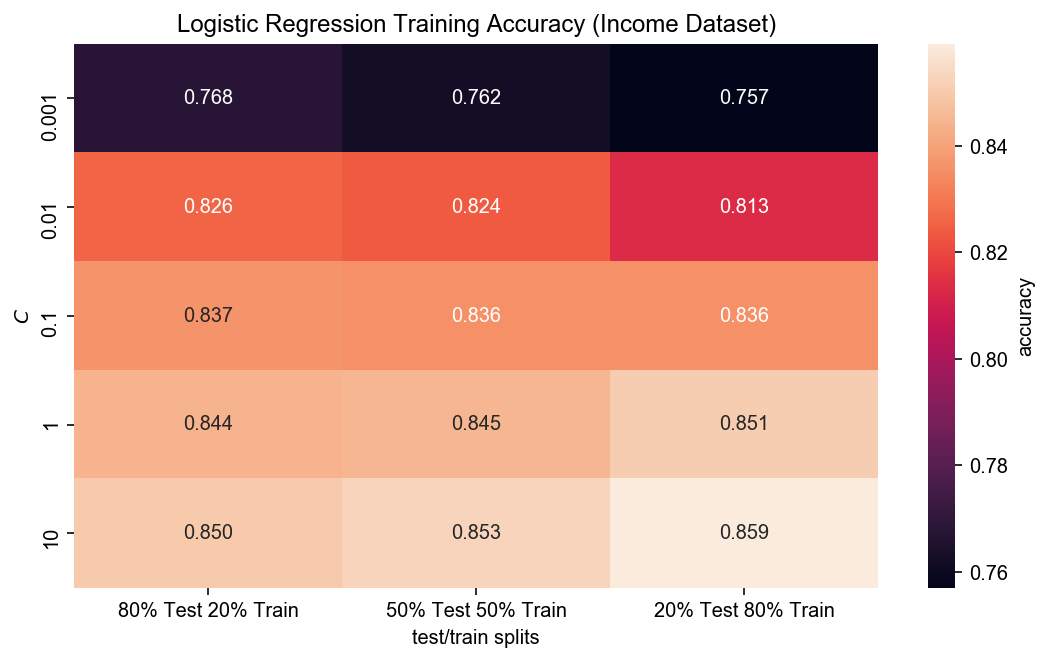

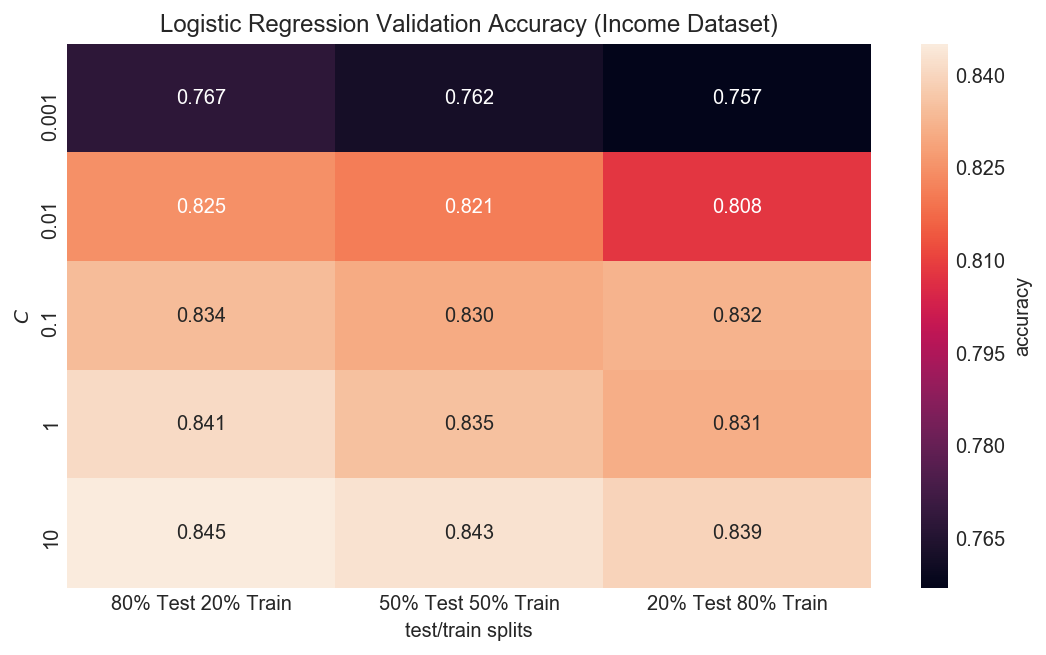

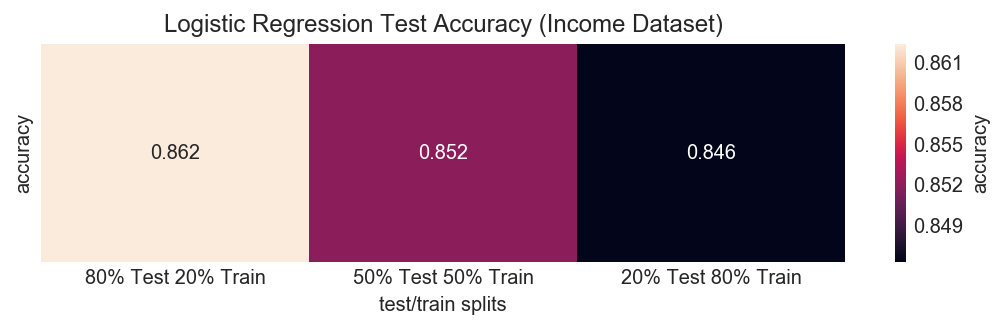

In [21]:
logReg_Income = logisticReg(X_train_val_Income_1, Y_train_val_Income_1,X_train_val_Income_2, Y_train_val_Income_2,\
                         X_train_val_Income_3, Y_train_val_Income_3, X_test_Income_1, Y_test_Income_1,\
                         X_test_Income_2, Y_test_Income_2, X_test_Income_3, Y_test_Income_3,\
                         'Logistic Regression Training Accuracy (Income Dataset)', \
                         'Logistic Regression Validation Accuracy (Income Dataset)',\
                         'Logistic Regression Test Accuracy (Income Dataset)')

In [22]:
logReg_overall_avg.append(np.mean(list(logReg_Income.values())))

temp = [] #hold split values
temp.append(logReg_Income['80/20 Split Train'])
temp.append(logReg_Income['80/20 Split Validation'])
temp.append(logReg_Income['80/20 Split Test'])
logReg_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Income['50/50 Split Train'])
temp.append(logReg_Income['50/50 Split Validation'])
temp.append(logReg_Income['50/50 Split Test'])
logReg_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Income['20/80 Split Train'])
temp.append(logReg_Income['20/80 Split Validation'])
temp.append(logReg_Income['20/80 Split Test'])
logReg_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(logReg_Income['80/20 Split Test'])
temp.append(logReg_Income['50/50 Split Test'])
temp.append(logReg_Income['20/80 Split Test'])

logReg_Income_Average_Test = np.mean(np.array(temp))
logReg_Income_SD_Test = np.std(np.array(temp))
logReg_Income_Max_Test = np.max(np.array(temp))
logReg_Income_Min_Test = np.min(np.array(temp))

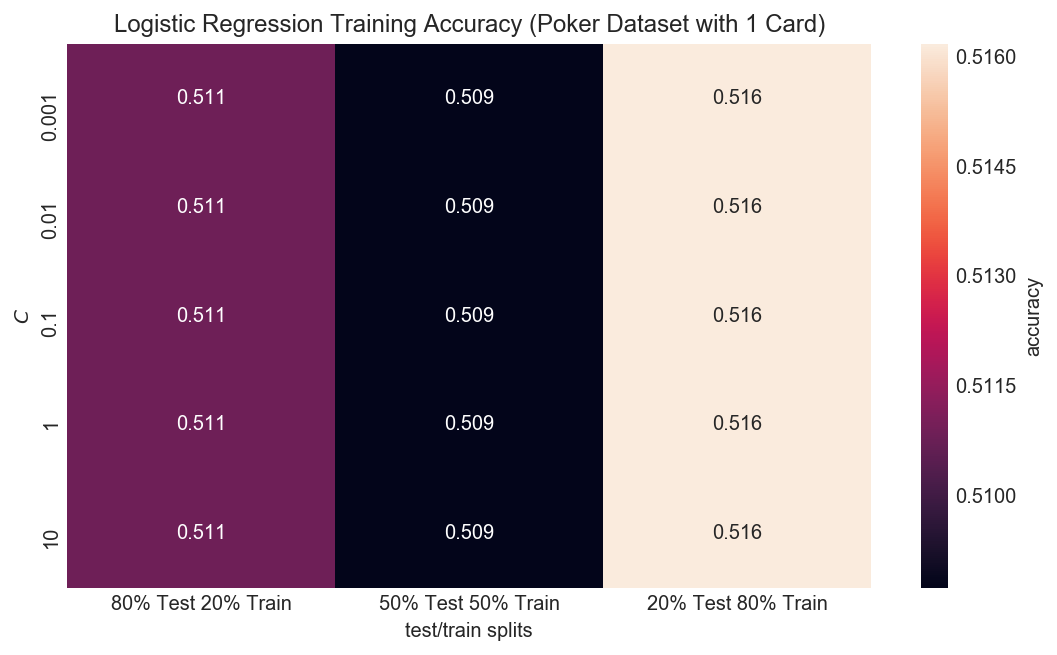

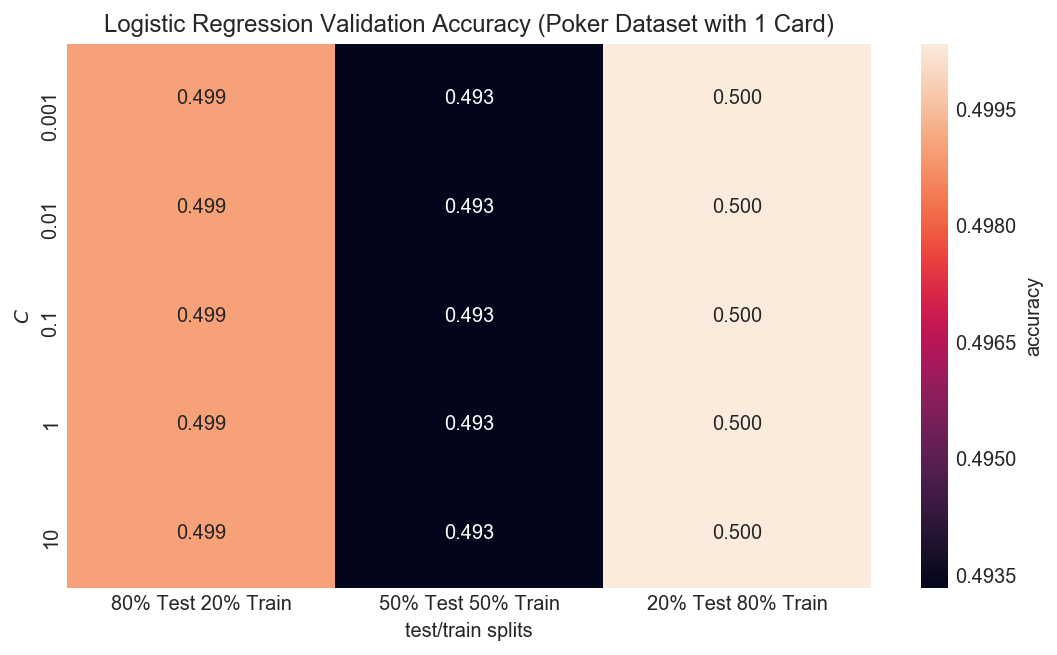

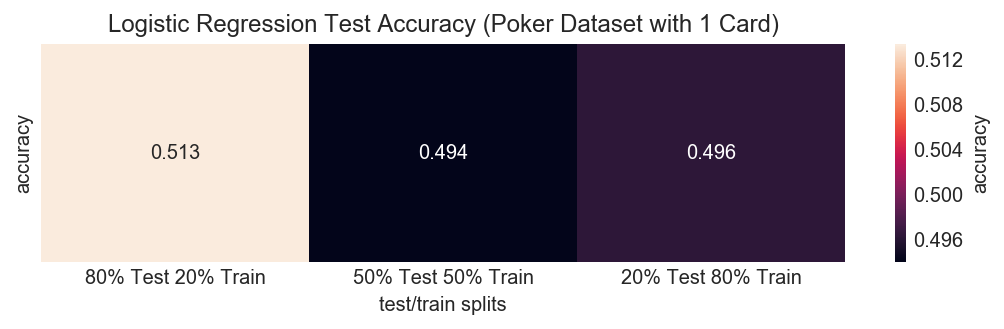

In [23]:
logReg_Poker_1 = logisticReg(X_train_val_Poker_1_Cards_1, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_1, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_1, Y_train_val_Poker_3,X_test_Poker_1_Cards_1, Y_test_Poker_1,\
            X_test_Poker_2_Cards_1, Y_test_Poker_2, X_test_Poker_3_Cards_1, Y_test_Poker_3,\
            'Logistic Regression Training Accuracy (Poker Dataset with 1 Card)', \
            'Logistic Regression Validation Accuracy (Poker Dataset with 1 Card)',\
            'Logistic Regression Test Accuracy (Poker Dataset with 1 Card)')

In [24]:
#logReg_overall_avg.append(np.mean(list(logReg_Income.values())))

temp = [] #hold split values
temp.append(logReg_Poker_1['80/20 Split Train'])
temp.append(logReg_Poker_1['80/20 Split Validation'])
temp.append(logReg_Poker_1['80/20 Split Test'])
logReg_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Poker_1['50/50 Split Train'])
temp.append(logReg_Poker_1['50/50 Split Validation'])
temp.append(logReg_Poker_1['50/50 Split Test'])
logReg_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Poker_1['20/80 Split Train'])
temp.append(logReg_Poker_1['20/80 Split Validation'])
temp.append(logReg_Poker_1['20/80 Split Test'])
logReg_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(logReg_Poker_1['80/20 Split Test'])
temp.append(logReg_Poker_1['50/50 Split Test'])
temp.append(logReg_Poker_1['20/80 Split Test'])

logReg_Poker_1_Average_Test = np.mean(np.array(temp))
logReg_Poker_1_SD_Test = np.std(np.array(temp))
logReg_Poker_1_Max_Test = np.max(np.array(temp))
logReg_Poker_1_Min_Test = np.min(np.array(temp))

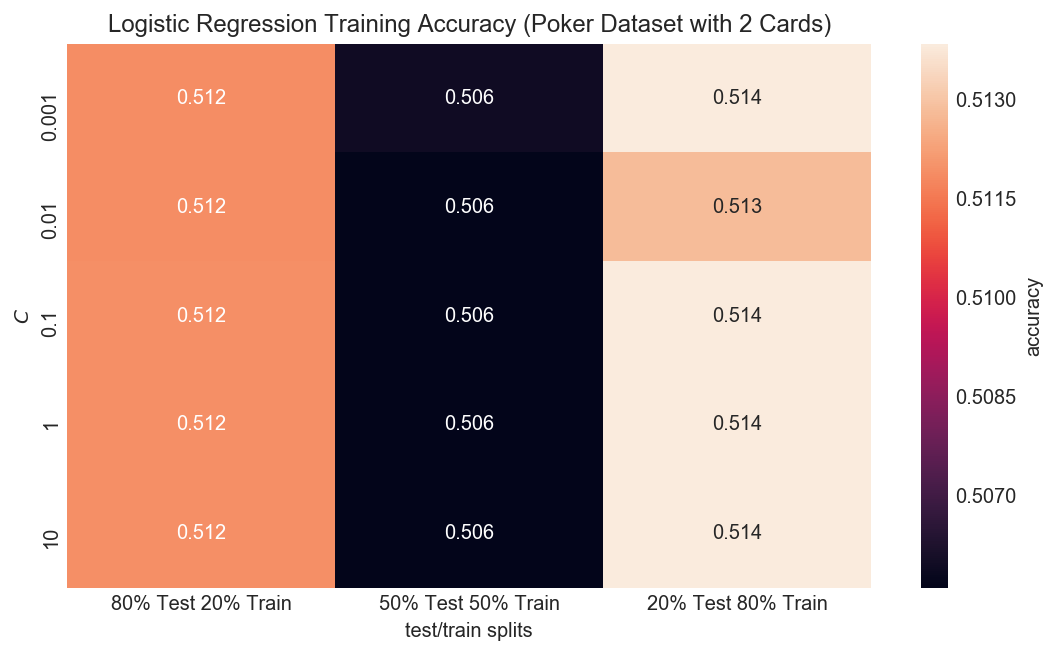

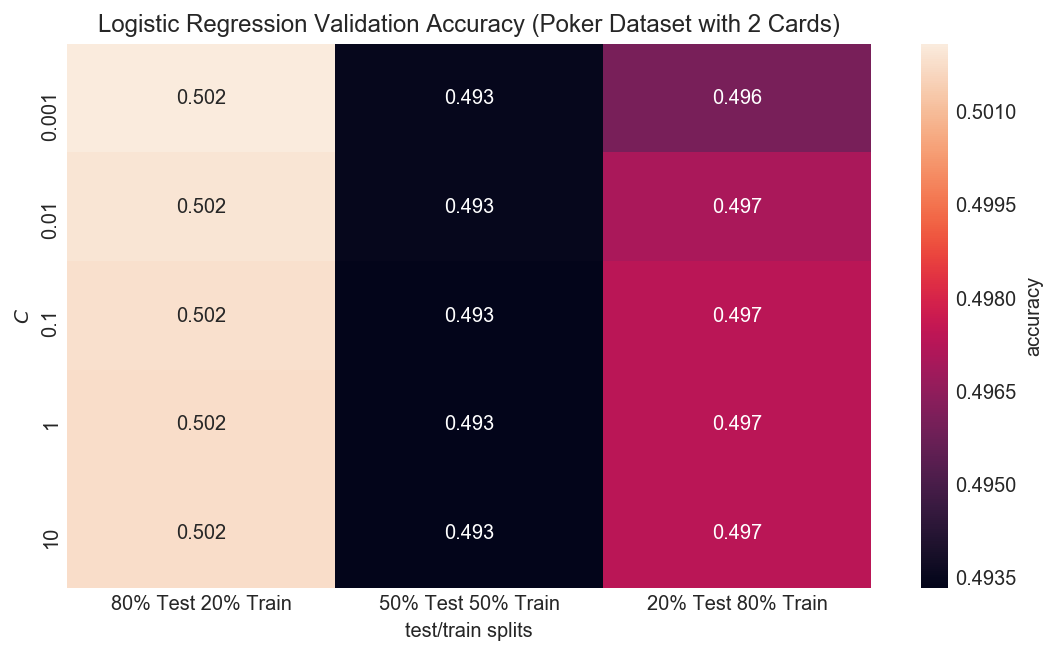

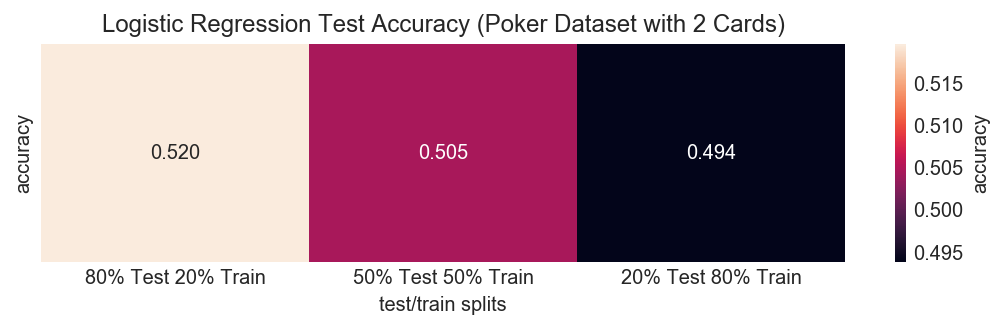

In [25]:
logReg_Poker_2 = logisticReg(X_train_val_Poker_1_Cards_2, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_2, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_2, Y_train_val_Poker_3,X_test_Poker_1_Cards_2, Y_test_Poker_1,\
            X_test_Poker_2_Cards_2, Y_test_Poker_2, X_test_Poker_3_Cards_2, Y_test_Poker_3,\
            'Logistic Regression Training Accuracy (Poker Dataset with 2 Cards)', \
            'Logistic Regression Validation Accuracy (Poker Dataset with 2 Cards)',\
            'Logistic Regression Test Accuracy (Poker Dataset with 2 Cards)')

In [26]:
#logReg_overall_avg.append(np.mean(list(logReg_Income.values())))

temp = [] #hold split values
temp.append(logReg_Poker_2['80/20 Split Train'])
temp.append(logReg_Poker_2['80/20 Split Validation'])
temp.append(logReg_Poker_2['80/20 Split Test'])
logReg_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Poker_2['50/50 Split Train'])
temp.append(logReg_Poker_2['50/50 Split Validation'])
temp.append(logReg_Poker_2['50/50 Split Test'])
logReg_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Poker_2['20/80 Split Train'])
temp.append(logReg_Poker_2['20/80 Split Validation'])
temp.append(logReg_Poker_2['20/80 Split Test'])
logReg_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(logReg_Poker_2['80/20 Split Test'])
temp.append(logReg_Poker_2['50/50 Split Test'])
temp.append(logReg_Poker_2['20/80 Split Test'])

logReg_Poker_2_Average_Test = np.mean(np.array(temp))
logReg_Poker_2_SD_Test = np.std(np.array(temp))
logReg_Poker_2_Max_Test = np.max(np.array(temp))
logReg_Poker_2_Min_Test = np.min(np.array(temp))

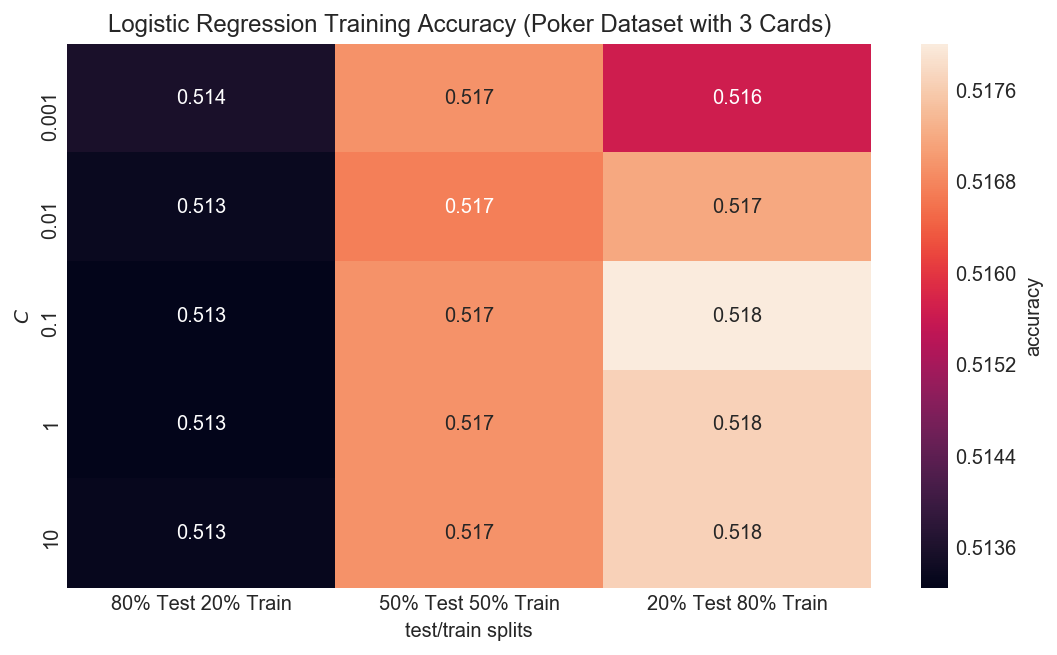

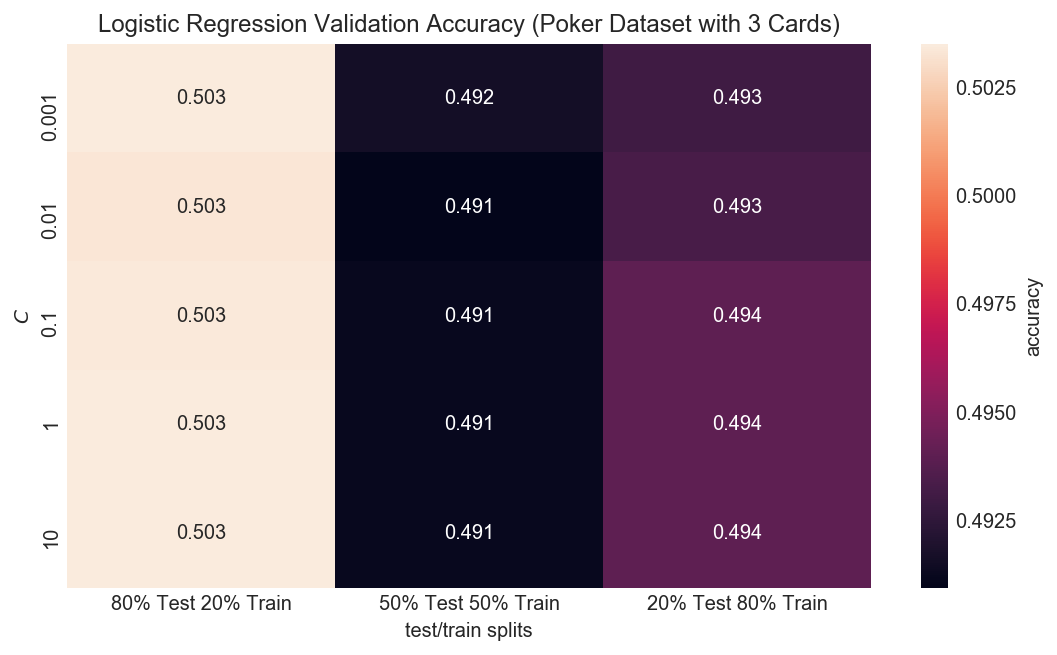

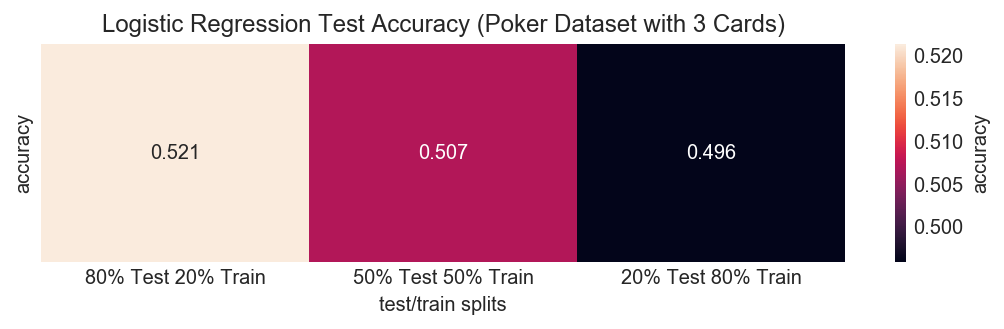

In [27]:
logReg_Poker_3 = logisticReg(X_train_val_Poker_1_Cards_3, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_3, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_3, Y_train_val_Poker_3,X_test_Poker_1_Cards_3, Y_test_Poker_1,\
            X_test_Poker_2_Cards_3, Y_test_Poker_2, X_test_Poker_3_Cards_3, Y_test_Poker_3,\
            'Logistic Regression Training Accuracy (Poker Dataset with 3 Cards)', \
            'Logistic Regression Validation Accuracy (Poker Dataset with 3 Cards)',\
            'Logistic Regression Test Accuracy (Poker Dataset with 3 Cards)')

In [28]:
#logReg_overall_avg.append(np.mean(list(logReg_Income.values())))

temp = [] #hold split values
temp.append(logReg_Poker_3['80/20 Split Train'])
temp.append(logReg_Poker_3['80/20 Split Validation'])
temp.append(logReg_Poker_3['80/20 Split Test'])
logReg_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Poker_3['50/50 Split Train'])
temp.append(logReg_Poker_3['50/50 Split Validation'])
temp.append(logReg_Poker_3['50/50 Split Test'])
logReg_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Poker_3['20/80 Split Train'])
temp.append(logReg_Poker_3['20/80 Split Validation'])
temp.append(logReg_Poker_3['20/80 Split Test'])
logReg_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(logReg_Poker_3['80/20 Split Test'])
temp.append(logReg_Poker_3['50/50 Split Test'])
temp.append(logReg_Poker_3['20/80 Split Test'])

logReg_Poker_3_Average_Test = np.mean(np.array(temp))
logReg_Poker_3_SD_Test = np.std(np.array(temp))
logReg_Poker_3_Max_Test = np.max(np.array(temp))
logReg_Poker_3_Min_Test = np.min(np.array(temp))

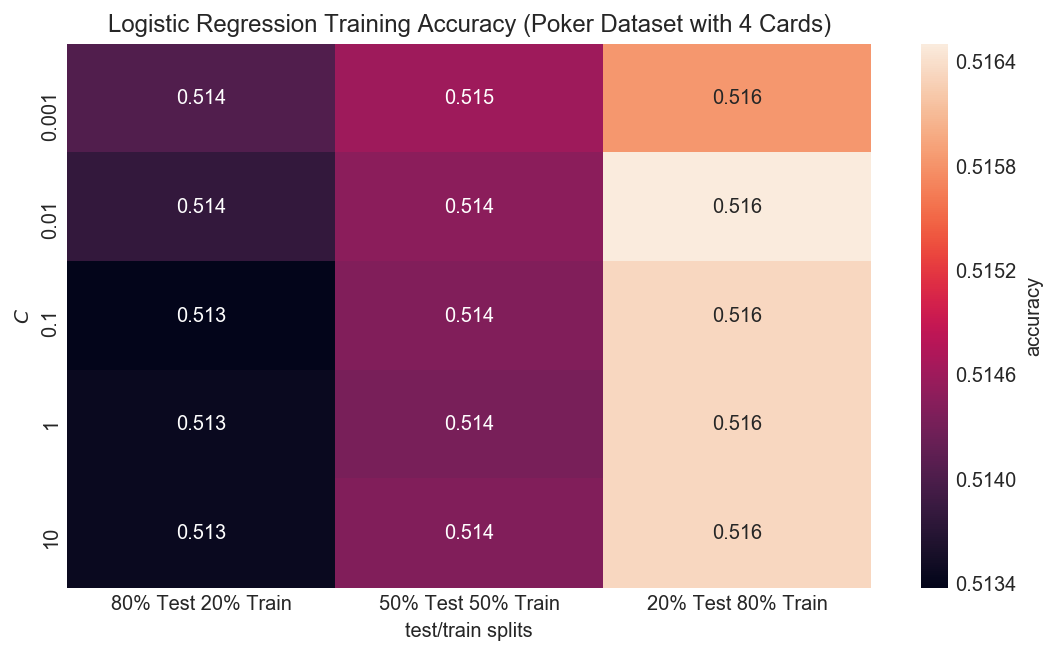

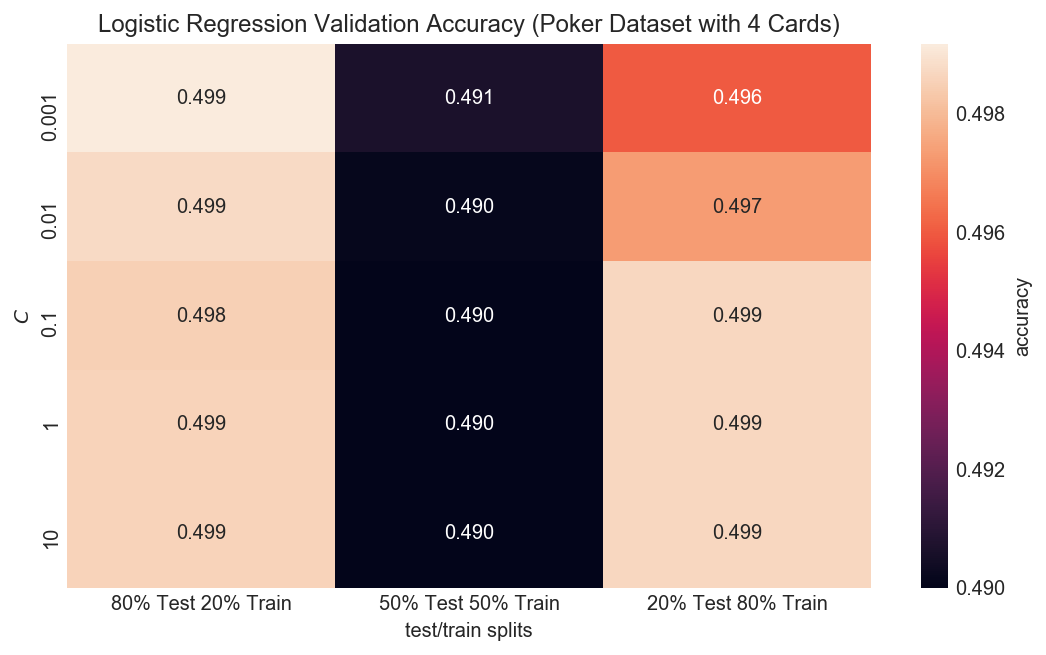

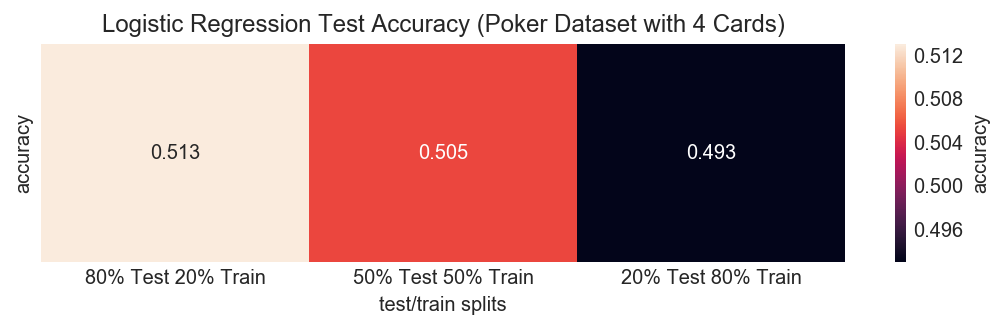

In [29]:
logReg_Poker_4 = logisticReg(X_train_val_Poker_1_Cards_4, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_4, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_4, Y_train_val_Poker_3,X_test_Poker_1_Cards_4, Y_test_Poker_1,\
            X_test_Poker_2_Cards_4, Y_test_Poker_2, X_test_Poker_3_Cards_4, Y_test_Poker_3,\
            'Logistic Regression Training Accuracy (Poker Dataset with 4 Cards)', \
            'Logistic Regression Validation Accuracy (Poker Dataset with 4 Cards)',\
            'Logistic Regression Test Accuracy (Poker Dataset with 4 Cards)')

In [30]:
#logReg_overall_avg.append(np.mean(list(logReg_Income.values())))

temp = [] #hold split values
temp.append(logReg_Poker_4['80/20 Split Train'])
temp.append(logReg_Poker_4['80/20 Split Validation'])
temp.append(logReg_Poker_4['80/20 Split Test'])
logReg_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Poker_4['50/50 Split Train'])
temp.append(logReg_Poker_4['50/50 Split Validation'])
temp.append(logReg_Poker_4['50/50 Split Test'])
logReg_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Poker_4['20/80 Split Train'])
temp.append(logReg_Poker_4['20/80 Split Validation'])
temp.append(logReg_Poker_4['20/80 Split Test'])
logReg_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(logReg_Poker_4['80/20 Split Test'])
temp.append(logReg_Poker_4['50/50 Split Test'])
temp.append(logReg_Poker_4['20/80 Split Test'])

logReg_Poker_4_Average_Test = np.mean(np.array(temp))
logReg_Poker_4_SD_Test = np.std(np.array(temp))
logReg_Poker_4_Max_Test = np.max(np.array(temp))
logReg_Poker_4_Min_Test = np.min(np.array(temp))

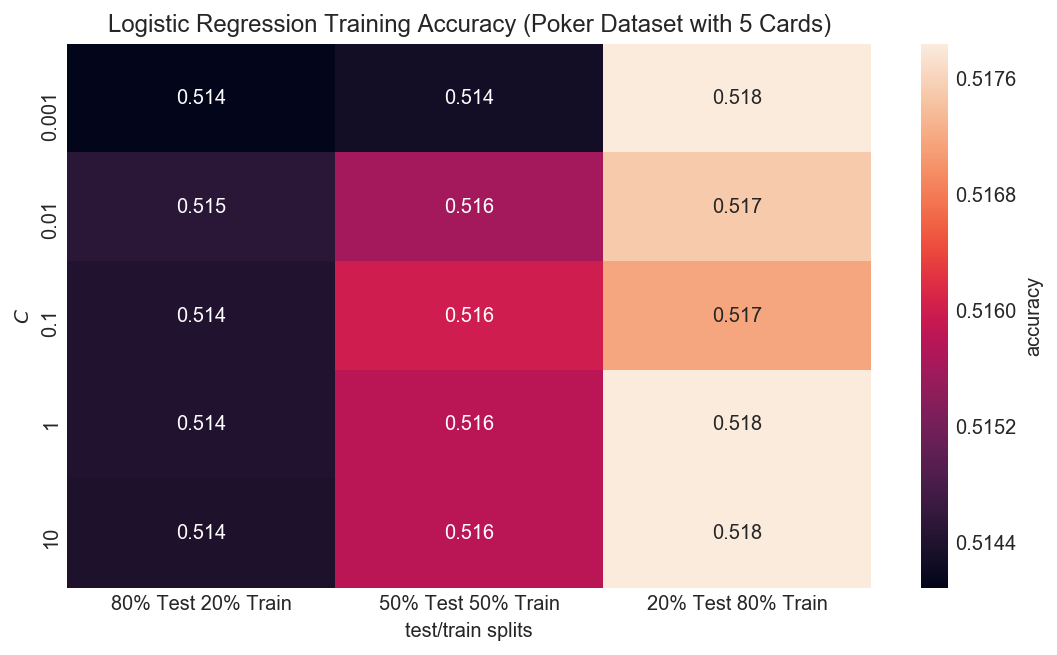

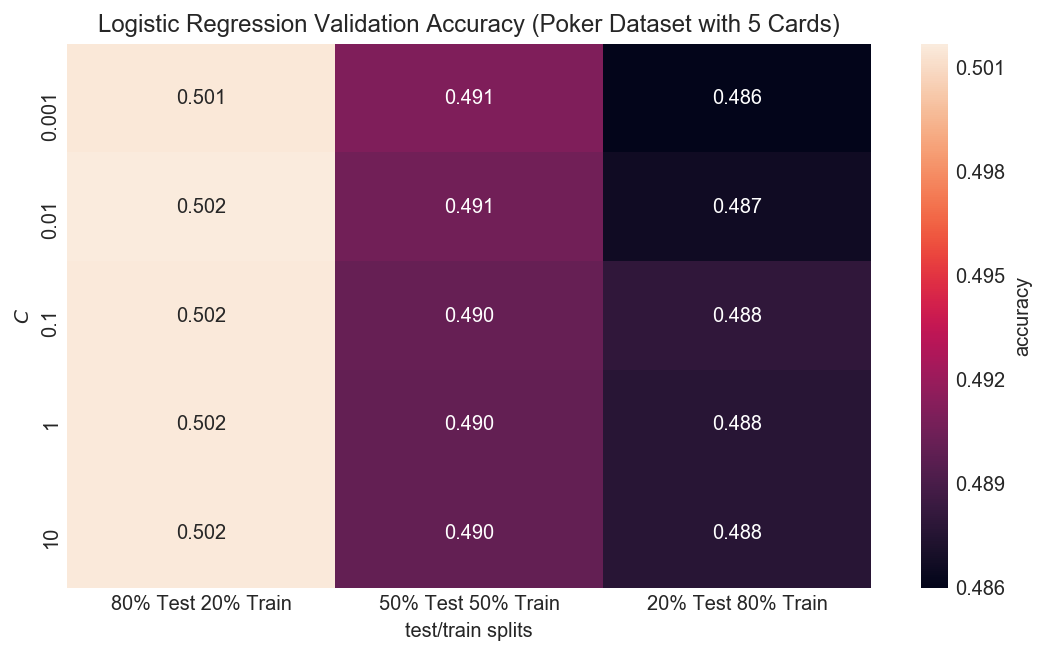

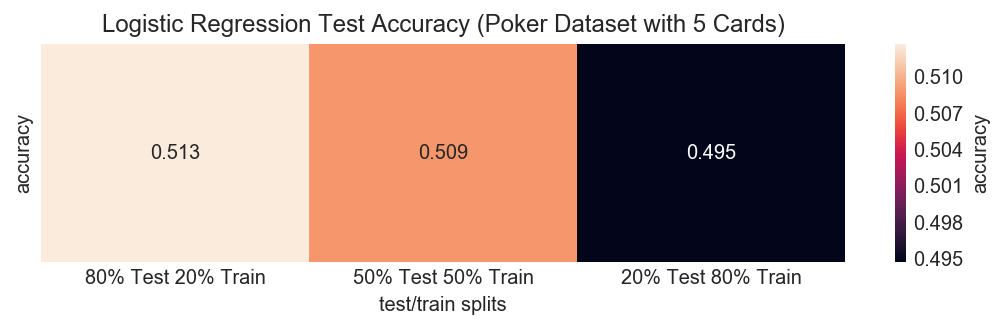

In [31]:
logReg_Poker_5 = logisticReg(X_train_val_Poker_1_Cards_5, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_5, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_5, Y_train_val_Poker_3,X_test_Poker_1_Cards_5, Y_test_Poker_1,\
            X_test_Poker_2_Cards_5, Y_test_Poker_2, X_test_Poker_3_Cards_5, Y_test_Poker_3,\
            'Logistic Regression Training Accuracy (Poker Dataset with 5 Cards)', \
            'Logistic Regression Validation Accuracy (Poker Dataset with 5 Cards)',\
            'Logistic Regression Test Accuracy (Poker Dataset with 5 Cards)')

In [32]:
logReg_overall_avg.append(np.mean(list(logReg_Poker_5.values())))

temp = [] #hold split values
temp.append(logReg_Poker_5['80/20 Split Train'])
temp.append(logReg_Poker_5['80/20 Split Validation'])
temp.append(logReg_Poker_5['80/20 Split Test'])
logReg_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Poker_5['50/50 Split Train'])
temp.append(logReg_Poker_5['50/50 Split Validation'])
temp.append(logReg_Poker_5['50/50 Split Test'])
logReg_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Poker_5['20/80 Split Train'])
temp.append(logReg_Poker_5['20/80 Split Validation'])
temp.append(logReg_Poker_5['20/80 Split Test'])
logReg_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(logReg_Poker_5['80/20 Split Test'])
temp.append(logReg_Poker_5['50/50 Split Test'])
temp.append(logReg_Poker_5['20/80 Split Test'])

logReg_Poker_5_Average_Test = np.mean(np.array(temp))
logReg_Poker_5_SD_Test = np.std(np.array(temp))
logReg_Poker_5_Max_Test = np.max(np.array(temp))
logReg_Poker_5_Min_Test = np.min(np.array(temp))

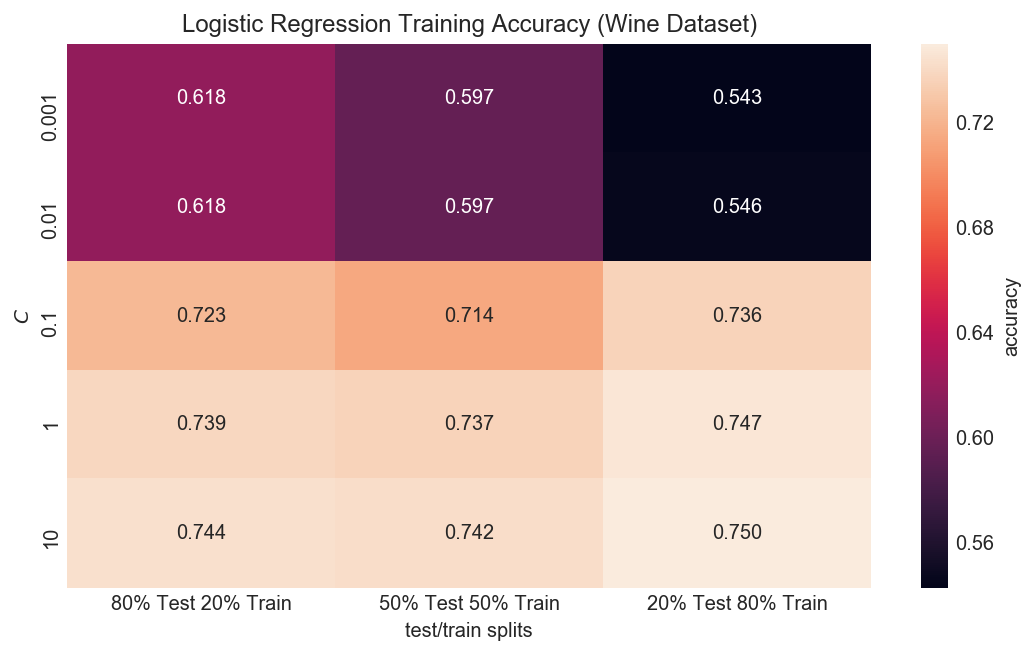

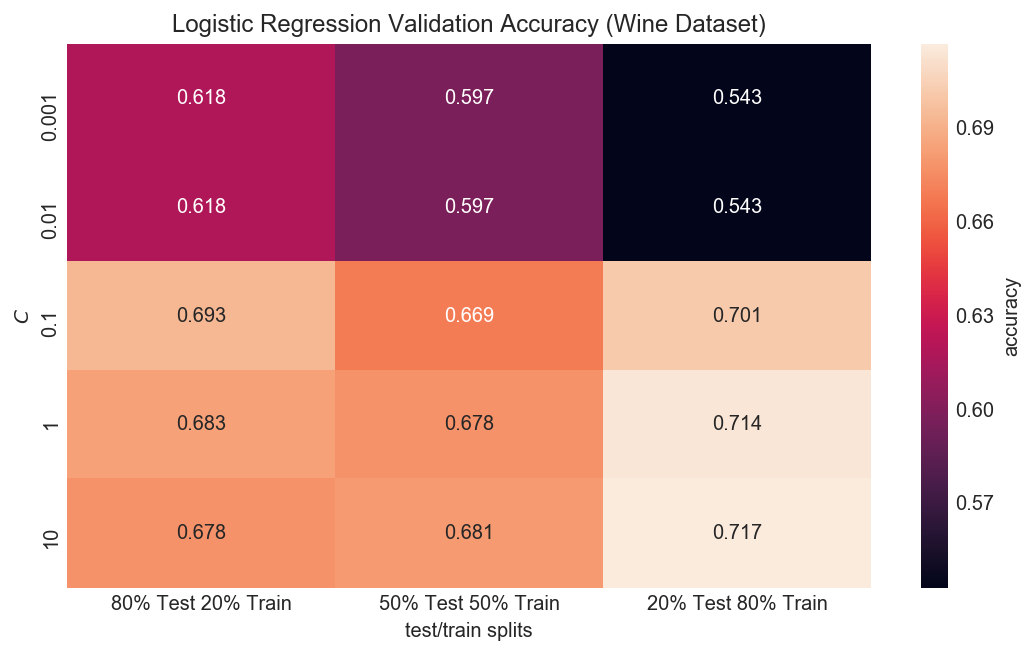

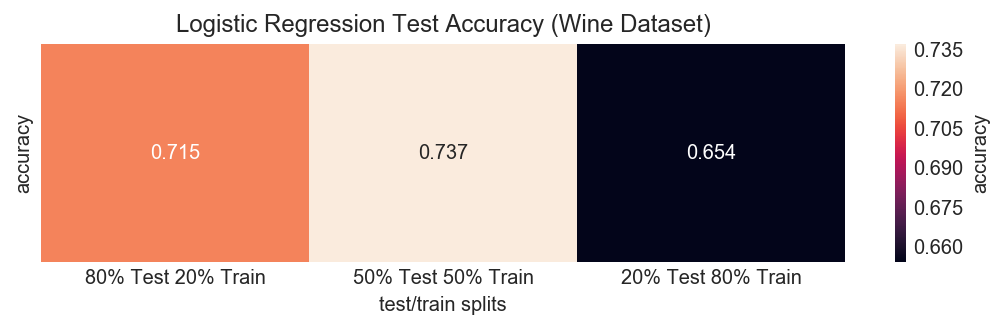

In [33]:
logReg_Wine = logisticReg(X_train_val_Wine_1, Y_train_val_Wine_1,X_train_val_Wine_2, Y_train_val_Wine_2,\
            X_train_val_Wine_3, Y_train_val_Wine_3,X_test_Wine_1, Y_test_Wine_1, \
            X_test_Wine_2, Y_test_Wine_2,X_test_Wine_3, Y_test_Wine_3,\
            'Logistic Regression Training Accuracy (Wine Dataset)', \
            'Logistic Regression Validation Accuracy (Wine Dataset)', \
            'Logistic Regression Test Accuracy (Wine Dataset)')

In [34]:
logReg_overall_avg.append(np.mean(list(logReg_Wine.values())))

temp = [] #hold split values
temp.append(logReg_Wine['80/20 Split Train'])
temp.append(logReg_Wine['80/20 Split Validation'])
temp.append(logReg_Wine['80/20 Split Test'])
logReg_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Wine['50/50 Split Train'])
temp.append(logReg_Wine['50/50 Split Validation'])
temp.append(logReg_Wine['50/50 Split Test'])
logReg_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(logReg_Wine['20/80 Split Train'])
temp.append(logReg_Wine['20/80 Split Validation'])
temp.append(logReg_Wine['20/80 Split Test'])
logReg_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(logReg_Wine['80/20 Split Test'])
temp.append(logReg_Wine['50/50 Split Test'])
temp.append(logReg_Wine['20/80 Split Test'])

logReg_Wine_Average_Test = np.mean(np.array(temp))
logReg_Wine_SD_Test = np.std(np.array(temp))
logReg_Wine_Max_Test = np.max(np.array(temp))
logReg_Wine_Min_Test = np.min(np.array(temp))

### Classifier 2: SVM Using Linear Kernel

In [35]:
#svm with cross validation of 3
def svm(X_train_pred_1, Y_train_val_1, X_train_pred_2, Y_train_val_2, X_train_pred_3, Y_train_val_3,\
               X_test_1, Y_test_1, X_test_2, Y_test_2, X_test_3, Y_test_3, title1, title2, title3):
    # Initialize model.
    svm = SVC(kernel='linear')
    
    c_list = [0.001, 0.01, 0.1, 1, 10]
    test_train_split = ['80% Test 20% Train', '50% Test 50% Train', '20% Test 80% Train']
    
    grid_search_1 = GridSearchCV(svm, {'C': c_list},  cv = 3, return_train_score= True, iid = False)
    grid_search_1.fit(X_train_pred_1, Y_train_val_1)
    
    grid_search_2 = GridSearchCV(svm, {'C': c_list},  cv = 3, return_train_score= True, iid = False)
    grid_search_2.fit(X_train_pred_2, Y_train_val_2)
    
    grid_search_3 = GridSearchCV(svm, {'C': c_list},  cv = 3, return_train_score= True, iid = False)
    grid_search_3.fit(X_train_pred_3, Y_train_val_3)

    
    #training accuracy
    train_acc_1 = grid_search_1.cv_results_['mean_train_score'].reshape(5,1)
    train_acc_2 = grid_search_2.cv_results_['mean_train_score'].reshape(5,1)
    train_acc_3 = grid_search_3.cv_results_['mean_train_score'].reshape(5,1)
    
    train_acc = np.array([[train_acc_1],[train_acc_2], [train_acc_3]]).T
    train_acc = train_acc.reshape(5,3)
    #print(train_acc)
    draw_heatmap_SVM(train_acc, title1, c_list, test_train_split)

    
    #validation accuracy
    val_acc_1 = grid_search_1.cv_results_['mean_test_score'].reshape(5,1)
    val_acc_2 = grid_search_2.cv_results_['mean_test_score'].reshape(5,1)
    val_acc_3 = grid_search_3.cv_results_['mean_test_score'].reshape(5,1)
    
    val_acc = np.array([[val_acc_1],[val_acc_2], [val_acc_3]]).T
    val_acc = val_acc.reshape(5,3)
    #print(train_acc)
    draw_heatmap_SVM(val_acc, title2, c_list, test_train_split)
    
    
    #test accuracy
    counter = 0
    pred_1 = grid_search_1.predict(X_test_1)
    for i in range(len(pred_1)):
        if pred_1[i] != Y_test_1.iloc[i]:
            counter += 1
    test_acc_1 = 1-(counter / len(pred_1))
    
    counter = 0
    pred_2 = grid_search_2.predict(X_test_2)
    for i in range(len(pred_2)):
        if pred_2[i] != Y_test_2.iloc[i]:
            counter += 1
    test_acc_2 = 1-(counter / len(pred_2))
    
    counter = 0
    pred_3 = grid_search_3.predict(X_test_3)
    for i in range(len(pred_3)):
        if pred_3[i] != Y_test_3.iloc[i]:
            counter += 1
    test_acc_3 = 1-(counter / len(pred_3))
    
    test_acc = np.array([[test_acc_1], [test_acc_2], [test_acc_3]]).reshape(1,3)
    draw_heatmap_SVM_test(test_acc, title3, test_train_split)
    
    svmDict = {}
    svmDict['80/20 Split Train'] = np.mean(train_acc_1)
    svmDict['50/50 Split Train'] = np.mean(train_acc_2)
    svmDict['20/80 Split Train'] = np.mean(train_acc_3)
    svmDict['80/20 Split Validation'] = np.mean(val_acc_1)
    svmDict['50/50 Split Validation'] = np.mean(val_acc_2)
    svmDict['20/80 Split Validation'] = np.mean(val_acc_3)
    svmDict['80/20 Split Test'] = test_acc_1
    svmDict['50/50 Split Test'] = test_acc_2
    svmDict['20/80 Split Test'] = test_acc_3
    return svmDict

#### Avg SVM Parameter Values

In [36]:
svm_Income_Average_Test = 0
svm_Income_SD_Test = 0
svm_Income_Max_Test = 0
svm_Income_Min_Test = 0

svm_Poker_1_Average_Test = 0
svm_Poker_1_SD_Test = 0
svm_Poker_1_Max_Test = 0
svm_Poker_1_Min_Test = 0

svm_Poker_2_Average_Test = 0
svm_Poker_2_SD_Test = 0
svm_Poker_2_Max_Test = 0
svm_Poker_2_Min_Test = 0

svm_Poker_3_Average_Test = 0
svm_Poker_3_SD_Test = 0
svm_Poker_3_Max_Test = 0
svm_Poker_3_Min_Test = 0

svm_Poker_5_Average_Test = 0
svm_Poker_5_SD_Test = 0
svm_Poker_5_Max_Test = 0
svm_Poker_5_Min_Test = 0

svm_Poker_Overall_Average_Test = 0
svm_Poker_Overall_SD_Test = 0
svm_Poker_Overall_Max_Test = 0
svm_Poker_Overall_Min_Test = 0

svm_Wine_Average_Test = 0
svm_Wine_SD_Test = 0
svm_Wine_Max_Test = 0
svm_Wine_Min_Test = 0

svm_overall_avg = []
svm_80_20_split_avg = []
svm_50_50_split_avg = []
svm_20_80_split_avg = []

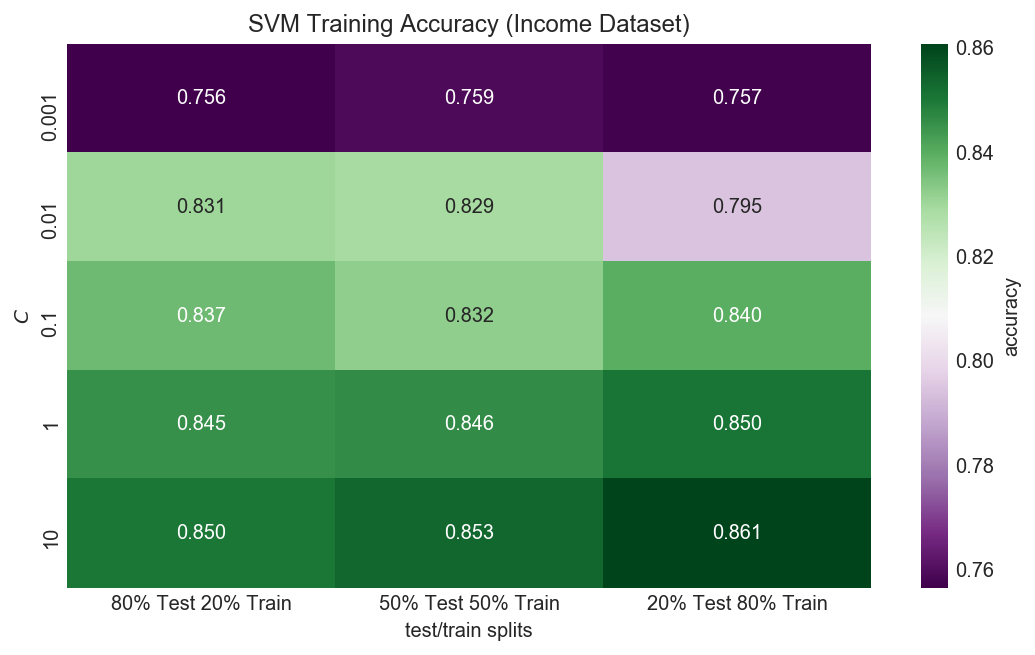

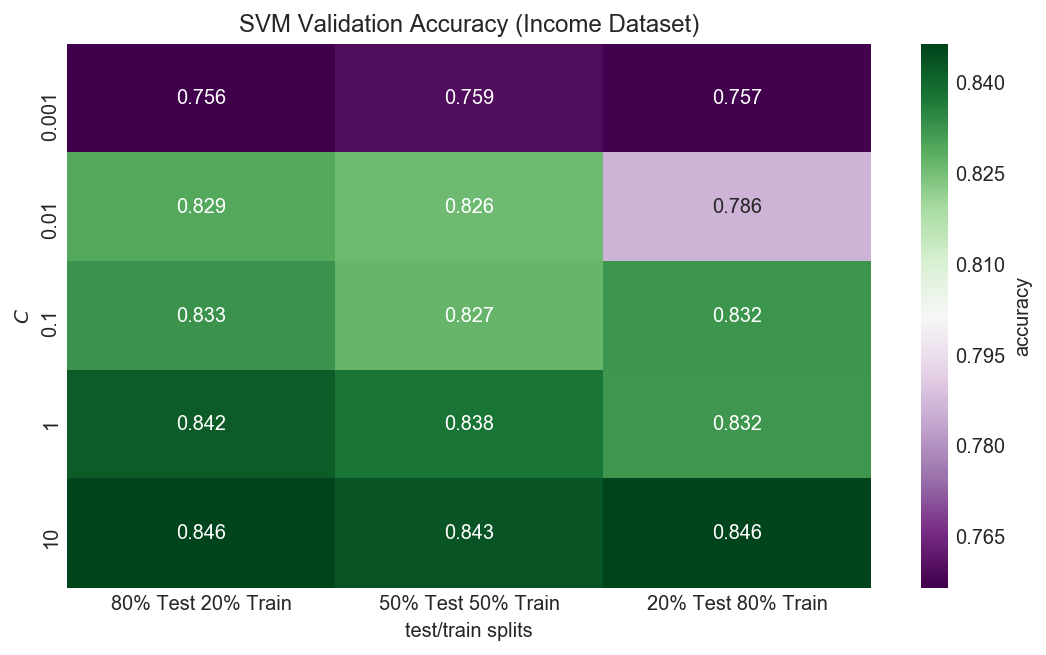

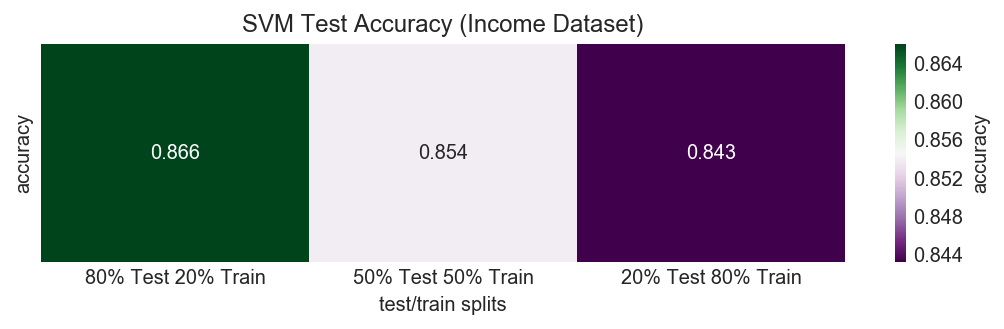

In [37]:
svm_Income = svm(X_train_val_Income_1, Y_train_val_Income_1,X_train_val_Income_2, Y_train_val_Income_2,\
            X_train_val_Income_3, Y_train_val_Income_3, X_test_Income_1, Y_test_Income_1,\
            X_test_Income_2, Y_test_Income_2, X_test_Income_3, Y_test_Income_3,\
            'SVM Training Accuracy (Income Dataset)', \
            'SVM Validation Accuracy (Income Dataset)',\
            'SVM Test Accuracy (Income Dataset)')

In [38]:
svm_overall_avg.append(np.mean(list(svm_Income.values())))

temp = [] #hold split values
temp.append(svm_Income['80/20 Split Train'])
temp.append(svm_Income['80/20 Split Validation'])
temp.append(svm_Income['80/20 Split Test'])
svm_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Income['50/50 Split Train'])
temp.append(svm_Income['50/50 Split Validation'])
temp.append(svm_Income['50/50 Split Test'])
svm_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Income['20/80 Split Train'])
temp.append(svm_Income['20/80 Split Validation'])
temp.append(svm_Income['20/80 Split Test'])
svm_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(svm_Income['80/20 Split Test'])
temp.append(svm_Income['50/50 Split Test'])
temp.append(svm_Income['20/80 Split Test'])

svm_Income_Average_Test = np.mean(np.array(temp))
svm_Income_SD_Test = np.std(np.array(temp))
svm_Income_Max_Test = np.max(np.array(temp))
svm_Income_Min_Test = np.min(np.array(temp))

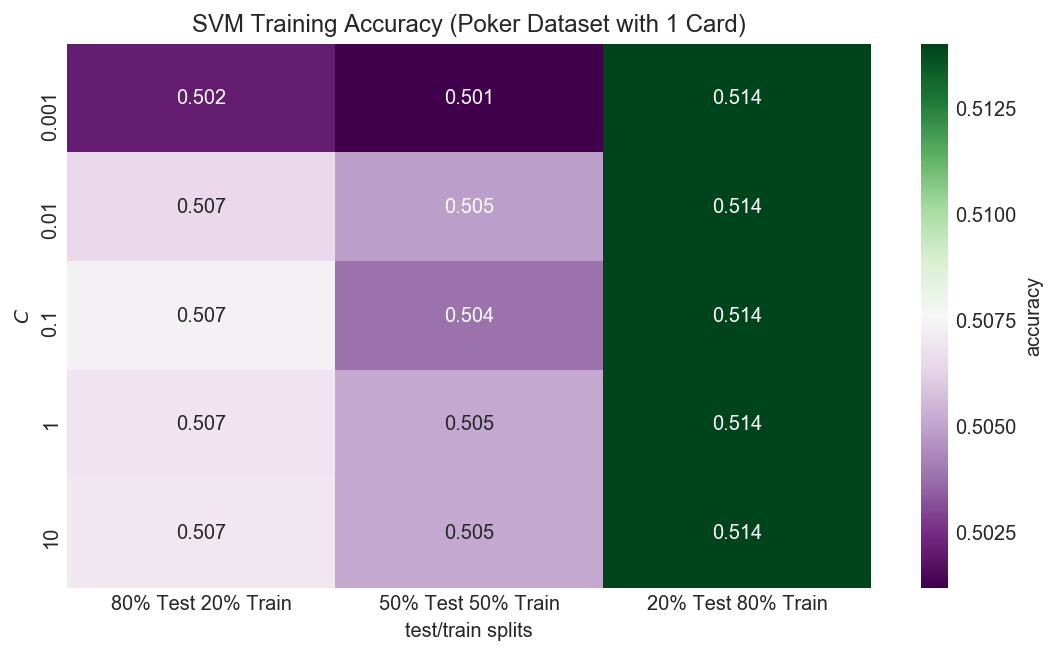

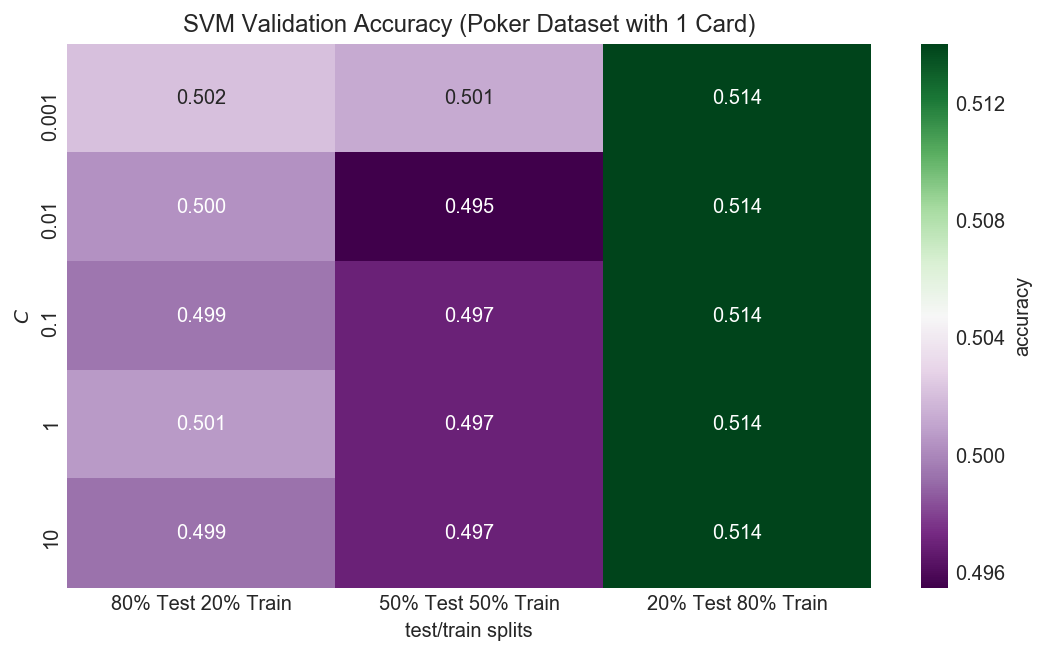

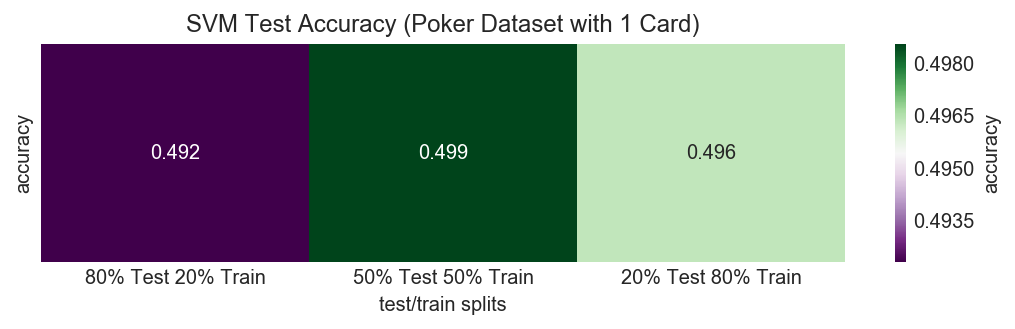

In [39]:
svm_Poker_1 = svm(X_train_val_Poker_1_Cards_1, Y_train_val_Poker_1, X_train_val_Poker_2_Cards_1, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_1, Y_train_val_Poker_3, X_test_Poker_1_Cards_1, Y_test_Poker_1,\
            X_test_Poker_2_Cards_1, Y_test_Poker_2, X_test_Poker_3_Cards_1, Y_test_Poker_3,\
            'SVM Training Accuracy (Poker Dataset with 1 Card)', \
            'SVM Validation Accuracy (Poker Dataset with 1 Card)', \
            'SVM Test Accuracy (Poker Dataset with 1 Card)')

In [40]:
#svm_overall_avg.append(np.mean(list(svm_Poker_1.values())))

temp = [] #hold split values
temp.append(svm_Poker_1['80/20 Split Train'])
temp.append(svm_Poker_1['80/20 Split Validation'])
temp.append(svm_Poker_1['80/20 Split Test'])
svm_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Poker_1['50/50 Split Train'])
temp.append(svm_Poker_1['50/50 Split Validation'])
temp.append(svm_Poker_1['50/50 Split Test'])
svm_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Poker_1['20/80 Split Train'])
temp.append(svm_Poker_1['20/80 Split Validation'])
temp.append(svm_Poker_1['20/80 Split Test'])
svm_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(svm_Poker_1['80/20 Split Test'])
temp.append(svm_Poker_1['50/50 Split Test'])
temp.append(svm_Poker_1['20/80 Split Test'])

svm_Poker_1_Average_Test = np.mean(np.array(temp))
svm_Poker_1_SD_Test = np.std(np.array(temp))
svm_Poker_1_Max_Test = np.max(np.array(temp))
svm_Poker_1_Min_Test = np.min(np.array(temp))

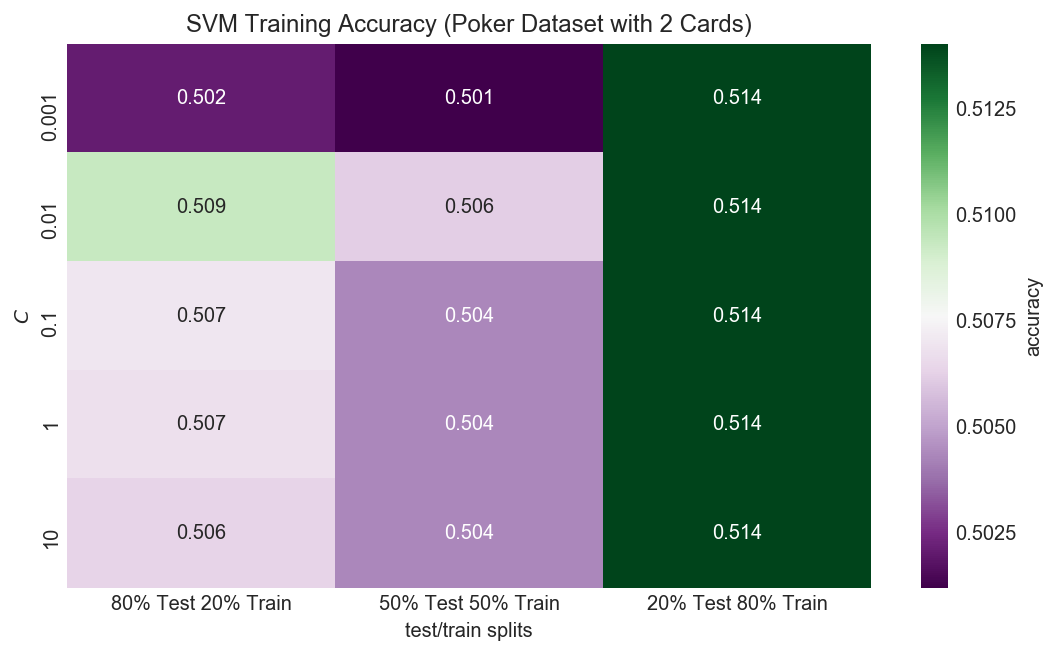

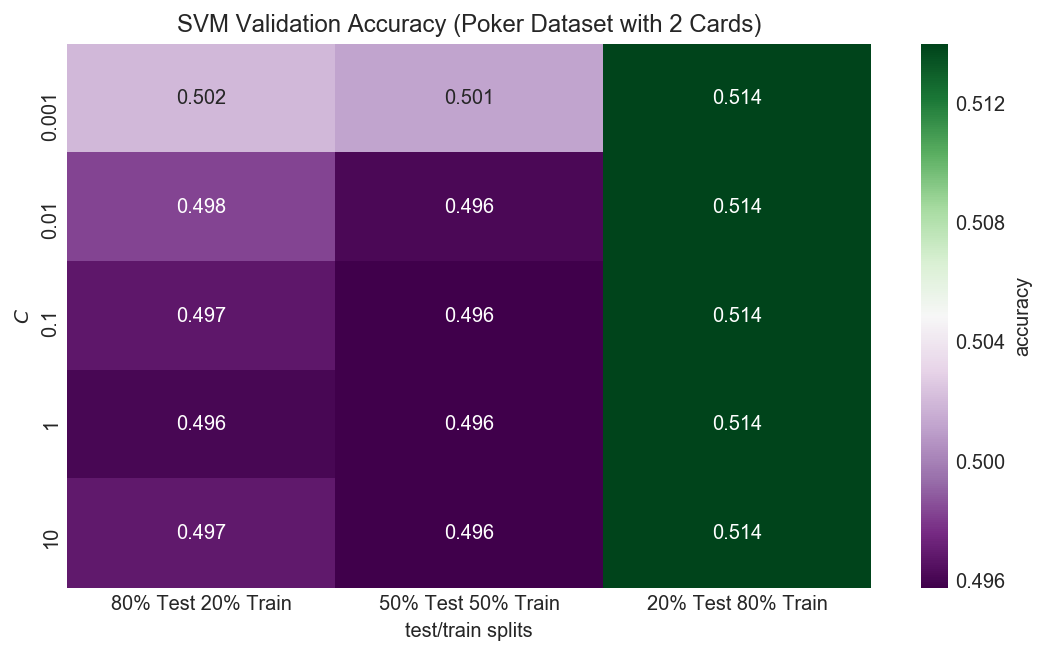

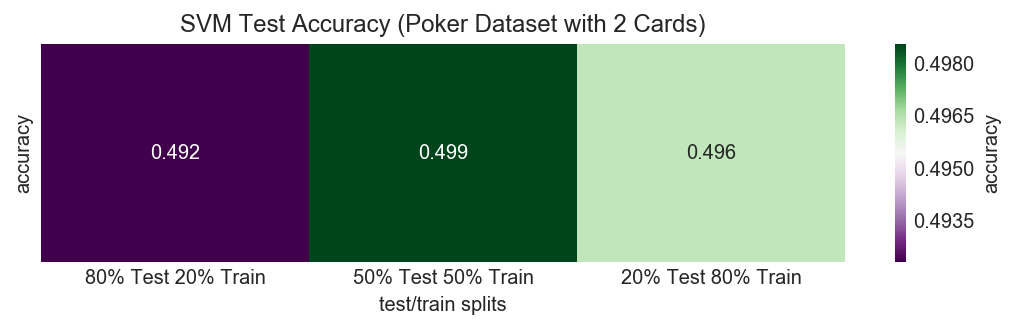

In [41]:
svm_Poker_2 = svm(X_train_val_Poker_1_Cards_2, Y_train_val_Poker_1, X_train_val_Poker_2_Cards_2, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_2, Y_train_val_Poker_3, X_test_Poker_1_Cards_2, Y_test_Poker_1,\
            X_test_Poker_2_Cards_2, Y_test_Poker_2, X_test_Poker_3_Cards_2, Y_test_Poker_3,\
            'SVM Training Accuracy (Poker Dataset with 2 Cards)', \
            'SVM Validation Accuracy (Poker Dataset with 2 Cards)',\
            'SVM Test Accuracy (Poker Dataset with 2 Cards)')

In [42]:
#svm_overall_avg.append(np.mean(list(svm_Poker_2.values())))

temp = [] #hold split values
temp.append(svm_Poker_2['80/20 Split Train'])
temp.append(svm_Poker_2['80/20 Split Validation'])
temp.append(svm_Poker_2['80/20 Split Test'])
svm_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Poker_2['50/50 Split Train'])
temp.append(svm_Poker_2['50/50 Split Validation'])
temp.append(svm_Poker_2['50/50 Split Test'])
svm_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Poker_2['20/80 Split Train'])
temp.append(svm_Poker_2['20/80 Split Validation'])
temp.append(svm_Poker_2['20/80 Split Test'])
svm_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(svm_Poker_2['80/20 Split Test'])
temp.append(svm_Poker_2['50/50 Split Test'])
temp.append(svm_Poker_2['20/80 Split Test'])

svm_Poker_2_Average_Test = np.mean(np.array(temp))
svm_Poker_2_SD_Test = np.std(np.array(temp))
svm_Poker_2_Max_Test = np.max(np.array(temp))
svm_Poker_2_Min_Test = np.min(np.array(temp))

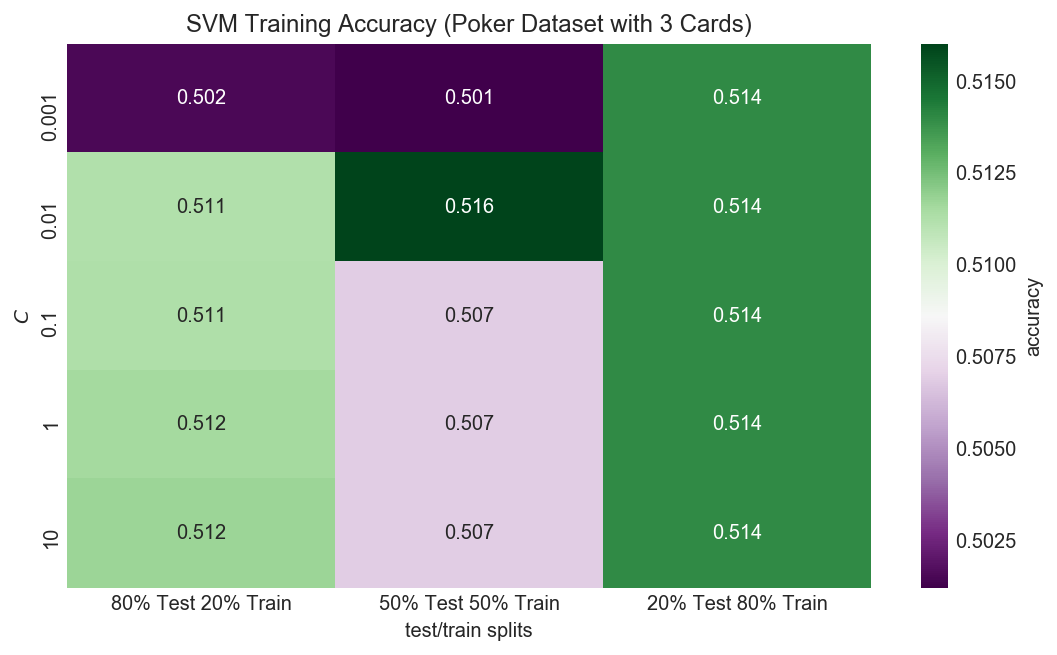

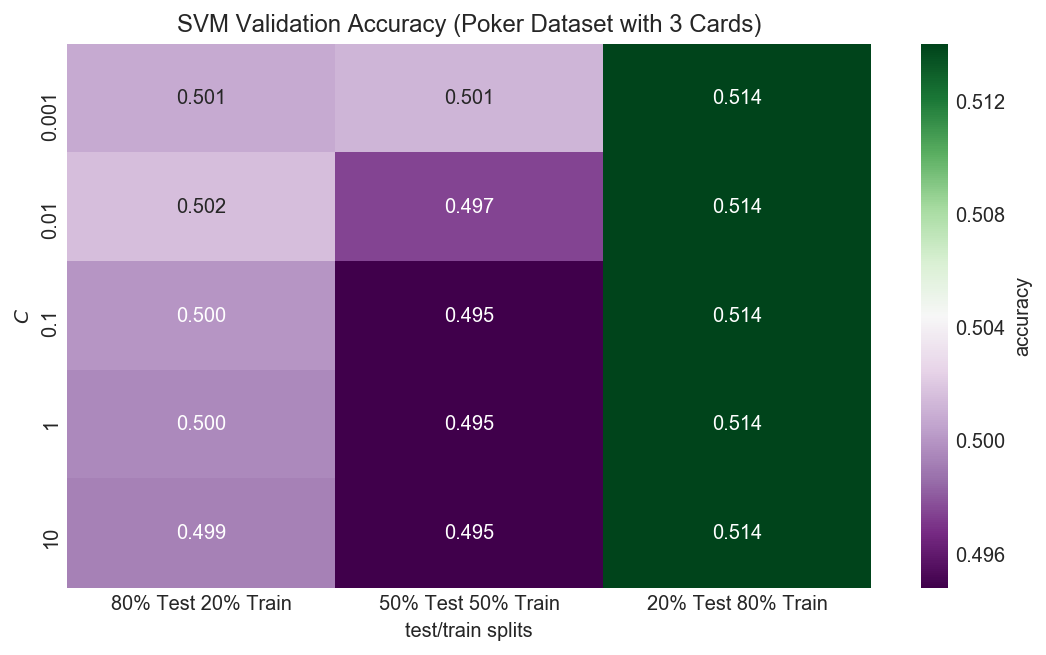

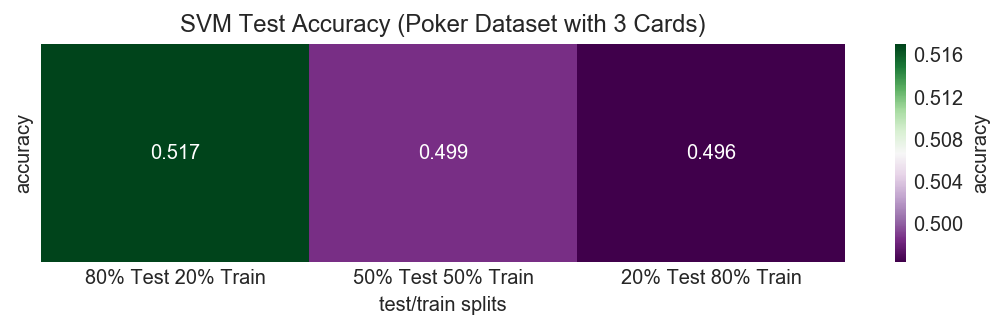

In [43]:
svm_Poker_3 = svm(X_train_val_Poker_1_Cards_3, Y_train_val_Poker_1, X_train_val_Poker_2_Cards_3, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_3, Y_train_val_Poker_3, X_test_Poker_1_Cards_3, Y_test_Poker_1,\
            X_test_Poker_2_Cards_3, Y_test_Poker_2, X_test_Poker_3_Cards_3, Y_test_Poker_3,\
            'SVM Training Accuracy (Poker Dataset with 3 Cards)', \
            'SVM Validation Accuracy (Poker Dataset with 3 Cards)',\
            'SVM Test Accuracy (Poker Dataset with 3 Cards)')

In [44]:
#svm_overall_avg.append(np.mean(list(svm_Poker_3.values())))

temp = [] #hold split values
temp.append(svm_Poker_3['80/20 Split Train'])
temp.append(svm_Poker_3['80/20 Split Validation'])
temp.append(svm_Poker_3['80/20 Split Test'])
svm_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Poker_3['50/50 Split Train'])
temp.append(svm_Poker_3['50/50 Split Validation'])
temp.append(svm_Poker_3['50/50 Split Test'])
svm_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Poker_3['20/80 Split Train'])
temp.append(svm_Poker_3['20/80 Split Validation'])
temp.append(svm_Poker_3['20/80 Split Test'])
svm_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(svm_Poker_3['80/20 Split Test'])
temp.append(svm_Poker_3['50/50 Split Test'])
temp.append(svm_Poker_3['20/80 Split Test'])

svm_Poker_3_Average_Test = np.mean(np.array(temp))
svm_Poker_3_SD_Test = np.std(np.array(temp))
svm_Poker_3_Max_Test = np.max(np.array(temp))
svm_Poker_3_Min_Test = np.min(np.array(temp))

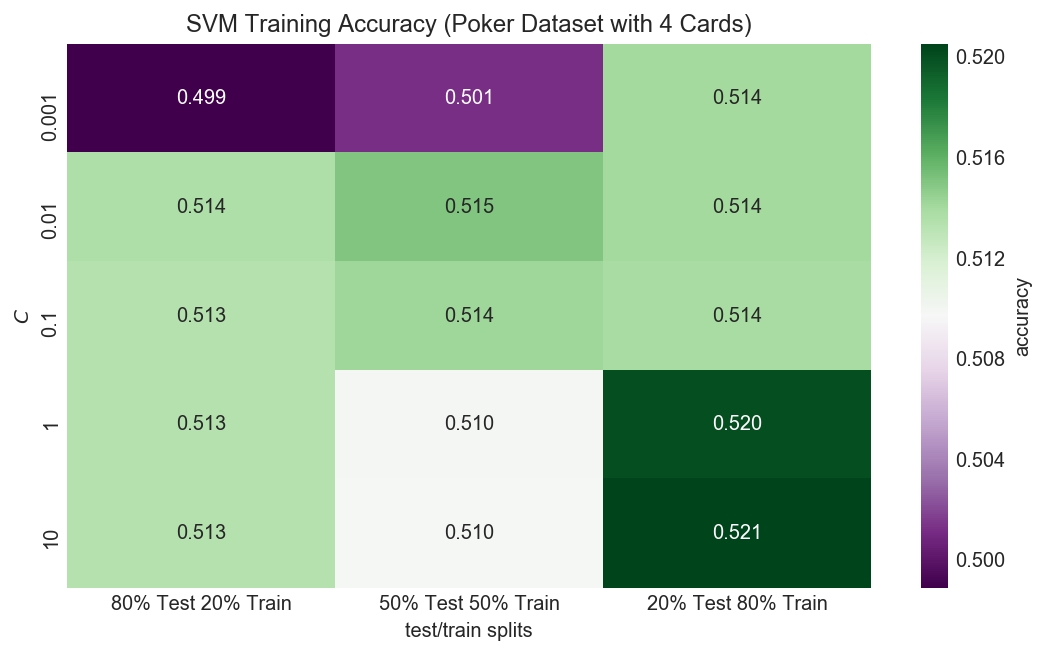

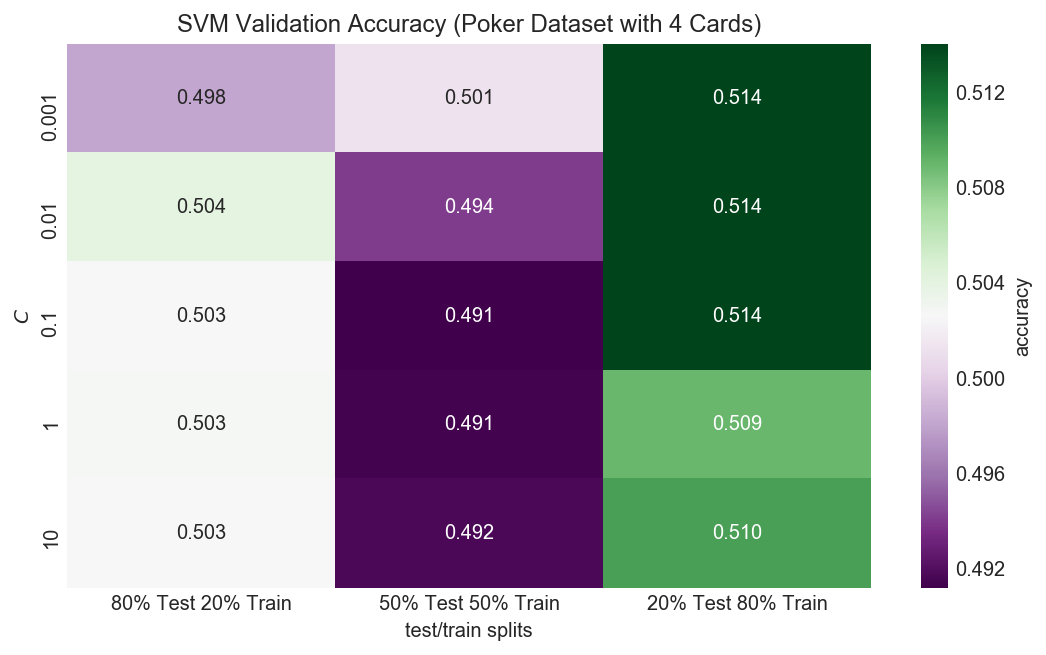

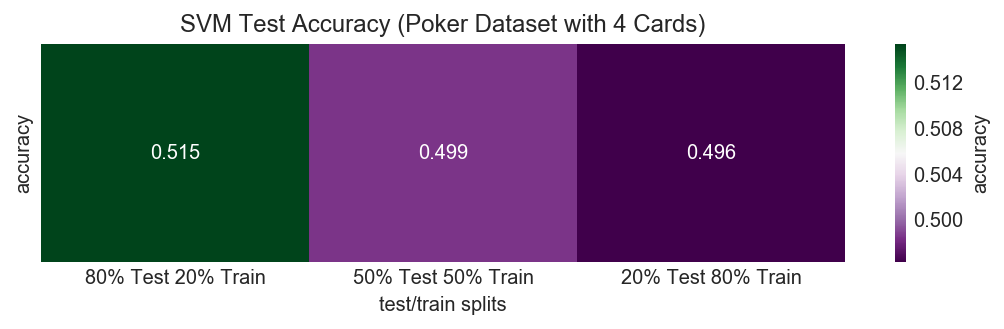

In [45]:
svm_Poker_4 = svm(X_train_val_Poker_1_Cards_4, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_4, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_4, Y_train_val_Poker_3, X_test_Poker_1_Cards_4, Y_test_Poker_1,\
            X_test_Poker_2_Cards_4, Y_test_Poker_2, X_test_Poker_3_Cards_4, Y_test_Poker_3,\
            'SVM Training Accuracy (Poker Dataset with 4 Cards)', \
            'SVM Validation Accuracy (Poker Dataset with 4 Cards)',\
            'SVM Test Accuracy (Poker Dataset with 4 Cards)')

In [46]:
#svm_overall_avg.append(np.mean(list(svm_Poker_4.values())))

temp = [] #hold split values
temp.append(svm_Poker_4['80/20 Split Train'])
temp.append(svm_Poker_4['80/20 Split Validation'])
temp.append(svm_Poker_4['80/20 Split Test'])
svm_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Poker_4['50/50 Split Train'])
temp.append(svm_Poker_4['50/50 Split Validation'])
temp.append(svm_Poker_4['50/50 Split Test'])
svm_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Poker_4['20/80 Split Train'])
temp.append(svm_Poker_4['20/80 Split Validation'])
temp.append(svm_Poker_4['20/80 Split Test'])
svm_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(svm_Poker_4['80/20 Split Test'])
temp.append(svm_Poker_4['50/50 Split Test'])
temp.append(svm_Poker_4['20/80 Split Test'])

svm_Poker_4_Average_Test = np.mean(np.array(temp))
svm_Poker_4_SD_Test = np.std(np.array(temp))
svm_Poker_4_Max_Test = np.max(np.array(temp))
svm_Poker_4_Min_Test = np.min(np.array(temp))

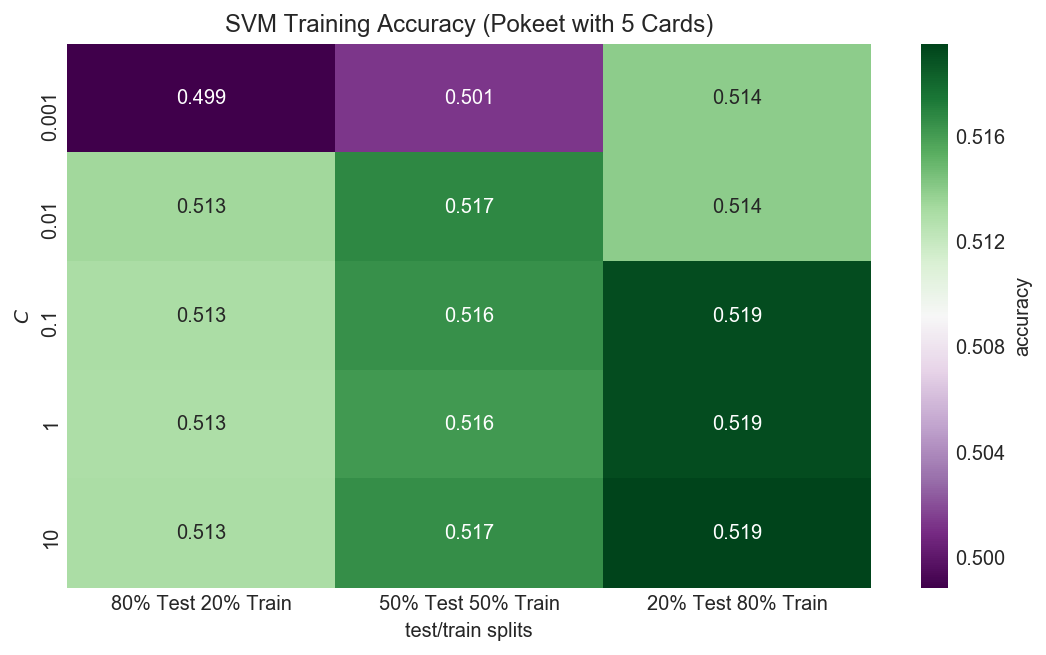

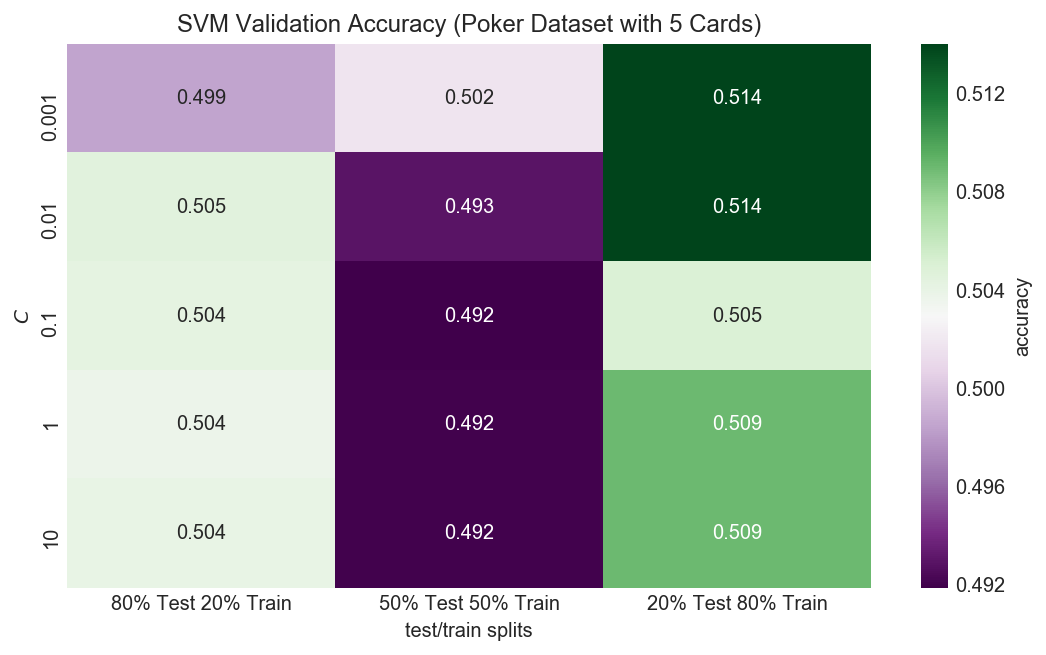

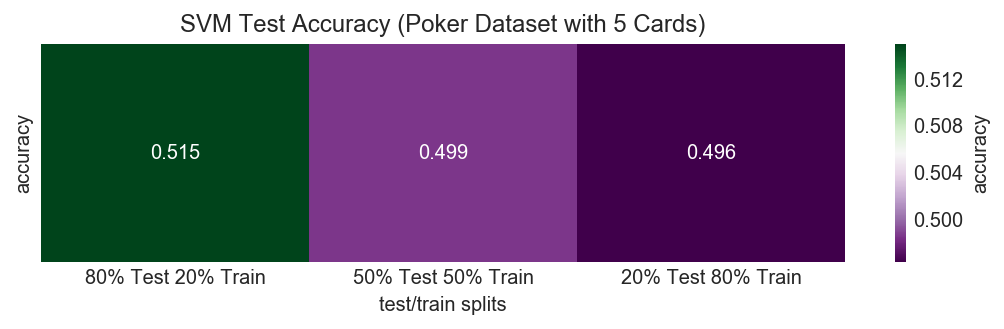

In [47]:
svm_Poker_5 = svm(X_train_val_Poker_1_Cards_5, Y_train_val_Poker_1, X_train_val_Poker_2_Cards_5, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_5, Y_train_val_Poker_3, X_test_Poker_1_Cards_5, Y_test_Poker_1,\
            X_test_Poker_2_Cards_5, Y_test_Poker_2, X_test_Poker_3_Cards_5, Y_test_Poker_3,\
            'SVM Training Accuracy (Pokeet with 5 Cards)', \
            'SVM Validation Accuracy (Poker Dataset with 5 Cards)',\
            'SVM Test Accuracy (Poker Dataset with 5 Cards)')

In [48]:
svm_overall_avg.append(np.mean(list(svm_Poker_5.values())))

temp = [] #hold split values
temp.append(svm_Poker_5['80/20 Split Train'])
temp.append(svm_Poker_5['80/20 Split Validation'])
temp.append(svm_Poker_5['80/20 Split Test'])
svm_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Poker_5['50/50 Split Train'])
temp.append(svm_Poker_5['50/50 Split Validation'])
temp.append(svm_Poker_5['50/50 Split Test'])
svm_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Poker_5['20/80 Split Train'])
temp.append(svm_Poker_5['20/80 Split Validation'])
temp.append(svm_Poker_5['20/80 Split Test'])
svm_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(svm_Poker_5['80/20 Split Test'])
temp.append(svm_Poker_5['50/50 Split Test'])
temp.append(svm_Poker_5['20/80 Split Test'])

svm_Poker_5_Average_Test = np.mean(np.array(temp))
svm_Poker_5_SD_Test = np.std(np.array(temp))
svm_Poker_5_Max_Test = np.max(np.array(temp))
svm_Poker_5_Min_Test = np.min(np.array(temp))

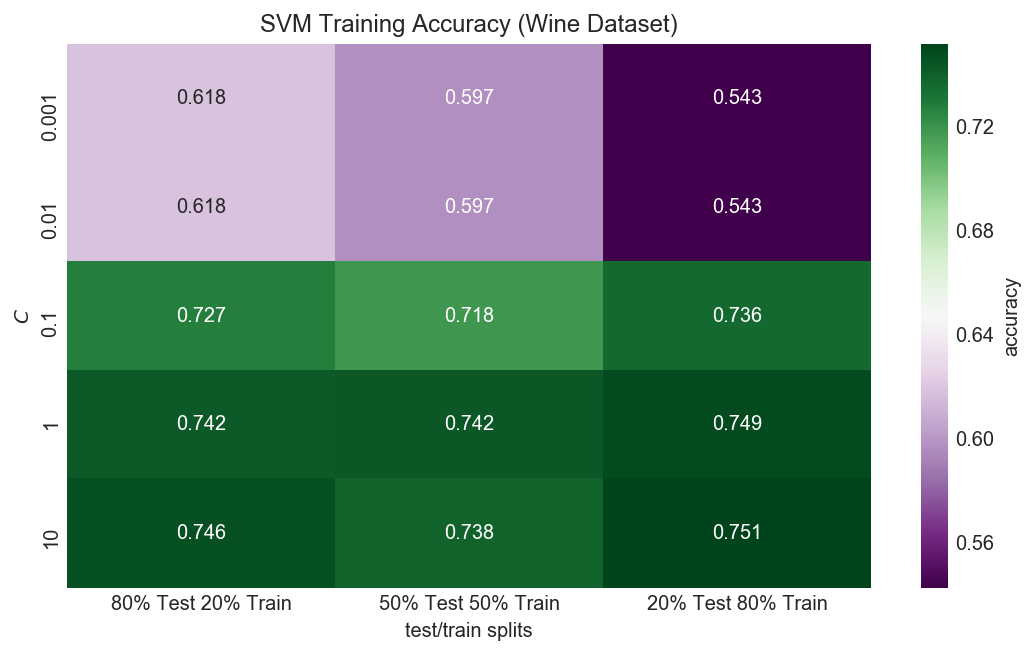

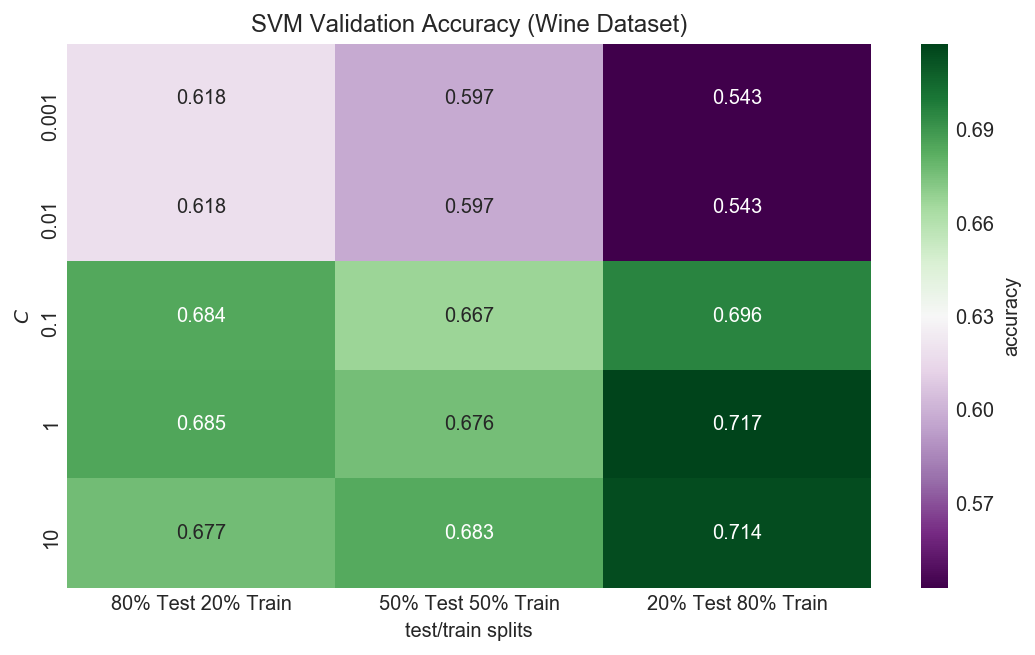

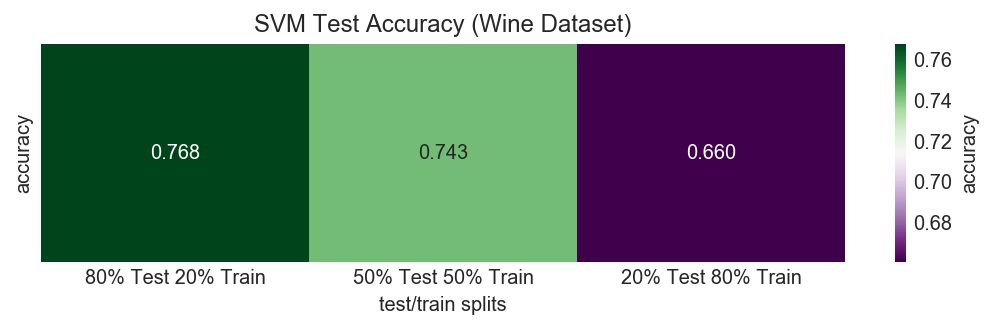

In [49]:
svm_Wine = svm(X_train_val_Wine_1, Y_train_val_Wine_1,X_train_val_Wine_2, Y_train_val_Wine_2,\
            X_train_val_Wine_3, Y_train_val_Wine_3,X_test_Wine_1, Y_test_Wine_1, \
            X_test_Wine_2, Y_test_Wine_2,X_test_Wine_3, Y_test_Wine_3,\
            'SVM Training Accuracy (Wine Dataset)', \
            'SVM Validation Accuracy (Wine Dataset)',\
            'SVM Test Accuracy (Wine Dataset)')

In [50]:
#svm_overall_avg.append(np.mean(list(svm_Wine.values())))

temp = [] #hold split values
temp.append(svm_Wine['80/20 Split Train'])
temp.append(svm_Wine['80/20 Split Validation'])
temp.append(svm_Wine['80/20 Split Test'])
svm_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Wine['50/50 Split Train'])
temp.append(svm_Wine['50/50 Split Validation'])
temp.append(svm_Wine['50/50 Split Test'])
svm_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(svm_Wine['20/80 Split Train'])
temp.append(svm_Wine['20/80 Split Validation'])
temp.append(svm_Wine['20/80 Split Test'])
svm_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(svm_Wine['80/20 Split Test'])
temp.append(svm_Wine['50/50 Split Test'])
temp.append(svm_Wine['20/80 Split Test'])

svm_Wine_Average_Test = np.mean(np.array(temp))
svm_Wine_SD_Test = np.std(np.array(temp))
svm_Wine_Max_Test = np.max(np.array(temp))
svm_Wine_Min_Test = np.min(np.array(temp))

#### Since SVM was taking more than hours to run just one split, I decided to take out the SVM model on the poker dataset

In [51]:
# poker_df = poker_df.sample(frac=1) 
# X_poker_train_MLP = poker_train_df.iloc[:15000, 0:-1]  
# Y_poker_train_MLP = poker_train_df.iloc[:15000, -1] 

# X_poker_test_MLP = poker_test_df.iloc[0:, 0:-1]  
# Y_poker_test_MLP = poker_test_df.iloc[0:, -1] 

# Y_poker_train_MLP = Y_poker_train_MLP.apply(lambda i: -1 if i <1 else 1)
# Y_poker_test_MLP = Y_poker_test_MLP.apply(lambda i: -1 if i <1 else 1)

# scaler = StandardScaler()
# scaler.fit(X_poker_test_MLP) 

# X_poker_train_MLP = scaler.transform(X_poker_train_MLP)
# X_poker_test_MLP = scaler.transform(X_poker_test_MLP)

In [52]:
# #courtesey of https://github.com/aditisrinivas97/Pokerman
# def svm_poker(X_train, Y_train, X_test, Y_test):

#     # Store the accuracies
#     accuracy = list()

#     # Store the predictions
#     predictions = list()

#     for trial in range(5):
#         classifier = SVC(kernel='linear')
#         result = classifier.fit(X_train, Y_train)
#         prediction = classifier.predict(X_test)
#         predictions.append(prediction)
#         curr_accuracy = accuracy_score(Y_test, prediction)
#         accuracy.append(curr_accuracy)
#     print(accuracy)
    
    

In [53]:
# svm_poker(X_poker_train_MLP, Y_poker_train_MLP, X_poker_test_MLP, Y_poker_test_MLP)

### Classifier 3: KNN

In [54]:
#knn with cross validation of 3
def knn(X_train_pred_1, Y_train_val_1, X_train_pred_2, Y_train_val_2, X_train_pred_3, Y_train_val_3,\
               X_test_1, Y_test_1, X_test_2, Y_test_2, X_test_3, Y_test_3, title1, title2, title3):
    # Initialize model.
    knn = KNeighborsClassifier()
    
    k_list = [1,2,3,4,5]
    test_train_split = ['80% Test 20% Train', '50% Test 50% Train', '20% Test 80% Train']
    
    grid_search_1 = GridSearchCV(knn, {'n_neighbors': k_list},  cv = 3, return_train_score= True, iid = False)
    grid_search_1.fit(X_train_pred_1, Y_train_val_1)
    
    grid_search_2 = GridSearchCV(knn, {'n_neighbors': k_list},  cv = 3, return_train_score= True, iid = False)
    grid_search_2.fit(X_train_pred_2, Y_train_val_2)
    
    grid_search_3 = GridSearchCV(knn, {'n_neighbors': k_list},  cv = 3, return_train_score= True, iid = False)
    grid_search_3.fit(X_train_pred_3, Y_train_val_3)

    
    #training accuracy
    train_acc_1 = grid_search_1.cv_results_['mean_train_score'].reshape(5,1)
    train_acc_2 = grid_search_2.cv_results_['mean_train_score'].reshape(5,1)
    train_acc_3 = grid_search_3.cv_results_['mean_train_score'].reshape(5,1)
    
    train_acc = np.array([[train_acc_1],[train_acc_2], [train_acc_3]]).T
    train_acc = train_acc.reshape(5,3)
    #print(train_acc)
    draw_heatmap_KNN(train_acc, title1, k_list, test_train_split)

    
    #validation accuracy
    val_acc_1 = grid_search_1.cv_results_['mean_test_score'].reshape(5,1)
    val_acc_2 = grid_search_2.cv_results_['mean_test_score'].reshape(5,1)
    val_acc_3 = grid_search_3.cv_results_['mean_test_score'].reshape(5,1)
    
    val_acc = np.array([[val_acc_1],[val_acc_2], [val_acc_3]]).T
    val_acc = val_acc.reshape(5,3)
    #print(train_acc)
    draw_heatmap_KNN(val_acc, title2, k_list, test_train_split)
    
    
    #test accuracy
    counter = 0
    pred_1 = grid_search_1.predict(X_test_1)
    for i in range(len(pred_1)):
        if pred_1[i] != Y_test_1.iloc[i]:
            counter += 1
    test_acc_1 = 1-(counter / len(pred_1))
    
    counter = 0
    pred_2 = grid_search_2.predict(X_test_2)
    for i in range(len(pred_2)):
        if pred_2[i] != Y_test_2.iloc[i]:
            counter += 1
    test_acc_2 = 1-(counter / len(pred_2))
    
    counter = 0
    pred_3 = grid_search_3.predict(X_test_3)
    for i in range(len(pred_3)):
        if pred_3[i] != Y_test_3.iloc[i]:
            counter += 1
    test_acc_3 = 1-(counter / len(pred_3))
    
    test_acc = np.array([[test_acc_1], [test_acc_2], [test_acc_3]]).reshape(1,3)
    draw_heatmap_KNN_test(test_acc, title3, test_train_split)
    
    knnDict = {}
    knnDict['80/20 Split Train'] = np.mean(train_acc_1)
    knnDict['50/50 Split Train'] = np.mean(train_acc_2)
    knnDict['20/80 Split Train'] = np.mean(train_acc_3)
    knnDict['80/20 Split Validation'] = np.mean(val_acc_1)
    knnDict['50/50 Split Validation'] = np.mean(val_acc_2)
    knnDict['20/80 Split Validation'] = np.mean(val_acc_3)
    knnDict['80/20 Split Test'] = test_acc_1
    knnDict['50/50 Split Test'] = test_acc_2
    knnDict['20/80 Split Test'] = test_acc_3
    return knnDict

#### Avg KNN Parameter Values

In [55]:
knn_Income_Average_Test = 0
knn_Income_SD_Test = 0
knn_Income_Max_Test = 0
knn_Income_Min_Test = 0

knn_Poker_1_Average_Test = 0
knn_Poker_1_SD_Test = 0
knn_Poker_1_Max_Test = 0
knn_Poker_1_Min_Test = 0

knn_Poker_2_Average_Test = 0
knn_Poker_2_SD_Test = 0
knn_Poker_2_Max_Test = 0
knn_Poker_2_Min_Test = 0

knn_Poker_3_Average_Test = 0
knn_Poker_3_SD_Test = 0
knn_Poker_3_Max_Test = 0
knn_Poker_3_Min_Test = 0

knn_Poker_5_Average_Test = 0
knn_Poker_5_SD_Test = 0
knn_Poker_5_Max_Test = 0
knn_Poker_5_Min_Test = 0

knn_Poker_Overall_Average_Test = 0
knn_Poker_Overall_SD_Test = 0
knn_Poker_Overall_Max_Test = 0
knn_Poker_Overall_Min_Test = 0

knn_Wine_Average_Test = 0
knn_Wine_SD = 0
knn_Wine_Max_Test = 0
knn_Wine_Min_Test = 0

knn_overall_avg = []
knn_80_20_split_avg = []
knn_50_50_split_avg = []
knn_20_80_split_avg = []

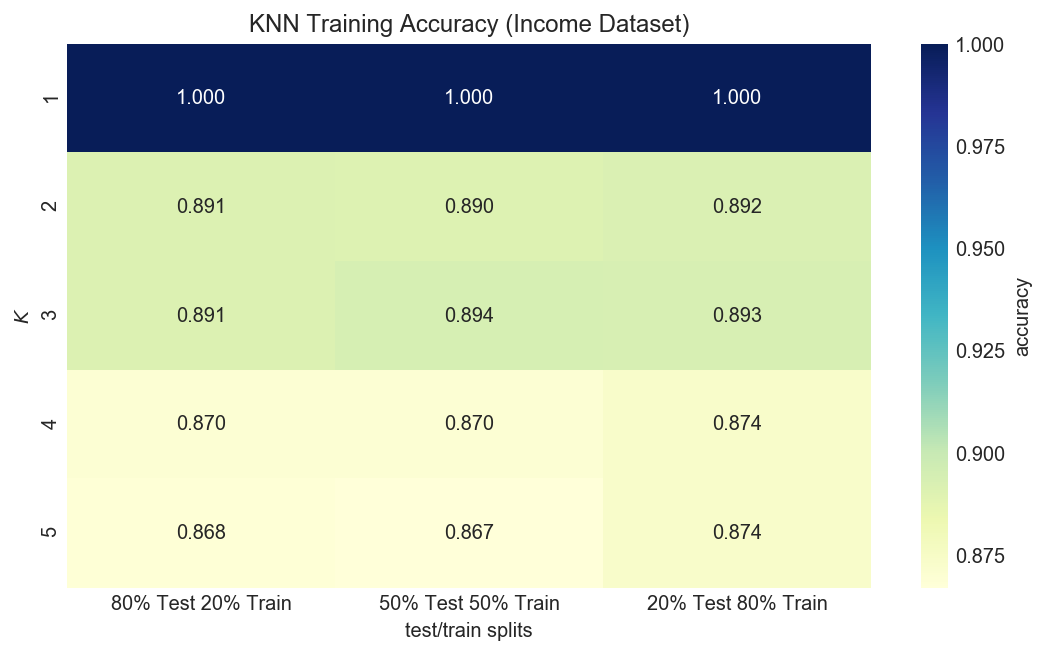

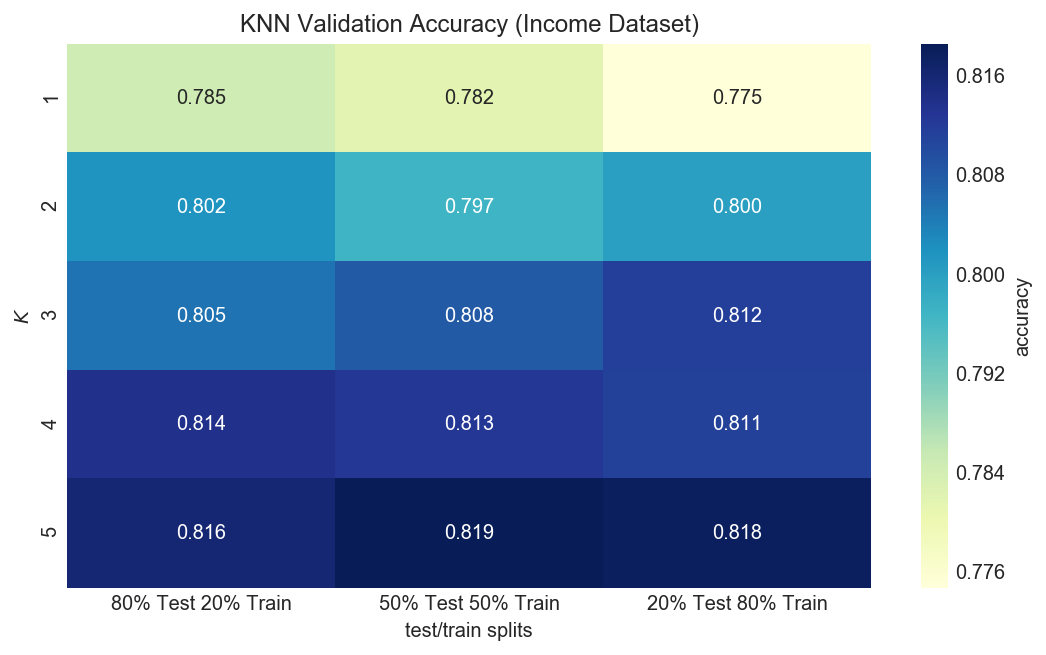

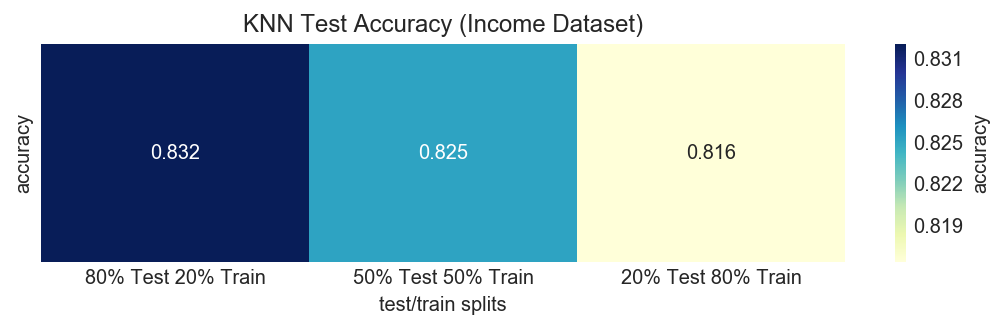

In [57]:
knn_Income = knn(X_train_val_Income_1, Y_train_val_Income_1,X_train_val_Income_2, Y_train_val_Income_2,\
            X_train_val_Income_3, Y_train_val_Income_3, X_test_Income_1, Y_test_Income_1,\
            X_test_Income_2, Y_test_Income_2, X_test_Income_3, Y_test_Income_3,\
            'KNN Training Accuracy (Income Dataset)', \
            'KNN Validation Accuracy (Income Dataset)',\
            'KNN Test Accuracy (Income Dataset)')

In [58]:
knn_overall_avg.append(np.mean(list(knn_Income.values())))

temp = [] #hold split values
temp.append(knn_Income['80/20 Split Train'])
temp.append(knn_Income['80/20 Split Validation'])
temp.append(knn_Income['80/20 Split Test'])
knn_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Income['50/50 Split Train'])
temp.append(knn_Income['50/50 Split Validation'])
temp.append(knn_Income['50/50 Split Test'])
knn_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Income['20/80 Split Train'])
temp.append(knn_Income['20/80 Split Validation'])
temp.append(knn_Income['20/80 Split Test'])
knn_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(knn_Income['80/20 Split Test'])
temp.append(knn_Income['50/50 Split Test'])
temp.append(knn_Income['20/80 Split Test'])

knn_Income_Average_Test = np.mean(np.array(temp))
knn_Income_SD_Test = np.std(np.array(temp))
knn_Income_Max_Test = np.max(np.array(temp))
knn_Income_Min_Test = np.min(np.array(temp))

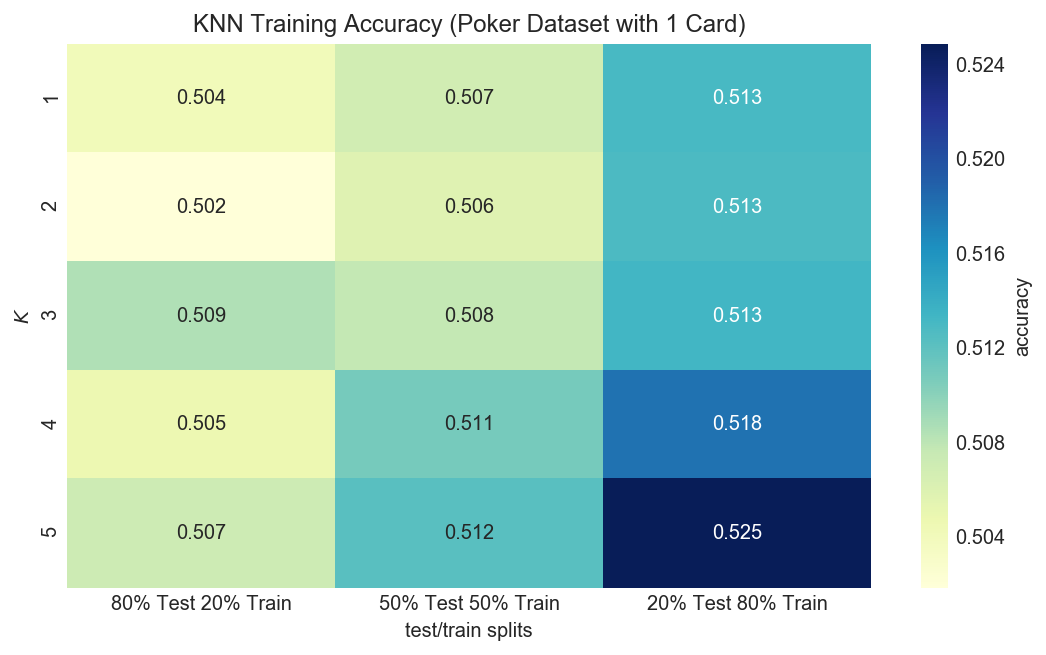

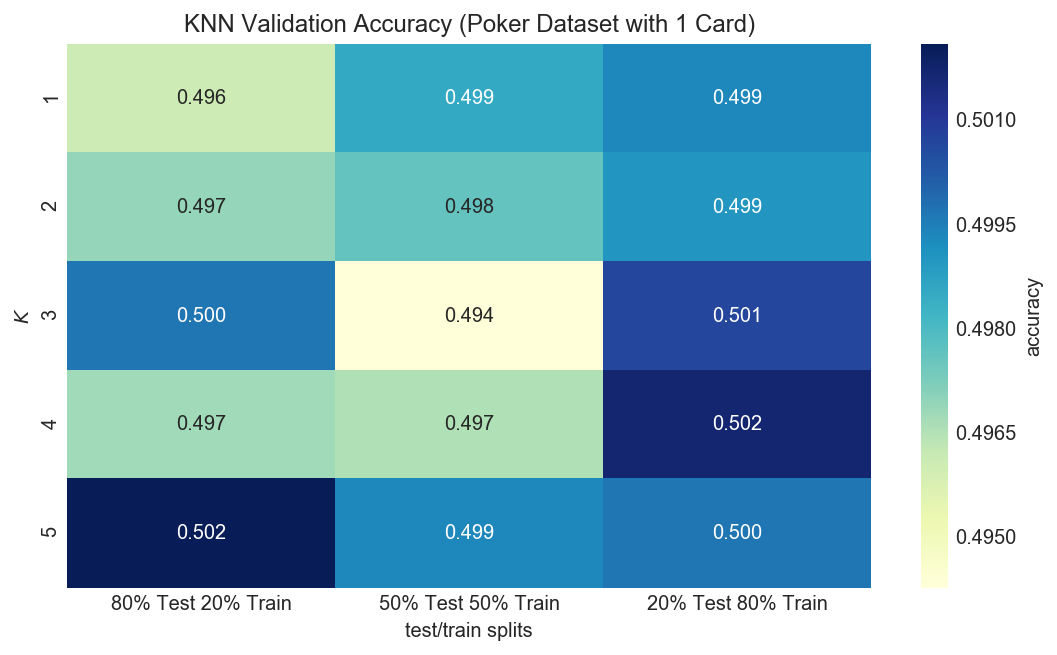

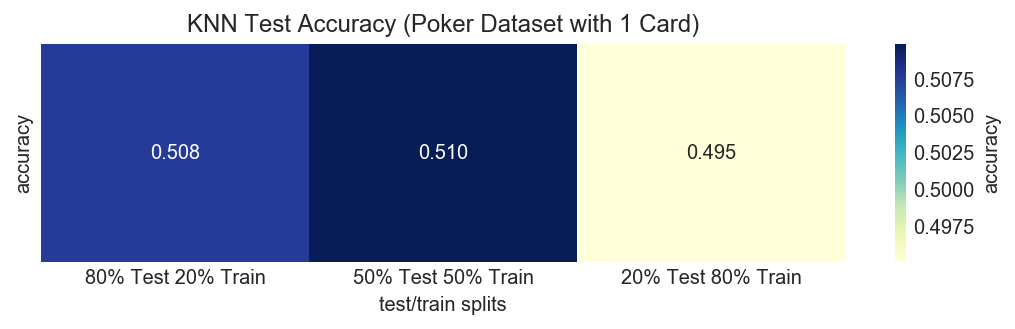

In [59]:
knn_Poker_1 = knn(X_train_val_Poker_1_Cards_1, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_1, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_1, Y_train_val_Poker_3,X_test_Poker_1_Cards_1, Y_test_Poker_1,\
            X_test_Poker_2_Cards_1, Y_test_Poker_2, X_test_Poker_3_Cards_1, Y_test_Poker_3,\
            'KNN Training Accuracy (Poker Dataset with 1 Card)', \
            'KNN Validation Accuracy (Poker Dataset with 1 Card)',\
            'KNN Test Accuracy (Poker Dataset with 1 Card)')

In [60]:
#knn_overall_avg.append(np.mean(list(knn_Poker_1.values())))

temp = [] #hold split values
temp.append(knn_Poker_1['80/20 Split Train'])
temp.append(knn_Poker_1['80/20 Split Validation'])
temp.append(knn_Poker_1['80/20 Split Test'])
knn_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Poker_1['50/50 Split Train'])
temp.append(knn_Poker_1['50/50 Split Validation'])
temp.append(knn_Poker_1['50/50 Split Test'])
knn_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Poker_1['20/80 Split Train'])
temp.append(knn_Poker_1['20/80 Split Validation'])
temp.append(knn_Poker_1['20/80 Split Test'])
knn_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(knn_Poker_1['80/20 Split Test'])
temp.append(knn_Poker_1['50/50 Split Test'])
temp.append(knn_Poker_1['20/80 Split Test'])

knn_Poker_1_Average_Test = np.mean(np.array(temp))
knn_Poker_1_SD_Test = np.std(np.array(temp))
knn_Poker_1_Max_Test = np.max(np.array(temp))
knn_Poker_1_Min_Test = np.min(np.array(temp))

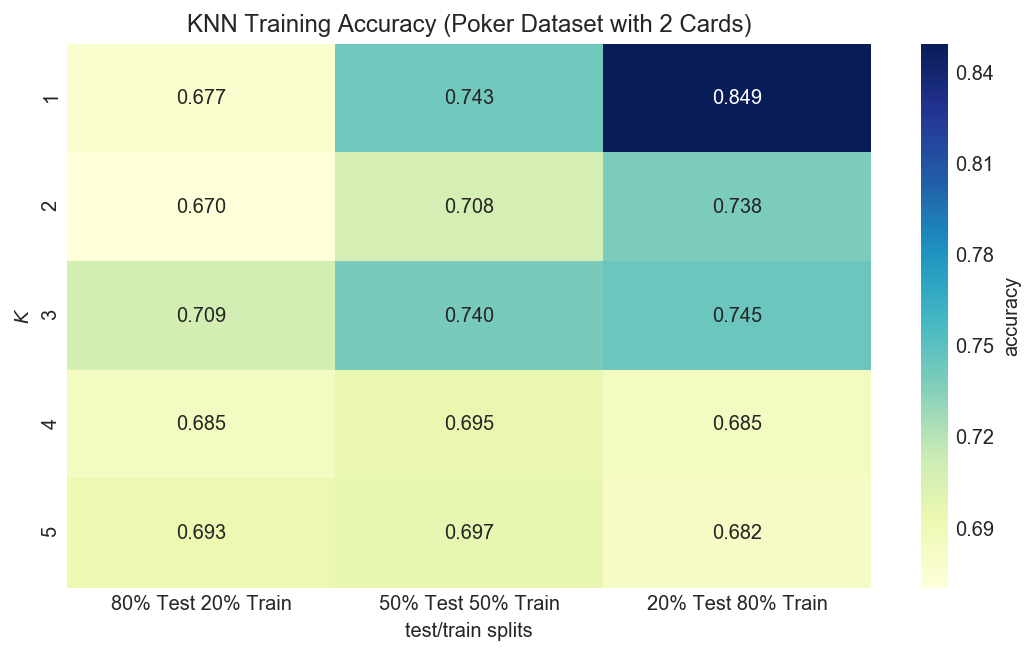

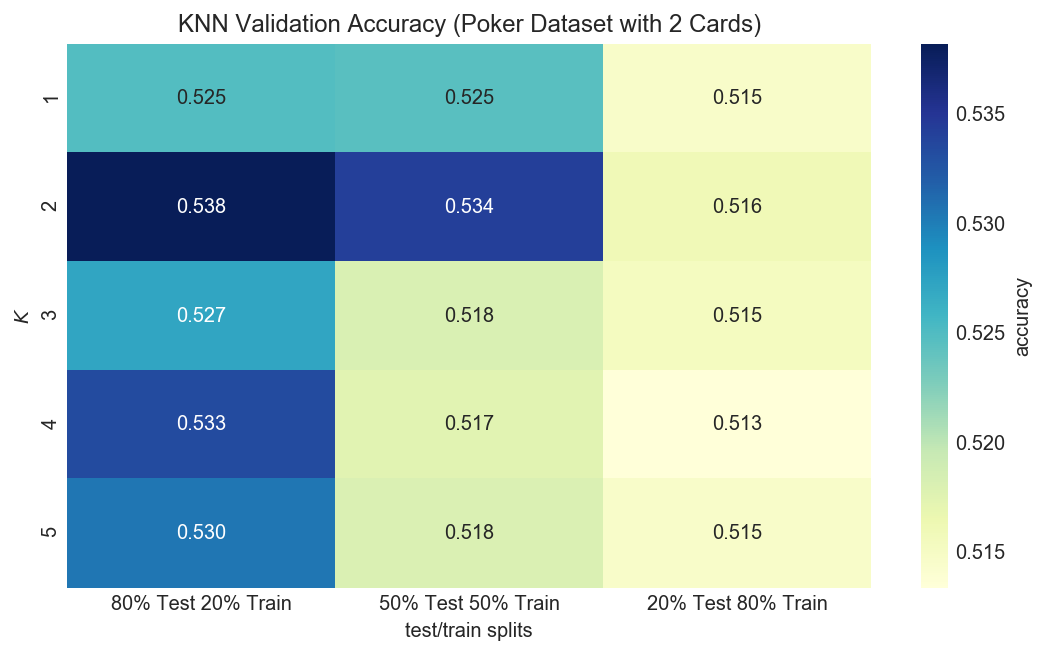

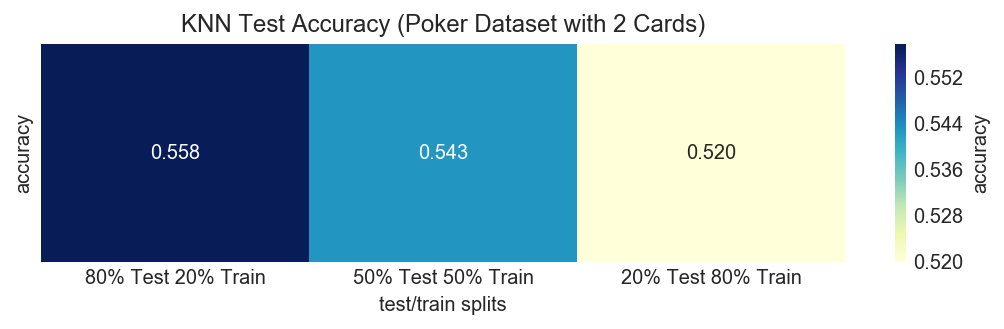

In [61]:
knn_Poker_2 = knn(X_train_val_Poker_1_Cards_2, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_2, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_2, Y_train_val_Poker_3,X_test_Poker_1_Cards_2, Y_test_Poker_1,\
            X_test_Poker_2_Cards_2, Y_test_Poker_2, X_test_Poker_3_Cards_2, Y_test_Poker_3,\
            'KNN Training Accuracy (Poker Dataset with 2 Cards)', \
            'KNN Validation Accuracy (Poker Dataset with 2 Cards)',\
            'KNN Test Accuracy (Poker Dataset with 2 Cards)')

In [62]:
#knn_overall_avg.append(np.mean(list(knn_Poker_2.values())))

temp = [] #hold split values
temp.append(knn_Poker_2['80/20 Split Train'])
temp.append(knn_Poker_2['80/20 Split Validation'])
temp.append(knn_Poker_2['80/20 Split Test'])
knn_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Poker_2['50/50 Split Train'])
temp.append(knn_Poker_2['50/50 Split Validation'])
temp.append(knn_Poker_2['50/50 Split Test'])
knn_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Poker_2['20/80 Split Train'])
temp.append(knn_Poker_2['20/80 Split Validation'])
temp.append(knn_Poker_2['20/80 Split Test'])
knn_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(knn_Poker_2['80/20 Split Test'])
temp.append(knn_Poker_2['50/50 Split Test'])
temp.append(knn_Poker_2['20/80 Split Test'])

knn_Poker_2_Average_Test = np.mean(np.array(temp))
knn_Poker_2_SD_Test = np.std(np.array(temp))
knn_Poker_2_Max_Test = np.max(np.array(temp))
knn_Poker_2_Min_Test = np.min(np.array(temp))

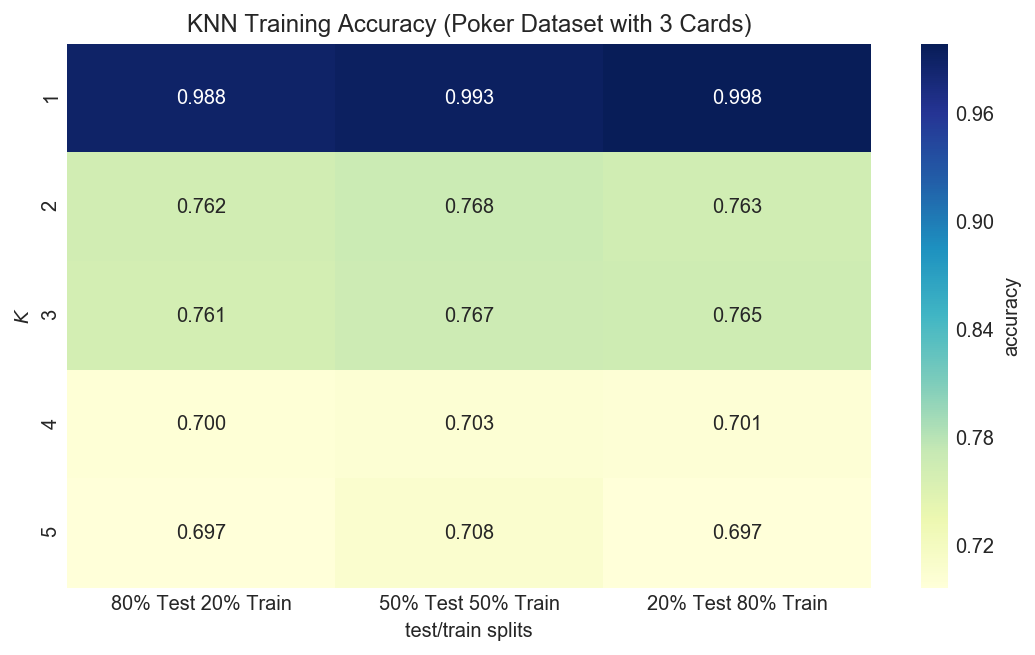

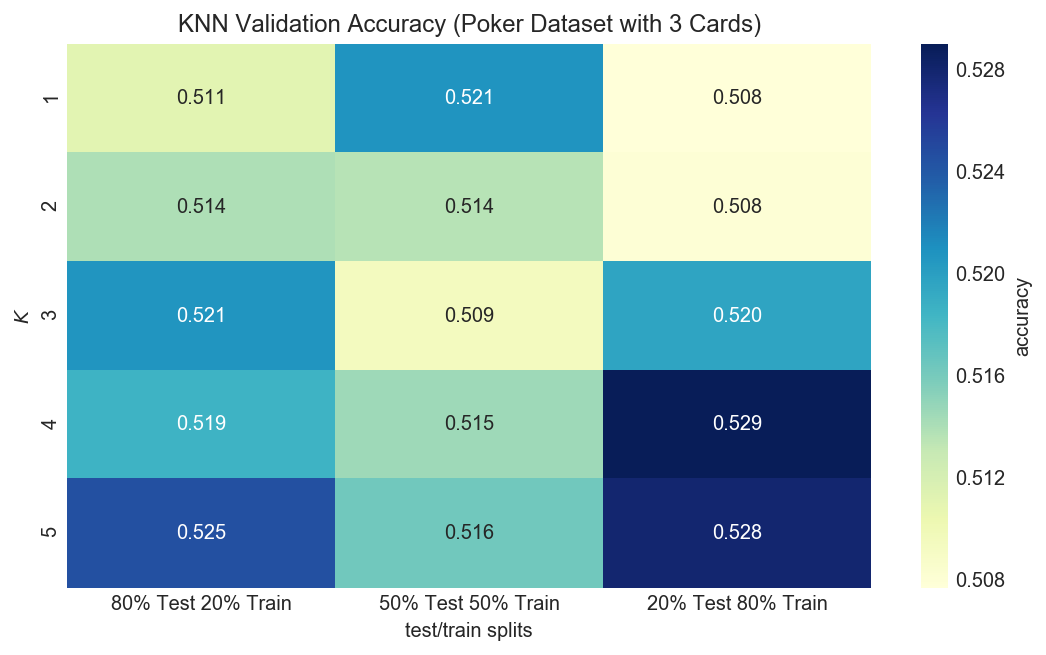

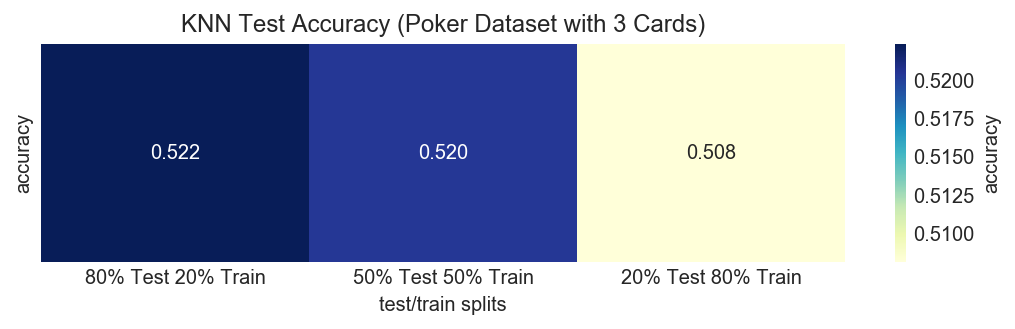

In [63]:
knn_Poker_3 = knn(X_train_val_Poker_1_Cards_3, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_3, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_3, Y_train_val_Poker_3,X_test_Poker_1_Cards_3, Y_test_Poker_1,\
            X_test_Poker_2_Cards_3, Y_test_Poker_2, X_test_Poker_3_Cards_3, Y_test_Poker_3,\
            'KNN Training Accuracy (Poker Dataset with 3 Cards)', \
            'KNN Validation Accuracy (Poker Dataset with 3 Cards)',\
            'KNN Test Accuracy (Poker Dataset with 3 Cards)')

In [64]:
#knn_overall_avg.append(np.mean(list(knn_Poker_3.values())))

temp = [] #hold split values
temp.append(knn_Poker_3['80/20 Split Train'])
temp.append(knn_Poker_3['80/20 Split Validation'])
temp.append(knn_Poker_3['80/20 Split Test'])
knn_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Poker_3['50/50 Split Train'])
temp.append(knn_Poker_3['50/50 Split Validation'])
temp.append(knn_Poker_3['50/50 Split Test'])
knn_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Poker_3['20/80 Split Train'])
temp.append(knn_Poker_3['20/80 Split Validation'])
temp.append(knn_Poker_3['20/80 Split Test'])
knn_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(knn_Poker_3['80/20 Split Test'])
temp.append(knn_Poker_3['50/50 Split Test'])
temp.append(knn_Poker_3['20/80 Split Test'])

knn_Poker_3_Average_Test = np.mean(np.array(temp))
knn_Poker_3_SD_Test = np.std(np.array(temp))
knn_Poker_3_Max_Test = np.max(np.array(temp))
knn_Poker_3_Min_Test = np.min(np.array(temp))

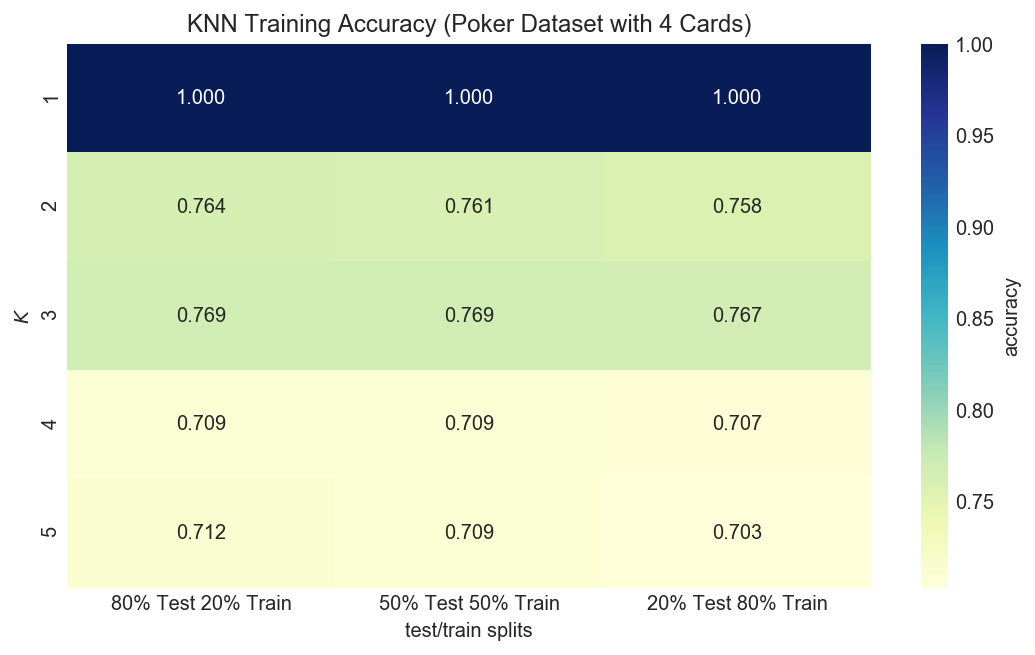

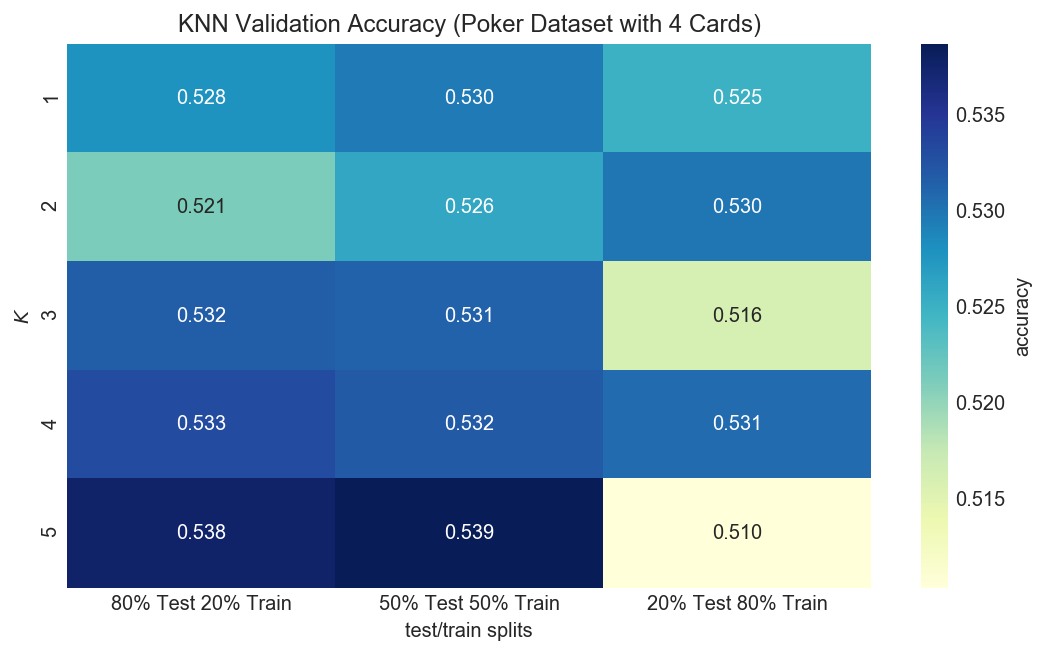

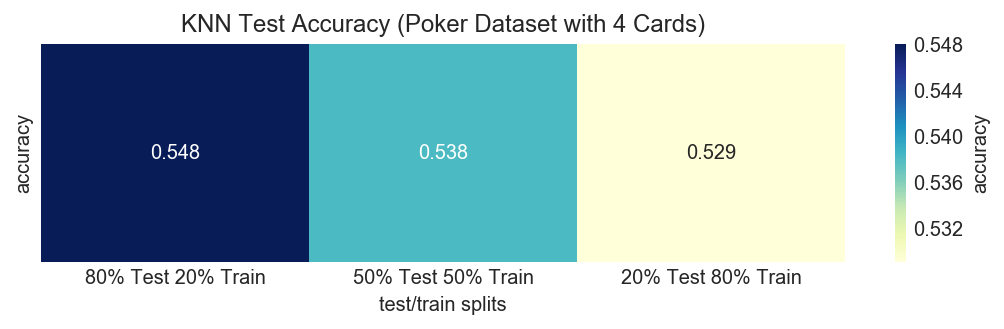

In [65]:
knn_Poker_4 = knn(X_train_val_Poker_1_Cards_4, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_4, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_4, Y_train_val_Poker_3,X_test_Poker_1_Cards_4, Y_test_Poker_1,\
            X_test_Poker_2_Cards_4, Y_test_Poker_2, X_test_Poker_3_Cards_4, Y_test_Poker_3,\
            'KNN Training Accuracy (Poker Dataset with 4 Cards)', \
            'KNN Validation Accuracy (Poker Dataset with 4 Cards)',\
            'KNN Test Accuracy (Poker Dataset with 4 Cards)')

In [66]:
#knn_overall_avg.append(np.mean(list(knn_Poker_4.values())))

temp = [] #hold split values
temp.append(knn_Poker_4['80/20 Split Train'])
temp.append(knn_Poker_4['80/20 Split Validation'])
temp.append(knn_Poker_4['80/20 Split Test'])
knn_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Poker_4['50/50 Split Train'])
temp.append(knn_Poker_4['50/50 Split Validation'])
temp.append(knn_Poker_4['50/50 Split Test'])
knn_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Poker_4['20/80 Split Train'])
temp.append(knn_Poker_4['20/80 Split Validation'])
temp.append(knn_Poker_4['20/80 Split Test'])
knn_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(knn_Poker_4['80/20 Split Test'])
temp.append(knn_Poker_4['50/50 Split Test'])
temp.append(knn_Poker_4['20/80 Split Test'])

knn_Poker_4_Average_Test = np.mean(np.array(temp))
knn_Poker_4_SD_Test = np.std(np.array(temp))
knn_Poker_4_Max_Test = np.max(np.array(temp))
knn_Poker_4_Min_Test = np.min(np.array(temp))

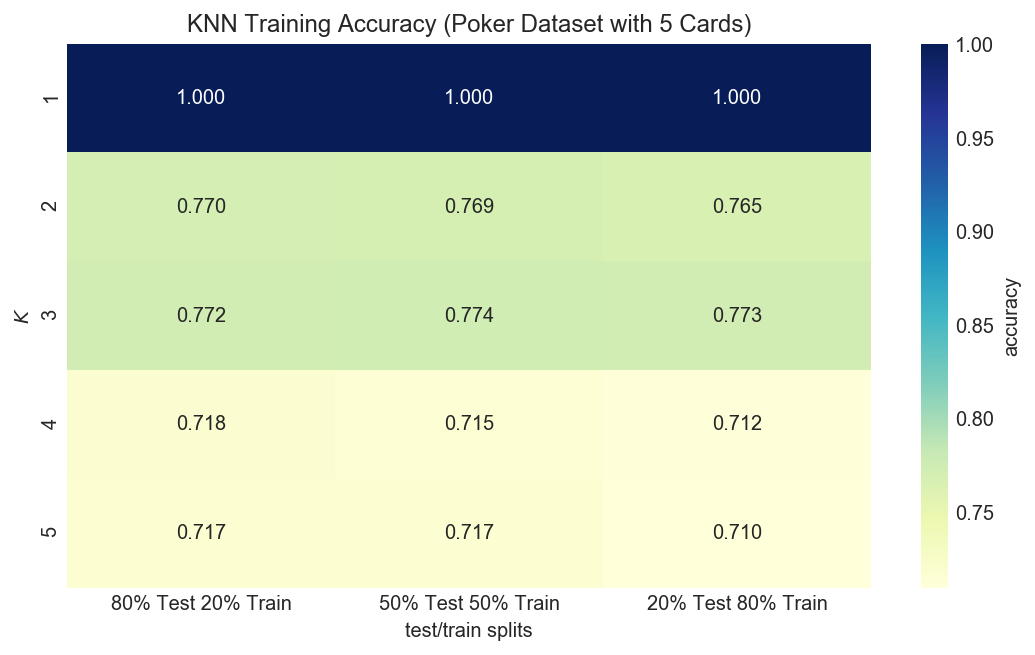

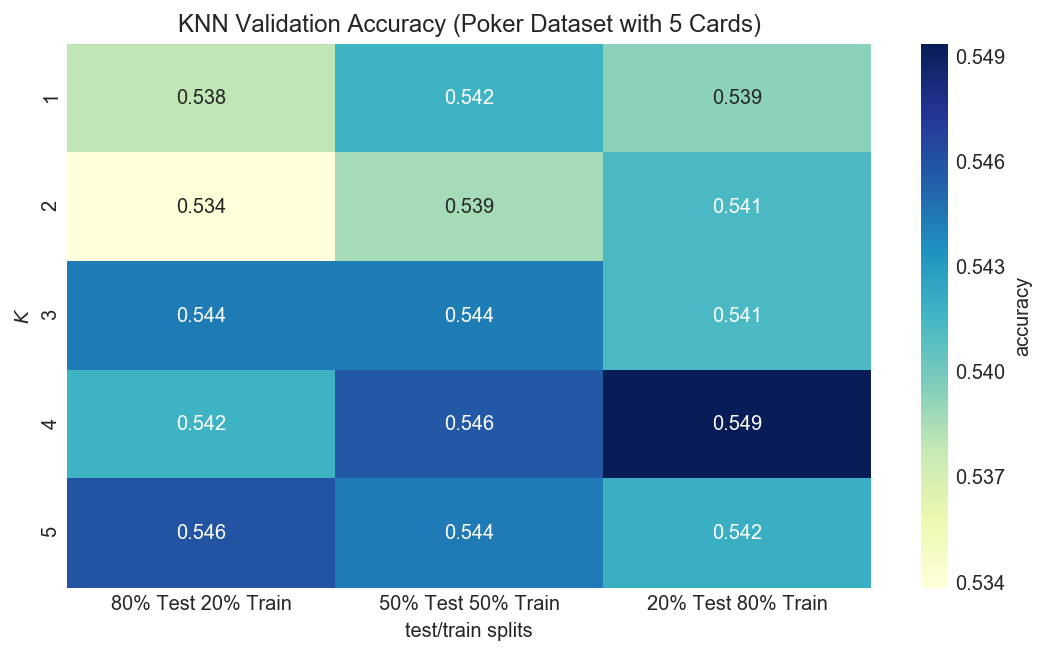

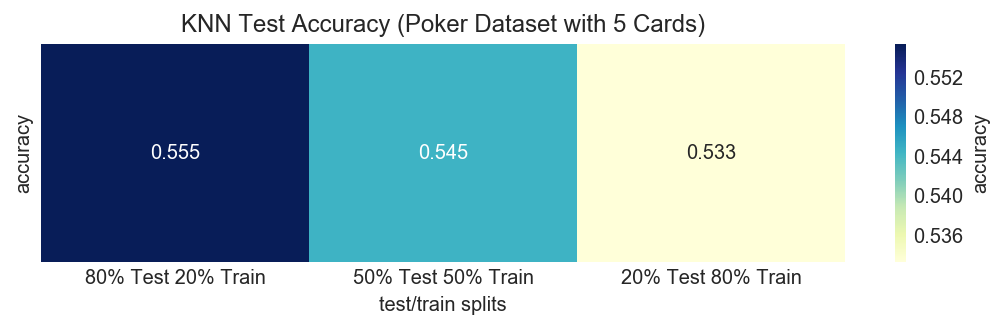

In [67]:
knn_Poker_5 = knn(X_train_val_Poker_1_Cards_5, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_5, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_5, Y_train_val_Poker_3,X_test_Poker_1_Cards_5, Y_test_Poker_1,\
            X_test_Poker_2_Cards_5, Y_test_Poker_2, X_test_Poker_3_Cards_5, Y_test_Poker_3,\
            'KNN Training Accuracy (Poker Dataset with 5 Cards)', \
            'KNN Validation Accuracy (Poker Dataset with 5 Cards)',\
            'KNN Test Accuracy (Poker Dataset with 5 Cards)')

In [68]:
knn_overall_avg.append(np.mean(list(knn_Poker_5.values())))

temp = [] #hold split values
temp.append(knn_Poker_5['80/20 Split Train'])
temp.append(knn_Poker_5['80/20 Split Validation'])
temp.append(knn_Poker_5['80/20 Split Test'])
knn_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Poker_5['50/50 Split Train'])
temp.append(knn_Poker_5['50/50 Split Validation'])
temp.append(knn_Poker_5['50/50 Split Test'])
knn_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Poker_5['20/80 Split Train'])
temp.append(knn_Poker_5['20/80 Split Validation'])
temp.append(knn_Poker_5['20/80 Split Test'])
knn_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(knn_Poker_5['80/20 Split Test'])
temp.append(knn_Poker_5['50/50 Split Test'])
temp.append(knn_Poker_5['20/80 Split Test'])

knn_Poker_5_Average_Test = np.mean(np.array(temp))
knn_Poker_5_SD_Test = np.std(np.array(temp))
knn_Poker_5_Max_Test = np.max(np.array(temp))
knn_Poker_5_Min_Test = np.min(np.array(temp))

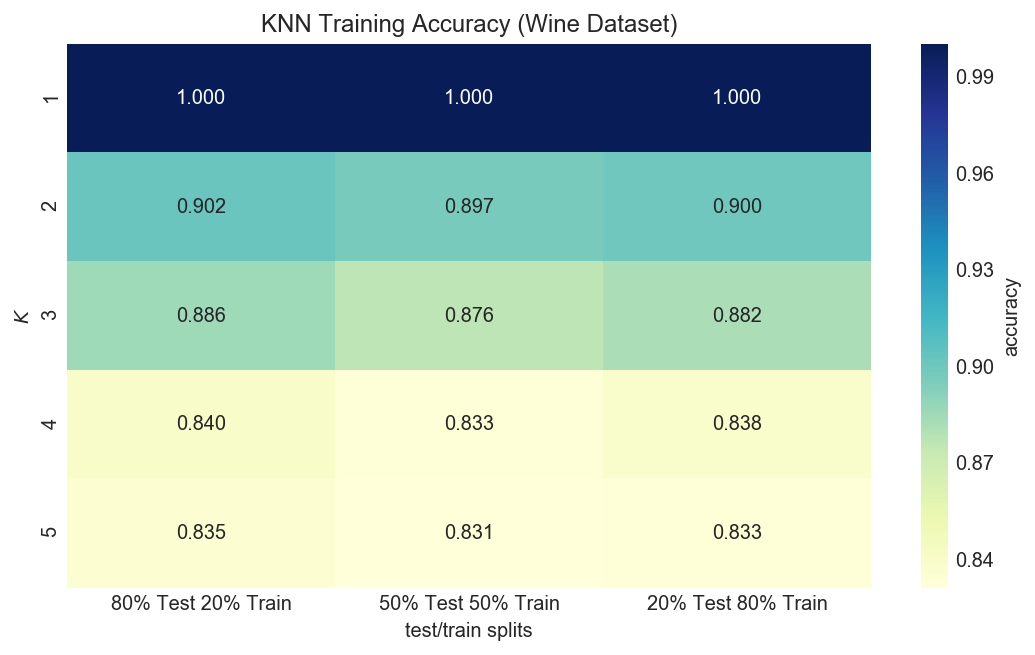

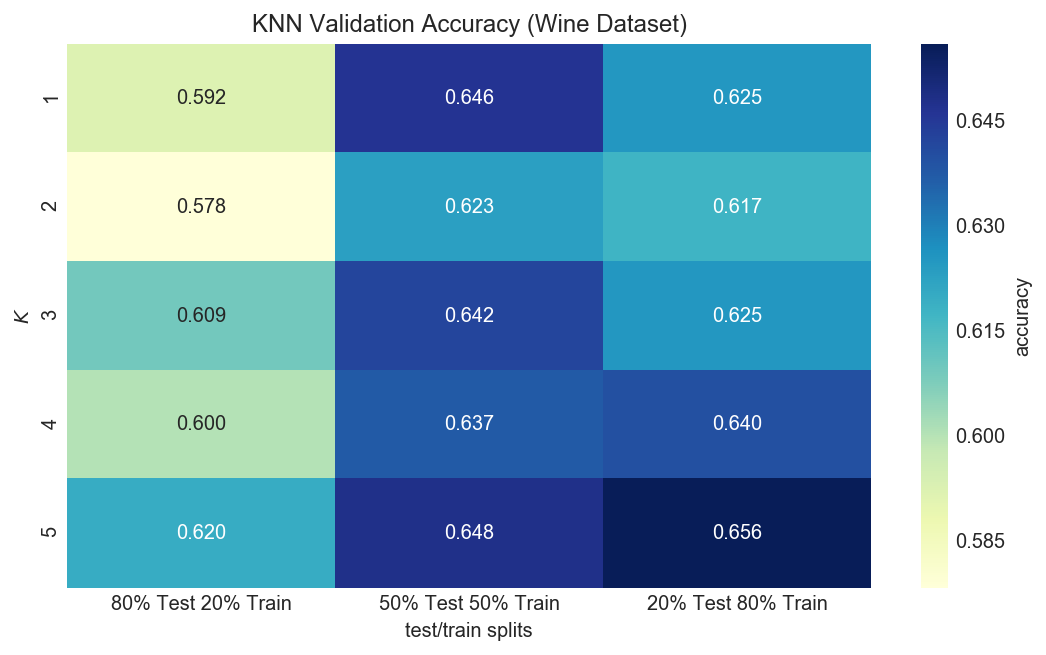

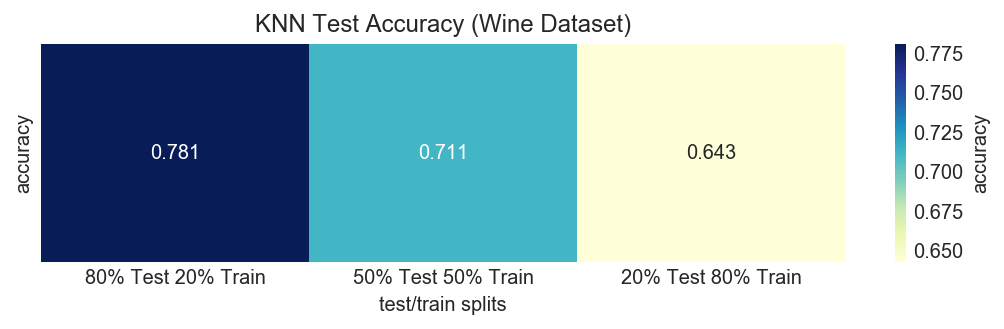

In [69]:
knn_Wine = knn(X_train_val_Wine_1, Y_train_val_Wine_1,X_train_val_Wine_2, Y_train_val_Wine_2,\
            X_train_val_Wine_3, Y_train_val_Wine_3,X_test_Wine_1, Y_test_Wine_1, \
            X_test_Wine_2, Y_test_Wine_2,X_test_Wine_3, Y_test_Wine_3,\
            'KNN Training Accuracy (Wine Dataset)', \
            'KNN Validation Accuracy (Wine Dataset)',\
            'KNN Test Accuracy (Wine Dataset)')

In [70]:
knn_overall_avg.append(np.mean(list(knn_Wine.values())))

temp = [] #hold split values
temp.append(knn_Wine['80/20 Split Train'])
temp.append(knn_Wine['80/20 Split Validation'])
temp.append(knn_Wine['80/20 Split Test'])
knn_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Wine['50/50 Split Train'])
temp.append(knn_Wine['50/50 Split Validation'])
temp.append(knn_Wine['50/50 Split Test'])
knn_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(knn_Wine['20/80 Split Train'])
temp.append(knn_Wine['20/80 Split Validation'])
temp.append(knn_Wine['20/80 Split Test'])
knn_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(knn_Wine['80/20 Split Test'])
temp.append(knn_Wine['50/50 Split Test'])
temp.append(knn_Wine['20/80 Split Test'])

knn_Wine_Average_Test = np.mean(np.array(temp))
knn_Wine_SD_Test = np.std(np.array(temp))
knn_Wine_Max_Test = np.max(np.array(temp))
knn_Wine_Min_Test = np.min(np.array(temp))

### Classifier 4: Multi-layer Perceptron

In [71]:
#multi layer perceptron with cross validation of 3
def mlp(X_train_pred_1, Y_train_val_1, X_train_pred_2, Y_train_val_2, X_train_pred_3, Y_train_val_3,\
               X_test_1, Y_test_1, X_test_2, Y_test_2, X_test_3, Y_test_3, title1, title2, title3):
    # Initialize model.
    mlp = MLPClassifier(learning_rate_init = 0.02, max_iter = 2000)
    
    activation_list = ['identity', 'logistic', 'tanh', 'relu']
    test_train_split = ['80% Test 20% Train', '50% Test 50% Train', '20% Test 80% Train']
    
    grid_search_1 = GridSearchCV(mlp, {'activation': activation_list},  cv = 3, return_train_score= True, iid = False)
    grid_search_1.fit(X_train_pred_1, Y_train_val_1)
    
    grid_search_2 = GridSearchCV(mlp, {'activation': activation_list},  cv = 3, return_train_score= True, iid = False)
    grid_search_2.fit(X_train_pred_2, Y_train_val_2)
    
    grid_search_3 = GridSearchCV(mlp, {'activation': activation_list},  cv = 3, return_train_score= True, iid = False)
    grid_search_3.fit(X_train_pred_3, Y_train_val_3)

    
    #training accuracy
    train_acc_1 = grid_search_1.cv_results_['mean_train_score'].reshape(4,1)
    train_acc_2 = grid_search_2.cv_results_['mean_train_score'].reshape(4,1)
    train_acc_3 = grid_search_3.cv_results_['mean_train_score'].reshape(4,1)
    
    train_acc = np.array([[train_acc_1],[train_acc_2], [train_acc_3]]).T
    train_acc = train_acc.reshape(4,3)
    #print(train_acc)
    draw_heatmap_MLP(train_acc, title1, activation_list, test_train_split)

    
    #validation accuracy
    val_acc_1 = grid_search_1.cv_results_['mean_test_score'].reshape(4,1)
    val_acc_2 = grid_search_2.cv_results_['mean_test_score'].reshape(4,1)
    val_acc_3 = grid_search_3.cv_results_['mean_test_score'].reshape(4,1)
    
    val_acc = np.array([[val_acc_1],[val_acc_2], [val_acc_3]]).T
    val_acc = val_acc.reshape(4,3)
    #print(train_acc)
    draw_heatmap_MLP(val_acc, title2, activation_list, test_train_split)
    
    
    #test accuracy
    counter = 0
    pred_1 = grid_search_1.predict(X_test_1)
    for i in range(len(pred_1)):
        if pred_1[i] != Y_test_1.iloc[i]:
            counter += 1
    test_acc_1 = 1-(counter / len(pred_1))
    
    counter = 0
    pred_2 = grid_search_2.predict(X_test_2)
    for i in range(len(pred_2)):
        if pred_2[i] != Y_test_2.iloc[i]:
            counter += 1
    test_acc_2 = 1-(counter / len(pred_2))
    
    counter = 0
    pred_3 = grid_search_3.predict(X_test_3)
    for i in range(len(pred_3)):
        if pred_3[i] != Y_test_3.iloc[i]:
            counter += 1
    test_acc_3 = 1-(counter / len(pred_3))
    
    test_acc = np.array([[test_acc_1], [test_acc_2], [test_acc_3]]).reshape(1,3)
    draw_heatmap_MLP_test(test_acc, title3, test_train_split)
    
    mlpDict = {}
    mlpDict['80/20 Split Train'] = np.mean(train_acc_1)
    mlpDict['50/50 Split Train'] = np.mean(train_acc_2)
    mlpDict['20/80 Split Train'] = np.mean(train_acc_3)
    mlpDict['80/20 Split Validation'] = np.mean(val_acc_1)
    mlpDict['50/50 Split Validation'] = np.mean(val_acc_2)
    mlpDict['20/80 Split Validation'] = np.mean(val_acc_3)
    mlpDict['80/20 Split Test'] = test_acc_1
    mlpDict['50/50 Split Test'] = test_acc_2
    mlpDict['20/80 Split Test'] = test_acc_3
    return mlpDict

#### Average Multi-Layered Perceptron Parameter Values

In [72]:
mlp_Income_Average_Test = 0
mlp_Income_SD_Test = 0
mlp_Income_Max_Test = 0
mlp_Income_Min_Test = 0

mlp_Poker_1_Average_Test = 0
mlp_Poker_1_SD_Test = 0
mlp_Poker_1_Max_Test = 0
mlp_Poker_1_Min_Test = 0

mlp_Poker_2_Average_Test = 0
mlp_Poker_2_SD_Test = 0
mlp_Poker_2_Max_Test = 0
mlp_Poker_2_Min_Test = 0

mlp_Poker_3_Average_Test = 0
mlp_Poker_3_SD_Test = 0
mlp_Poker_3_Max_Test = 0
mlp_Poker_3_Min_Test = 0

mlp_Poker_5_Average_Test = 0
mlp_Poker_5_SD_Test = 0
mlp_Poker_5_Max_Test = 0
mlp_Poker_5_Min_Test = 0

mlp_Poker_Overall_Average_Test = 0
mlp_Poker_Overall_SD_Test = 0
mlp_Poker_Overall_Max_Test = 0
mlp_Poker_Overall_Min_Test = 0

mlp_Wine_Average_Test =0
mlp_Wine_SD = 0
mlp_Wine_Max_Test = 0
mlp_Wine_Min_Test = 0

mlp_overall_avg = []
mlp_80_20_split_avg = []
mlp_50_50_split_avg = []
mlp_20_80_split_avg = []

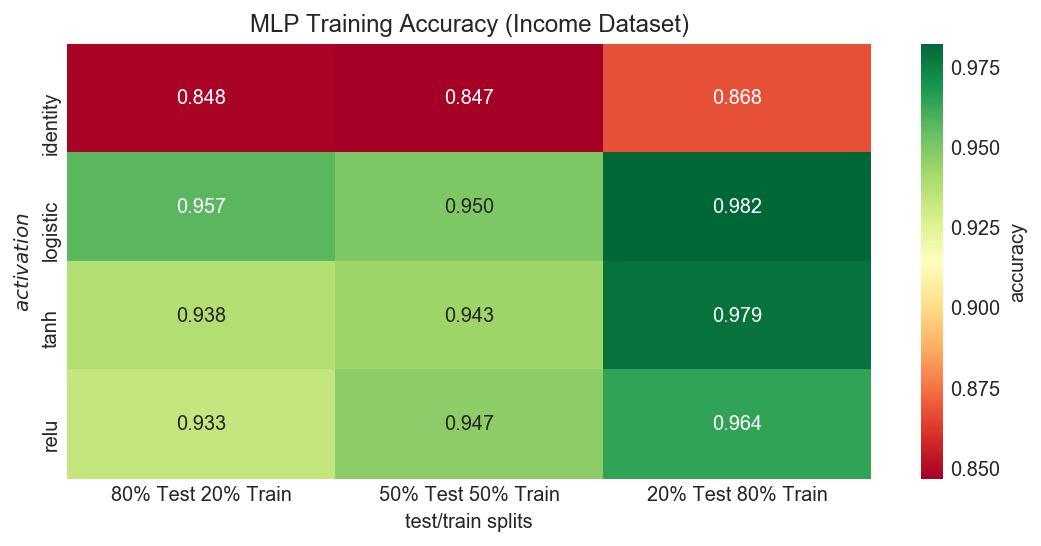

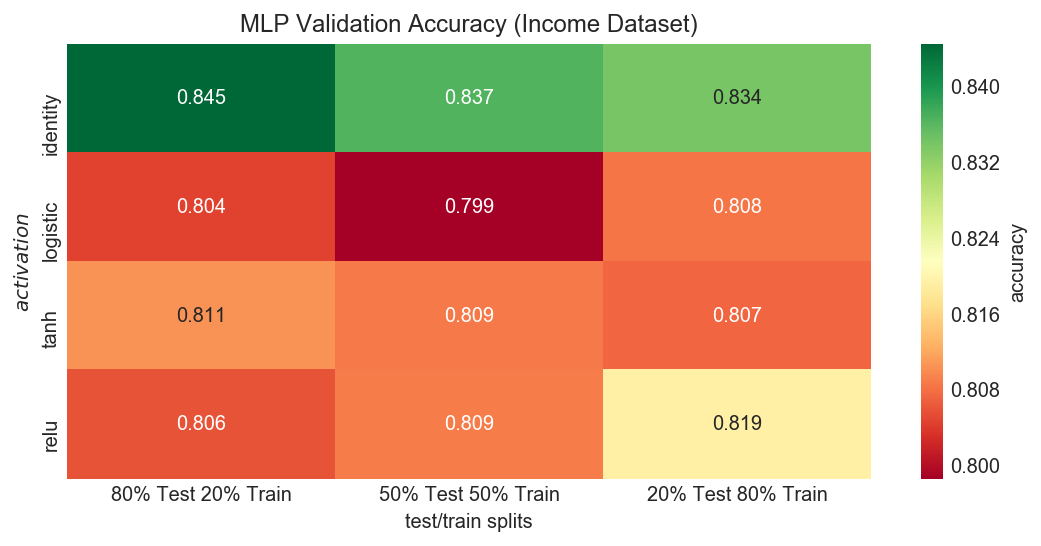

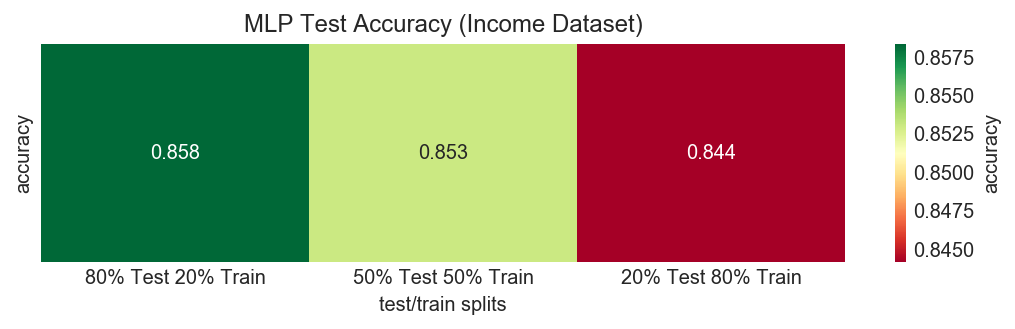

In [73]:
mlp_Income = mlp(X_train_val_Income_1, Y_train_val_Income_1,X_train_val_Income_2, Y_train_val_Income_2,\
            X_train_val_Income_3, Y_train_val_Income_3, X_test_Income_1, Y_test_Income_1,\
            X_test_Income_2, Y_test_Income_2, X_test_Income_3, Y_test_Income_3,\
            'MLP Training Accuracy (Income Dataset)', \
            'MLP Validation Accuracy (Income Dataset)',\
            'MLP Test Accuracy (Income Dataset)')

In [74]:
mlp_overall_avg.append(np.mean(list(mlp_Income.values())))

temp = [] #hold split values
temp.append(mlp_Income['80/20 Split Train'])
temp.append(mlp_Income['80/20 Split Validation'])
temp.append(mlp_Income['80/20 Split Test'])
mlp_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Income['50/50 Split Train'])
temp.append(mlp_Income['50/50 Split Validation'])
temp.append(mlp_Income['50/50 Split Test'])
mlp_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Income['20/80 Split Train'])
temp.append(mlp_Income['20/80 Split Validation'])
temp.append(mlp_Income['20/80 Split Test'])
mlp_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(mlp_Income['80/20 Split Test'])
temp.append(mlp_Income['50/50 Split Test'])
temp.append(mlp_Income['20/80 Split Test'])

mlp_Income_Average_Test = np.mean(np.array(temp))
mlp_Income_SD_Test = np.std(np.array(temp))
mlp_Income_Max_Test = np.max(np.array(temp))
mlp_Income_Min_Test = np.min(np.array(temp))

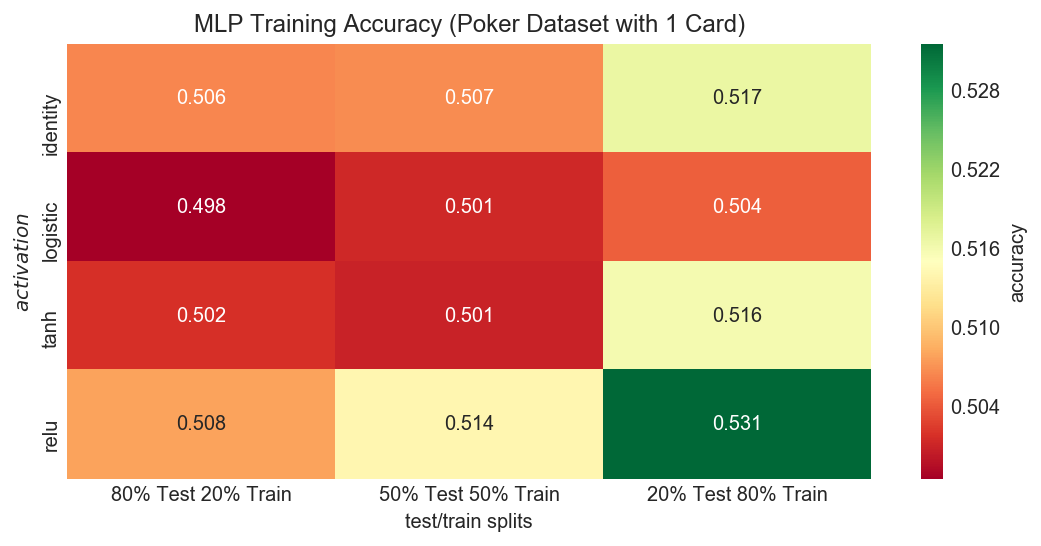

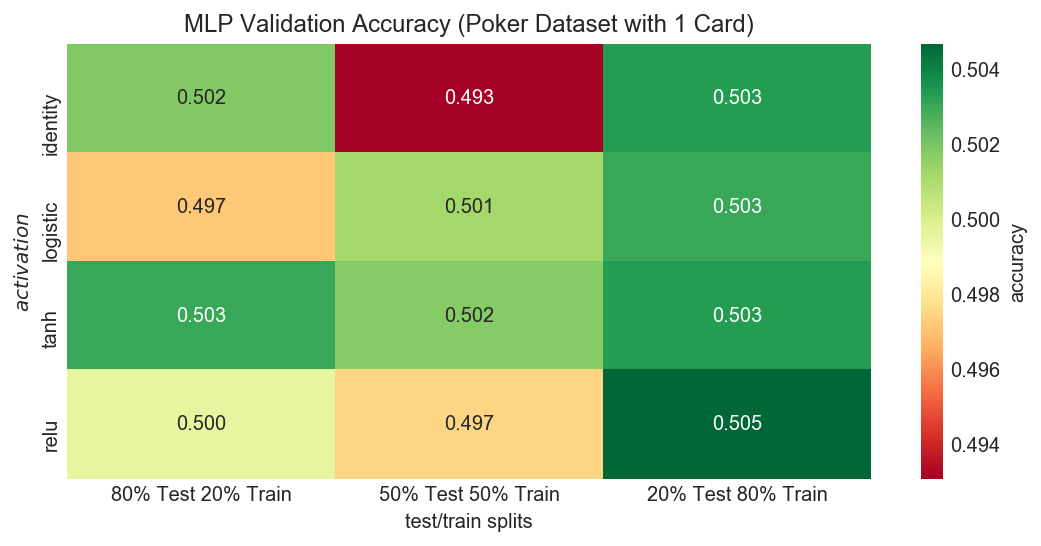

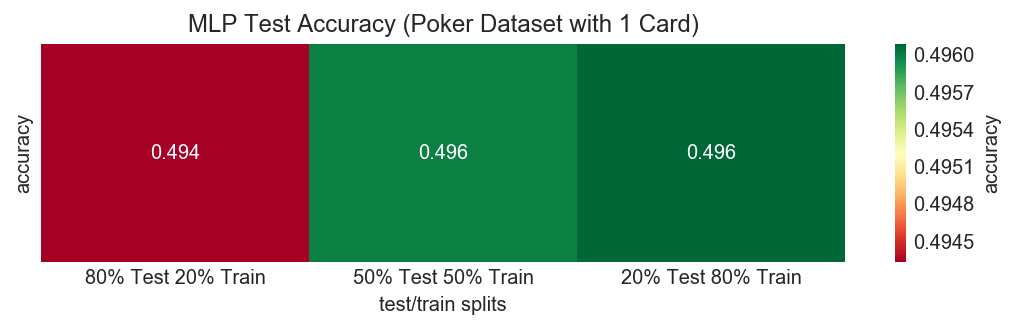

In [75]:
mlp_Poker_1 = mlp(X_train_val_Poker_1_Cards_1, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_1, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_1, Y_train_val_Poker_3,X_test_Poker_1_Cards_1, Y_test_Poker_1,\
            X_test_Poker_2_Cards_1, Y_test_Poker_2, X_test_Poker_3_Cards_1, Y_test_Poker_3,\
            'MLP Training Accuracy (Poker Dataset with 1 Card)', \
            'MLP Validation Accuracy (Poker Dataset with 1 Card)',\
            'MLP Test Accuracy (Poker Dataset with 1 Card)')

In [76]:
#mlp_overall_avg.append(np.mean(list(mlp_Poker_1.values())))

temp = [] #hold split values
temp.append(mlp_Poker_1['80/20 Split Train'])
temp.append(mlp_Poker_1['80/20 Split Validation'])
temp.append(mlp_Poker_1['80/20 Split Test'])
mlp_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Poker_1['50/50 Split Train'])
temp.append(mlp_Poker_1['50/50 Split Validation'])
temp.append(mlp_Poker_1['50/50 Split Test'])
mlp_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Poker_1['20/80 Split Train'])
temp.append(mlp_Poker_1['20/80 Split Validation'])
temp.append(mlp_Poker_1['20/80 Split Test'])
mlp_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(mlp_Poker_1['80/20 Split Test'])
temp.append(mlp_Poker_1['50/50 Split Test'])
temp.append(mlp_Poker_1['20/80 Split Test'])

mlp_Poker_1_Average_Test = np.mean(np.array(temp))
mlp_Poker_1_SD_Test = np.std(np.array(temp))
mlp_Poker_1_Max_Test = np.max(np.array(temp))
mlp_Poker_1_Min_Test = np.min(np.array(temp))

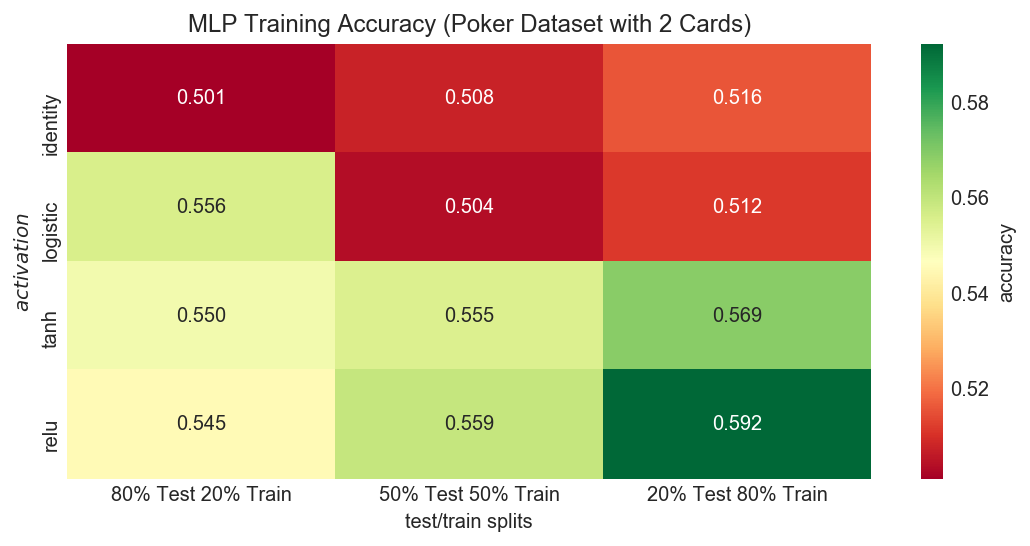

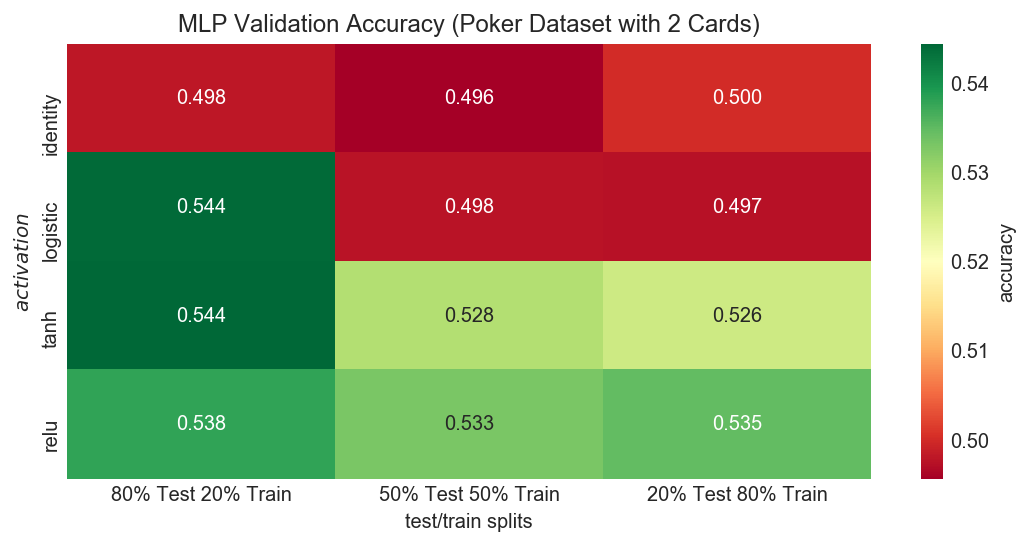

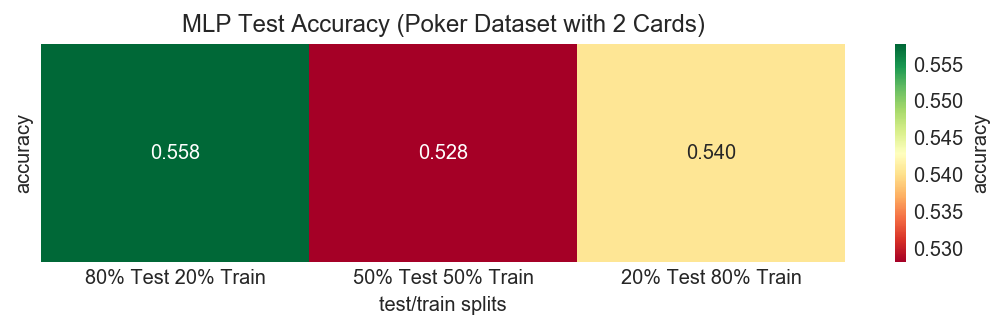

In [77]:
mlp_Poker_2 = mlp(X_train_val_Poker_1_Cards_2, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_2, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_2, Y_train_val_Poker_3,X_test_Poker_1_Cards_2, Y_test_Poker_1,\
            X_test_Poker_2_Cards_2, Y_test_Poker_2, X_test_Poker_3_Cards_2, Y_test_Poker_3,\
            'MLP Training Accuracy (Poker Dataset with 2 Cards)', \
            'MLP Validation Accuracy (Poker Dataset with 2 Cards)',\
            'MLP Test Accuracy (Poker Dataset with 2 Cards)')

In [78]:
#mlp_overall_avg.append(np.mean(list(mlp_Poker_2.values())))

temp = [] #hold split values
temp.append(mlp_Poker_2['80/20 Split Train'])
temp.append(mlp_Poker_2['80/20 Split Validation'])
temp.append(mlp_Poker_2['80/20 Split Test'])
mlp_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Poker_2['50/50 Split Train'])
temp.append(mlp_Poker_2['50/50 Split Validation'])
temp.append(mlp_Poker_2['50/50 Split Test'])
mlp_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Poker_2['20/80 Split Train'])
temp.append(mlp_Poker_2['20/80 Split Validation'])
temp.append(mlp_Poker_2['20/80 Split Test'])
mlp_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(mlp_Poker_2['80/20 Split Test'])
temp.append(mlp_Poker_2['50/50 Split Test'])
temp.append(mlp_Poker_2['20/80 Split Test'])

mlp_Poker_2_Average_Test = np.mean(np.array(temp))
mlp_Poker_2_SD_Test = np.std(np.array(temp))
mlp_Poker_2_Max_Test = np.max(np.array(temp))
mlp_Poker_2_Min_Test = np.min(np.array(temp))

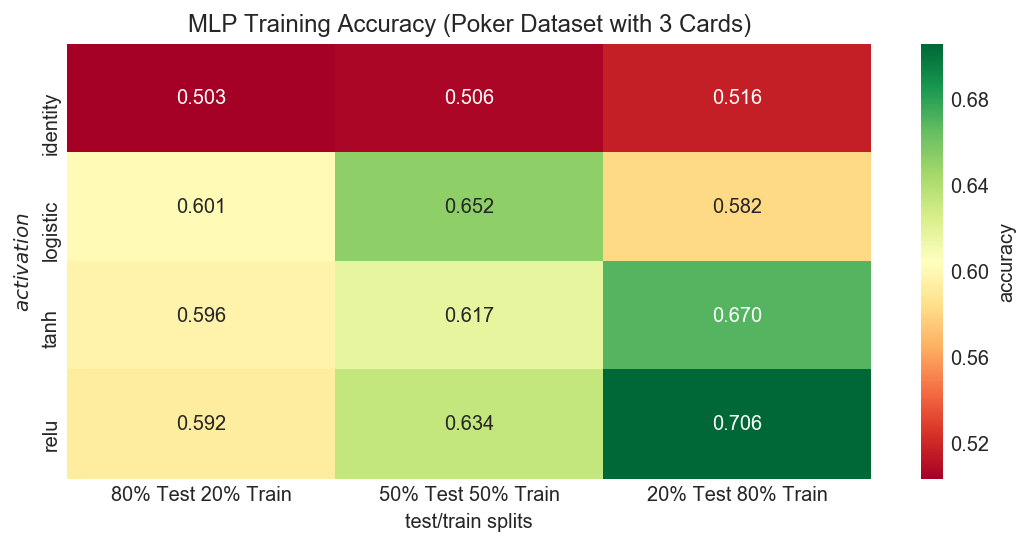

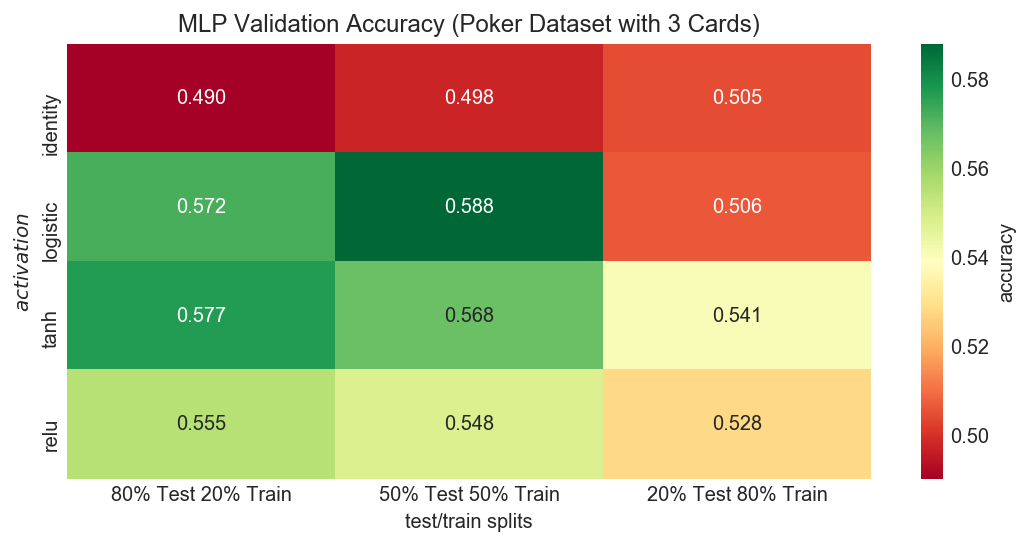

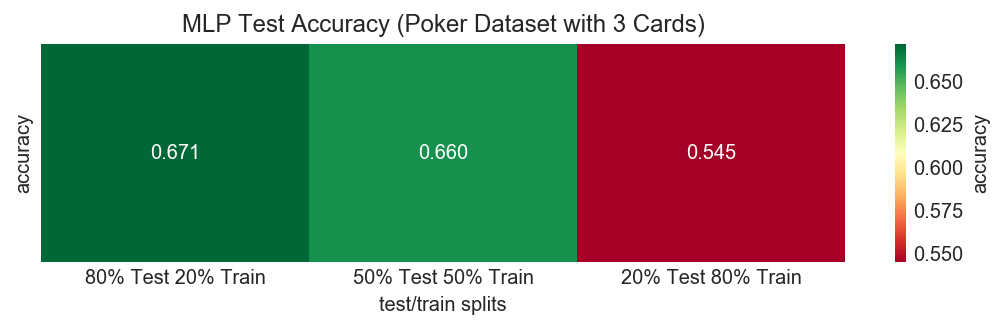

In [79]:
mlp_Poker_3 = mlp(X_train_val_Poker_1_Cards_3, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_3, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_3, Y_train_val_Poker_3,X_test_Poker_1_Cards_3, Y_test_Poker_1,\
            X_test_Poker_2_Cards_3, Y_test_Poker_2, X_test_Poker_3_Cards_3, Y_test_Poker_3,\
            'MLP Training Accuracy (Poker Dataset with 3 Cards)', \
            'MLP Validation Accuracy (Poker Dataset with 3 Cards)',\
            'MLP Test Accuracy (Poker Dataset with 3 Cards)')

In [80]:
#mlp_overall_avg.append(np.mean(list(mlp_Poker_3.values())))

temp = [] #hold split values
temp.append(mlp_Poker_3['80/20 Split Train'])
temp.append(mlp_Poker_3['80/20 Split Validation'])
temp.append(mlp_Poker_3['80/20 Split Test'])
mlp_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Poker_3['50/50 Split Train'])
temp.append(mlp_Poker_3['50/50 Split Validation'])
temp.append(mlp_Poker_3['50/50 Split Test'])
mlp_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Poker_3['20/80 Split Train'])
temp.append(mlp_Poker_3['20/80 Split Validation'])
temp.append(mlp_Poker_3['20/80 Split Test'])
mlp_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(mlp_Poker_3['80/20 Split Test'])
temp.append(mlp_Poker_3['50/50 Split Test'])
temp.append(mlp_Poker_3['20/80 Split Test'])

mlp_Poker_3_Average_Test = np.mean(np.array(temp))
mlp_Poker_3_SD_Test = np.std(np.array(temp))
mlp_Poker_3_Max_Test = np.max(np.array(temp))
mlp_Poker_3_Min_Test = np.min(np.array(temp))

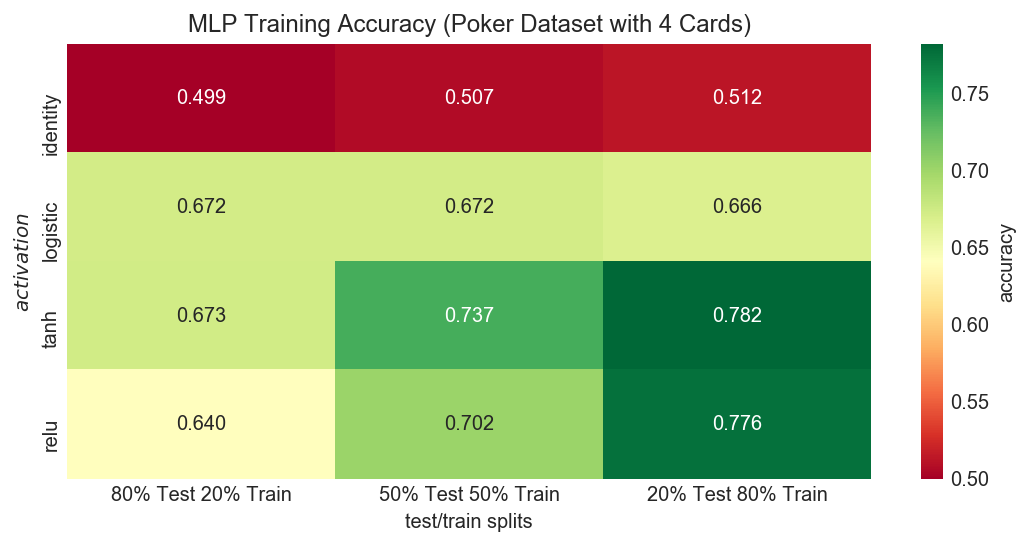

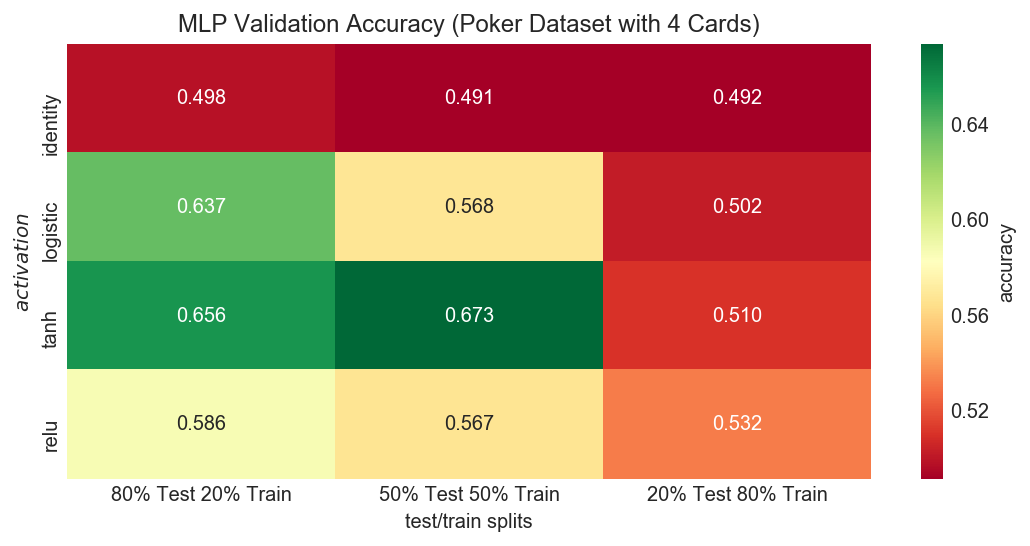

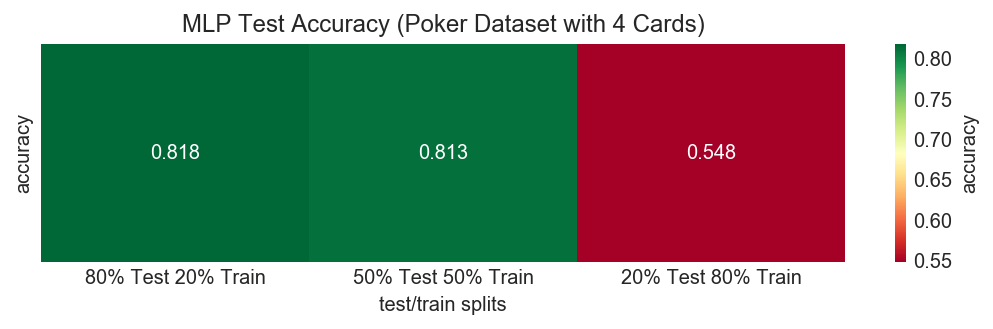

In [81]:
mlp_Poker_4 =mlp(X_train_val_Poker_1_Cards_4, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_4, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_4, Y_train_val_Poker_3,X_test_Poker_1_Cards_4, Y_test_Poker_1,\
            X_test_Poker_2_Cards_4, Y_test_Poker_2, X_test_Poker_3_Cards_4, Y_test_Poker_3,\
            'MLP Training Accuracy (Poker Dataset with 4 Cards)', \
            'MLP Validation Accuracy (Poker Dataset with 4 Cards)',\
            'MLP Test Accuracy (Poker Dataset with 4 Cards)')

In [82]:
#mlp_overall_avg.append(np.mean(list(mlp_Poker_4.values())))

temp = [] #hold split values
temp.append(mlp_Poker_4['80/20 Split Train'])
temp.append(mlp_Poker_4['80/20 Split Validation'])
temp.append(mlp_Poker_4['80/20 Split Test'])
mlp_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Poker_4['50/50 Split Train'])
temp.append(mlp_Poker_4['50/50 Split Validation'])
temp.append(mlp_Poker_4['50/50 Split Test'])
mlp_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Poker_4['20/80 Split Train'])
temp.append(mlp_Poker_4['20/80 Split Validation'])
temp.append(mlp_Poker_4['20/80 Split Test'])
mlp_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(mlp_Poker_4['80/20 Split Test'])
temp.append(mlp_Poker_4['50/50 Split Test'])
temp.append(mlp_Poker_4['20/80 Split Test'])

mlp_Poker_4_Average_Test = np.mean(np.array(temp))
mlp_Poker_4_SD_Test = np.std(np.array(temp))
mlp_Poker_4_Max_Test = np.max(np.array(temp))
mlp_Poker_4_Min_Test = np.min(np.array(temp))

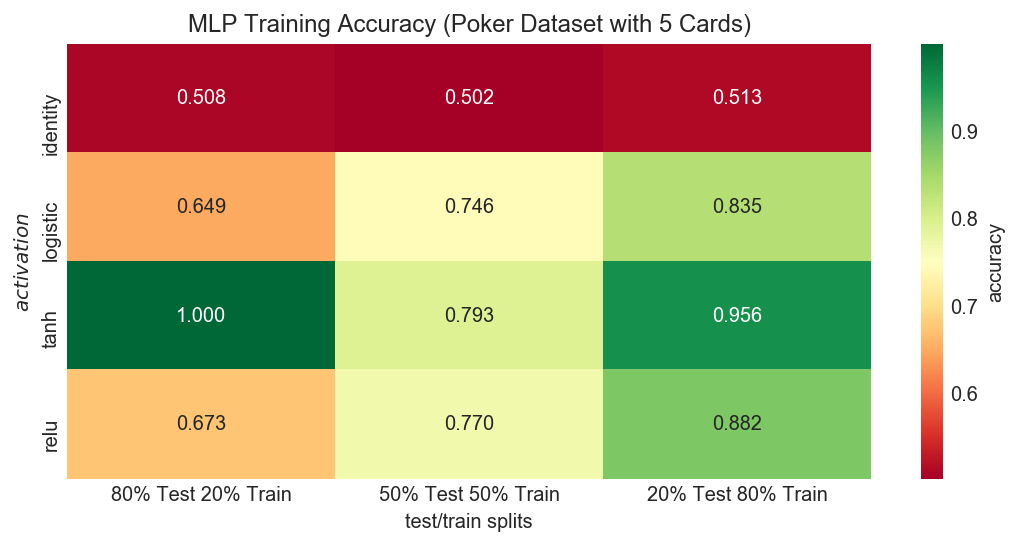

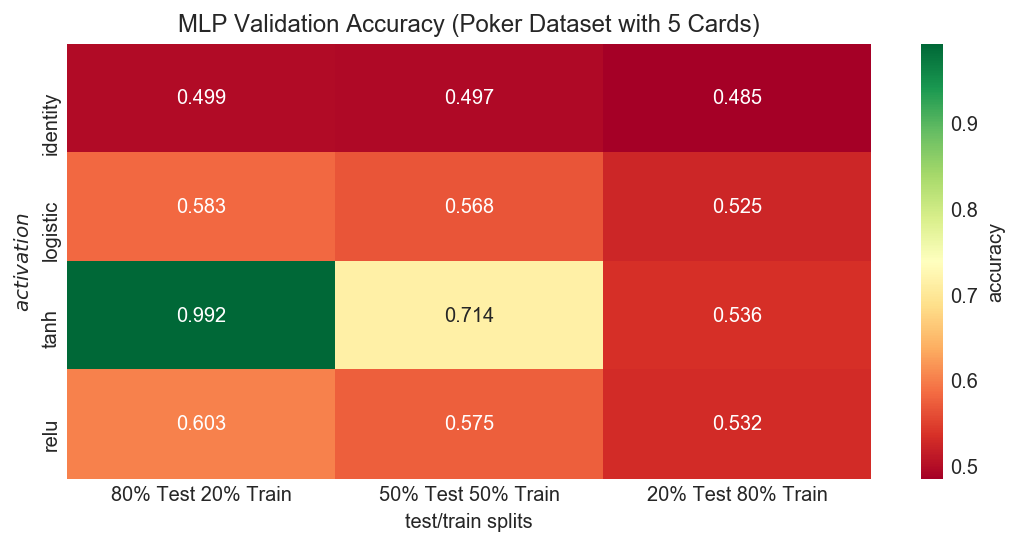

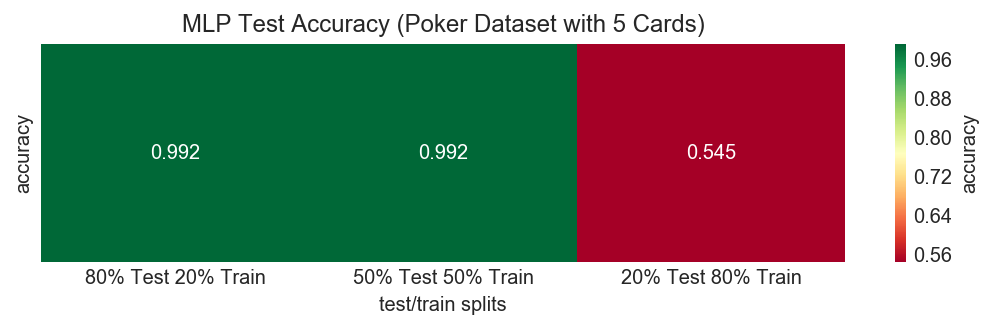

In [83]:
mlp_Poker_5 = mlp(X_train_val_Poker_1_Cards_5, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_5, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_5, Y_train_val_Poker_3,X_test_Poker_1_Cards_5, Y_test_Poker_1,\
            X_test_Poker_2_Cards_5, Y_test_Poker_2, X_test_Poker_3_Cards_5, Y_test_Poker_3,\
            'MLP Training Accuracy (Poker Dataset with 5 Cards)', \
            'MLP Validation Accuracy (Poker Dataset with 5 Cards)',\
            'MLP Test Accuracy (Poker Dataset with 5 Cards)')

In [84]:
mlp_overall_avg.append(np.mean(list(mlp_Poker_5.values())))

temp = [] #hold split values
temp.append(mlp_Poker_5['80/20 Split Train'])
temp.append(mlp_Poker_5['80/20 Split Validation'])
temp.append(mlp_Poker_5['80/20 Split Test'])
mlp_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Poker_5['50/50 Split Train'])
temp.append(mlp_Poker_5['50/50 Split Validation'])
temp.append(mlp_Poker_5['50/50 Split Test'])
mlp_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Poker_5['20/80 Split Train'])
temp.append(mlp_Poker_5['20/80 Split Validation'])
temp.append(mlp_Poker_5['20/80 Split Test'])
mlp_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(mlp_Poker_5['80/20 Split Test'])
temp.append(mlp_Poker_5['50/50 Split Test'])
temp.append(mlp_Poker_5['20/80 Split Test'])

mlp_Poker_5_Average_Test = np.mean(np.array(temp))
mlp_Poker_5_SD_Test = np.std(np.array(temp))
mlp_Poker_5_Max_Test = np.max(np.array(temp))
mlp_Poker_5_Min_Test = np.min(np.array(temp))

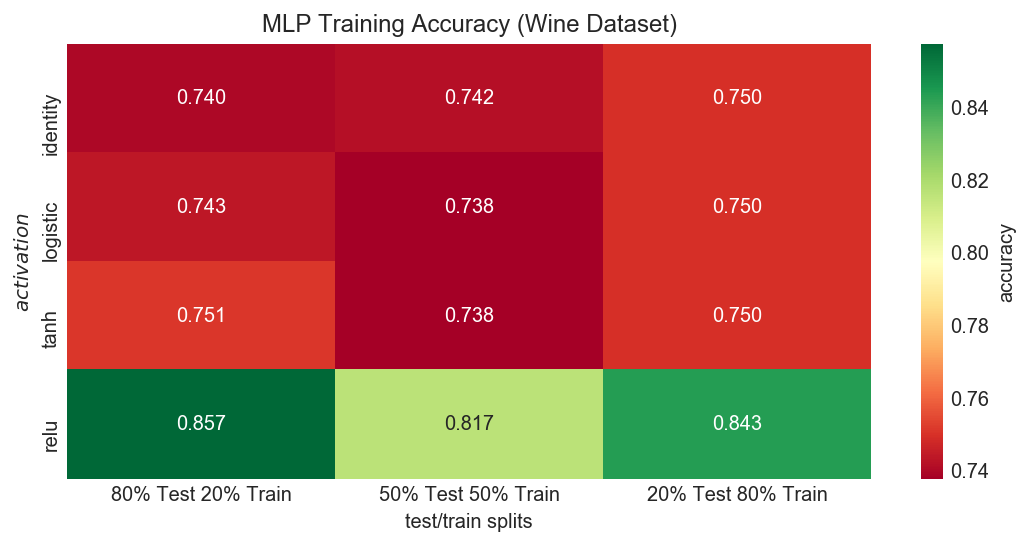

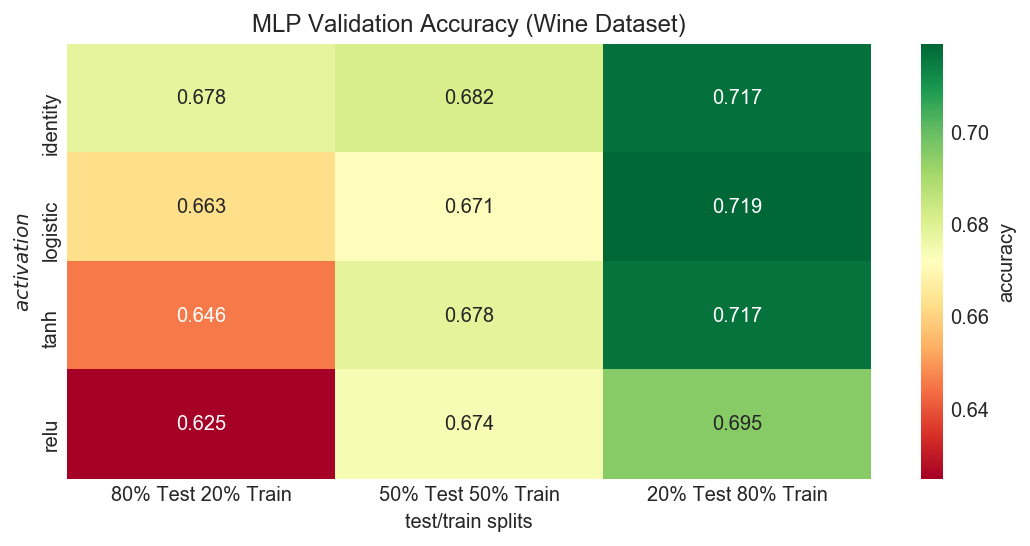

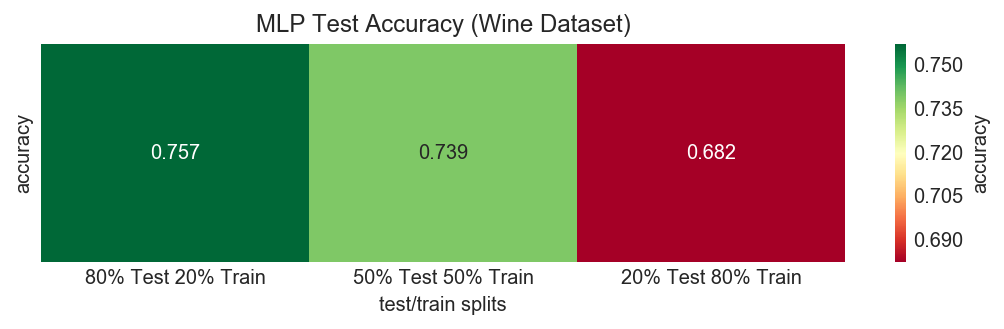

In [85]:
mlp_Wine = mlp(X_train_val_Wine_1, Y_train_val_Wine_1,X_train_val_Wine_2, Y_train_val_Wine_2,\
            X_train_val_Wine_3, Y_train_val_Wine_3,X_test_Wine_1, Y_test_Wine_1, \
            X_test_Wine_2, Y_test_Wine_2,X_test_Wine_3, Y_test_Wine_3,\
            'MLP Training Accuracy (Wine Dataset)', \
            'MLP Validation Accuracy (Wine Dataset)',\
            'MLP Test Accuracy (Wine Dataset)')

In [86]:
mlp_overall_avg.append(np.mean(list(mlp_Wine.values())))

temp = [] #hold split values
temp.append(mlp_Wine['80/20 Split Train'])
temp.append(mlp_Wine['80/20 Split Validation'])
temp.append(mlp_Wine['80/20 Split Test'])
mlp_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Wine['50/50 Split Train'])
temp.append(mlp_Wine['50/50 Split Validation'])
temp.append(mlp_Wine['50/50 Split Test'])
mlp_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(mlp_Wine['20/80 Split Train'])
temp.append(mlp_Wine['20/80 Split Validation'])
temp.append(mlp_Wine['20/80 Split Test'])
mlp_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(mlp_Wine['80/20 Split Test'])
temp.append(mlp_Wine['50/50 Split Test'])
temp.append(mlp_Wine['20/80 Split Test'])

mlp_Wine_Average_Test = np.mean(np.array(temp))
mlp_Wine_SD_Test = np.std(np.array(temp))
mlp_Wine_Max_Test = np.max(np.array(temp))
mlp_Wine_Min_Test = np.min(np.array(temp))

In [87]:
# #courtesey of https://github.com/aditisrinivas97/Pokerman
# def mlp_poker(X_train, Y_train, X_test, Y_test):

#     # Store the accuracies
#     accuracy = list()

#     # Store the predictions
#     predictions = list()

#     for trial in range(5):
#         classifier = MLPClassifier(activation = 'tanh', learning_rate_init = 0.02, max_iter = 2000, random_state = trial)
#         result = classifier.fit(X_train, Y_train)
#         prediction = classifier.predict(X_test)
#         predictions.append(prediction)
#         curr_accuracy = accuracy_score(Y_test, prediction)
#         accuracy.append(curr_accuracy)
#     print(accuracy)
    
    

In [88]:
# mlp_poker(X_poker_train_MLP, Y_poker_train_MLP, X_poker_test_MLP, Y_poker_test_MLP)

### Classifier 5: Decision Tree

In [89]:
#decision tree with cross validation of 3
def tree(X_train_pred_1, Y_train_val_1, X_train_pred_2, Y_train_val_2, X_train_pred_3, Y_train_val_3,\
               X_test_1, Y_test_1, X_test_2, Y_test_2, X_test_3, Y_test_3, title1, title2, title3):
    # Initialize model.
    
    depth = [1,2,3,4,5]
    tree = DecisionTreeClassifier(criterion='entropy')
    
    test_train_split = ['80% Test 20% Train', '50% Test 50% Train', '20% Test 80% Train']
    
    grid_search_1 = GridSearchCV(tree, {'max_depth': depth},  cv = 3, return_train_score= True, iid = False)
    grid_search_1.fit(X_train_pred_1, Y_train_val_1)
    
    grid_search_2 = GridSearchCV(tree, {'max_depth': depth},  cv = 3, return_train_score= True, iid = False)
    grid_search_2.fit(X_train_pred_2, Y_train_val_2)
    
    grid_search_3 = GridSearchCV(tree, {'max_depth': depth},  cv = 3, return_train_score= True, iid = False)
    grid_search_3.fit(X_train_pred_3, Y_train_val_3)

    
    #training accuracy
    train_acc_1 = grid_search_1.cv_results_['mean_train_score'].reshape(5,1)
    train_acc_2 = grid_search_2.cv_results_['mean_train_score'].reshape(5,1)
    train_acc_3 = grid_search_3.cv_results_['mean_train_score'].reshape(5,1)
    
    train_acc = np.array([[train_acc_1],[train_acc_2], [train_acc_3]]).T
    train_acc = train_acc.reshape(5,3)
    #print(train_acc)
    draw_heatmap_tree(train_acc, title1, depth, test_train_split)

    
    #validation accuracy
    val_acc_1 = grid_search_1.cv_results_['mean_test_score'].reshape(5,1)
    val_acc_2 = grid_search_2.cv_results_['mean_test_score'].reshape(5,1)
    val_acc_3 = grid_search_3.cv_results_['mean_test_score'].reshape(5,1)
    
    val_acc = np.array([[val_acc_1],[val_acc_2], [val_acc_3]]).T
    val_acc = val_acc.reshape(5,3)
    #print(train_acc)
    draw_heatmap_tree(val_acc, title2, depth, test_train_split)
    
    
    #test accuracy
    counter = 0
    pred_1 = grid_search_1.predict(X_test_1)
    for i in range(len(pred_1)):
        if pred_1[i] != Y_test_1.iloc[i]:
            counter += 1
    test_acc_1 = 1-(counter / len(pred_1))
    
    counter = 0
    pred_2 = grid_search_2.predict(X_test_2)
    for i in range(len(pred_2)):
        if pred_2[i] != Y_test_2.iloc[i]:
            counter += 1
    test_acc_2 = 1-(counter / len(pred_2))
    
    counter = 0
    pred_3 = grid_search_3.predict(X_test_3)
    for i in range(len(pred_3)):
        if pred_3[i] != Y_test_3.iloc[i]:
            counter += 1
    test_acc_3 = 1-(counter / len(pred_3))
    
    test_acc = np.array([[test_acc_1], [test_acc_2], [test_acc_3]]).reshape(1,3)
    draw_heatmap_tree_test(test_acc, title3, test_train_split)
    
    treeDict = {}
    treeDict['80/20 Split Train'] = np.mean(train_acc_1)
    treeDict['50/50 Split Train'] = np.mean(train_acc_2)
    treeDict['20/80 Split Train'] = np.mean(train_acc_3)
    treeDict['80/20 Split Validation'] = np.mean(val_acc_1)
    treeDict['50/50 Split Validation'] = np.mean(val_acc_2)
    treeDict['20/80 Split Validation'] = np.mean(val_acc_3)
    treeDict['80/20 Split Test'] = test_acc_1
    treeDict['50/50 Split Test'] = test_acc_2
    treeDict['20/80 Split Test'] = test_acc_3
    return treeDict

#### Average Decision Tree Value Parameters

In [90]:
tree_Income_Average_Test = 0
tree_Income_SD_Test = 0
tree_Income_Max_Test = 0
tree_Income_Min_Test = 0

tree_Poker_1_Average_Test = 0
tree_Poker_1_SD_Test = 0
tree_Poker_1_Max_Test = 0
tree_Poker_1_Min_Test = 0

tree_Poker_2_Average_Test = 0
tree_Poker_2_SD_Test = 0
tree_Poker_2_Max_Test = 0
tree_Poker_2_Min_Test = 0

tree_Poker_3_Average_Test = 0
tree_Poker_3_SD_Test = 0
tree_Poker_3_Max_Test = 0
tree_Poker_3_Min_Test = 0

tree_Poker_5_Average_Test = 0
tree_Poker_5_SD_Test = 0
tree_Poker_5_Max_Test = 0
tree_Poker_5_Min_Test = 0

tree_Poker_Overall_Average_Test = 0
tree_Poker_Overall_SD_Test = 0
tree_Poker_Overall_Max_Test = 0
tree_Poker_Overall_Min_Test = 0

tree_Wine_Average_Test =0
tree_Wine_SD = 0
tree_Wine_Max_Test = 0
tree_Wine_Min_Test = 0

tree_overall_avg = []
tree_80_20_split_avg = []
tree_50_50_split_avg = []
tree_20_80_split_avg = []

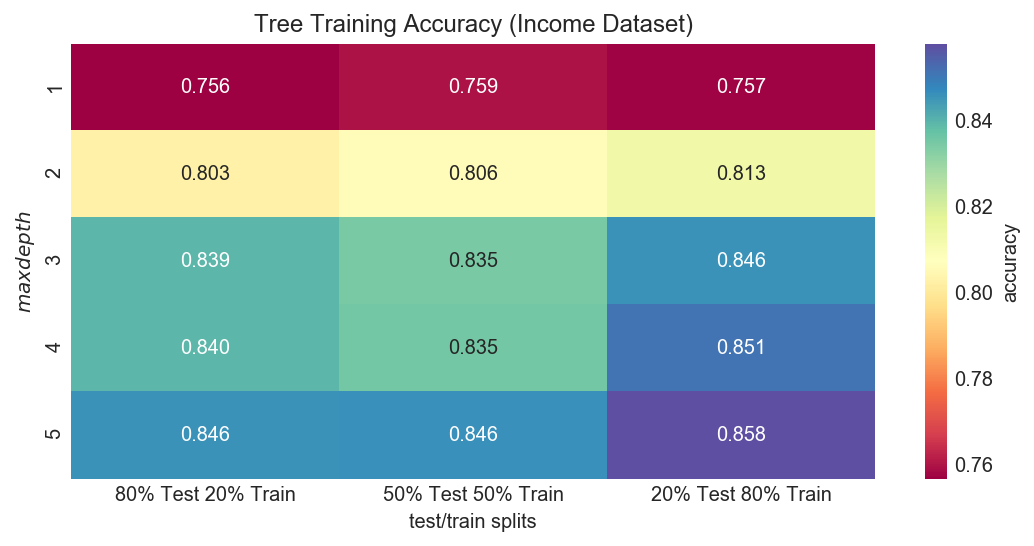

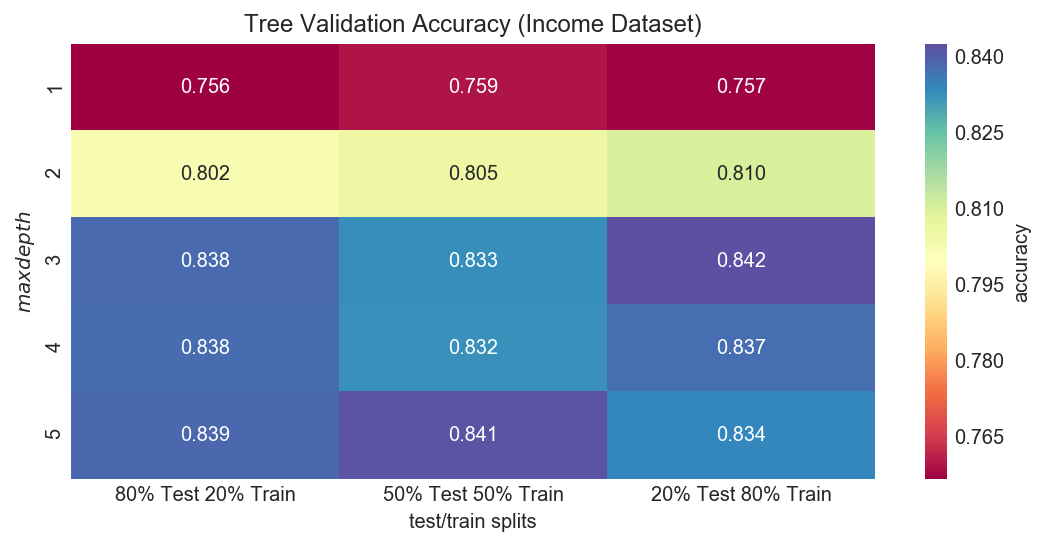

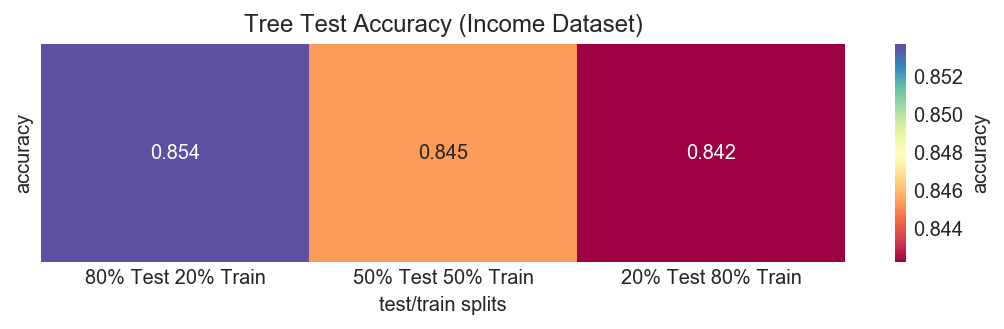

In [91]:
tree_Income = tree(X_train_val_Income_1, Y_train_val_Income_1,X_train_val_Income_2, Y_train_val_Income_2,\
            X_train_val_Income_3, Y_train_val_Income_3, X_test_Income_1, Y_test_Income_1,\
            X_test_Income_2, Y_test_Income_2, X_test_Income_3, Y_test_Income_3,\
            'Tree Training Accuracy (Income Dataset)', \
            'Tree Validation Accuracy (Income Dataset)',\
            'Tree Test Accuracy (Income Dataset)')

In [92]:
tree_overall_avg.append(np.mean(list(tree_Income.values())))

temp = [] #hold split values
temp.append(tree_Income['80/20 Split Train'])
temp.append(tree_Income['80/20 Split Validation'])
temp.append(tree_Income['80/20 Split Test'])
tree_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Income['50/50 Split Train'])
temp.append(tree_Income['50/50 Split Validation'])
temp.append(tree_Income['50/50 Split Test'])
tree_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Income['20/80 Split Train'])
temp.append(tree_Income['20/80 Split Validation'])
temp.append(tree_Income['20/80 Split Test'])
tree_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(tree_Income['80/20 Split Test'])
temp.append(tree_Income['50/50 Split Test'])
temp.append(tree_Income['20/80 Split Test'])

tree_Income_Average_Test = np.mean(np.array(temp))
tree_Income_SD_Test = np.std(np.array(temp))
tree_Income_Max_Test = np.max(np.array(temp))
tree_Income_Min_Test = np.min(np.array(temp))

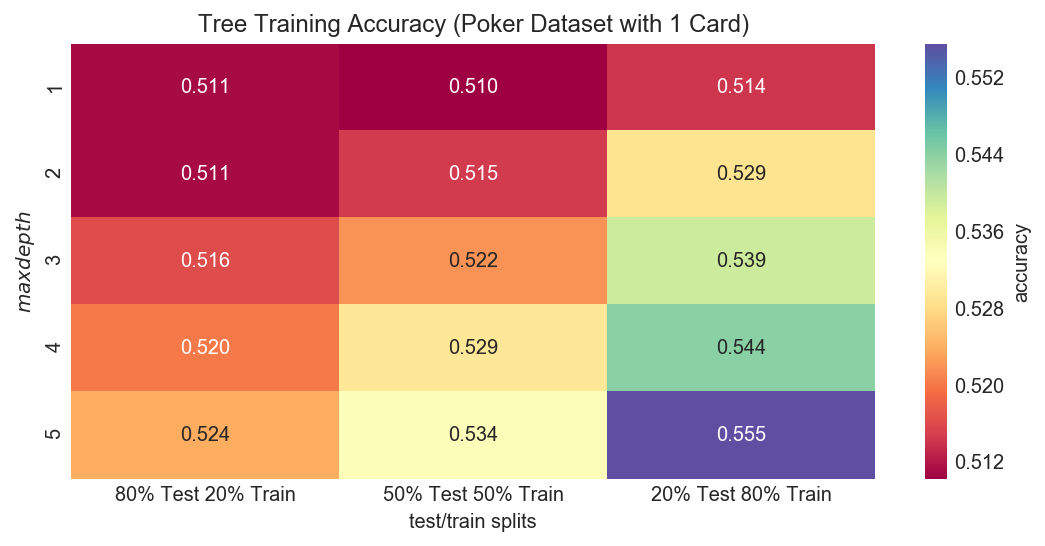

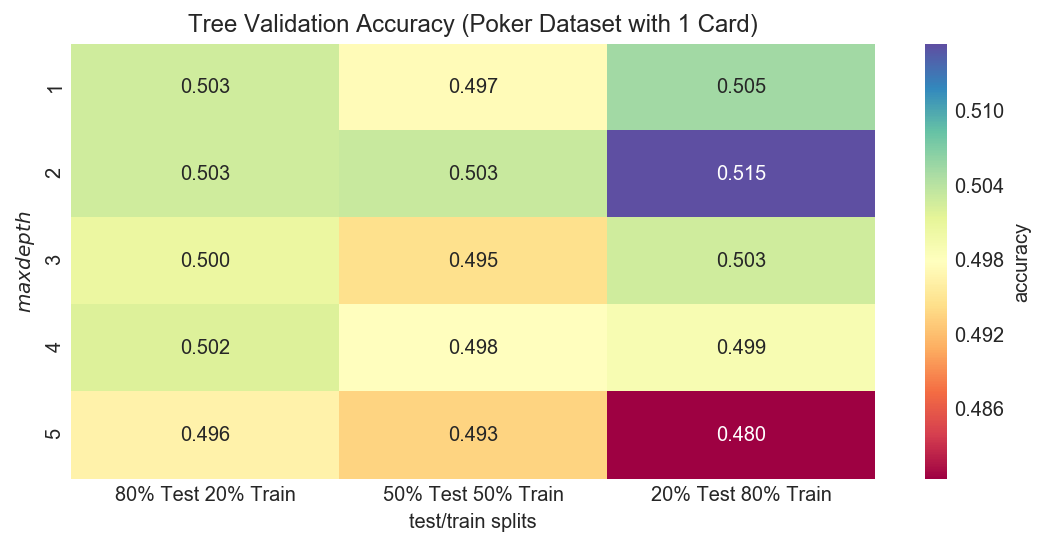

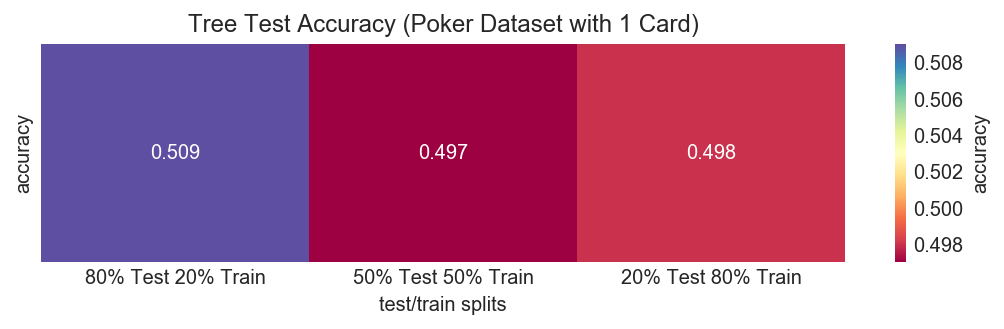

In [93]:
tree_Poker_1 = tree(X_train_val_Poker_1_Cards_1, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_1, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_1, Y_train_val_Poker_3,X_test_Poker_1_Cards_1, Y_test_Poker_1,\
            X_test_Poker_2_Cards_1, Y_test_Poker_2, X_test_Poker_3_Cards_1, Y_test_Poker_3,\
            'Tree Training Accuracy (Poker Dataset with 1 Card)', \
            'Tree Validation Accuracy (Poker Dataset with 1 Card)',\
            'Tree Test Accuracy (Poker Dataset with 1 Card)')

In [94]:
#tree_overall_avg.append(np.mean(list(tree_Poker_1.values())))

temp = [] #hold split values
temp.append(tree_Poker_1['80/20 Split Train'])
temp.append(tree_Poker_1['80/20 Split Validation'])
temp.append(tree_Poker_1['80/20 Split Test'])
tree_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Poker_1['50/50 Split Train'])
temp.append(tree_Poker_1['50/50 Split Validation'])
temp.append(tree_Poker_1['50/50 Split Test'])
tree_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Poker_1['20/80 Split Train'])
temp.append(tree_Poker_1['20/80 Split Validation'])
temp.append(tree_Poker_1['20/80 Split Test'])
tree_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(tree_Poker_1['80/20 Split Test'])
temp.append(tree_Poker_1['50/50 Split Test'])
temp.append(tree_Poker_1['20/80 Split Test'])

tree_Poker_1_Average_Test = np.mean(np.array(temp))
tree_Poker_1_SD_Test = np.std(np.array(temp))
tree_Poker_1_Max_Test = np.max(np.array(temp))
tree_Poker_1_Min_Test = np.min(np.array(temp))

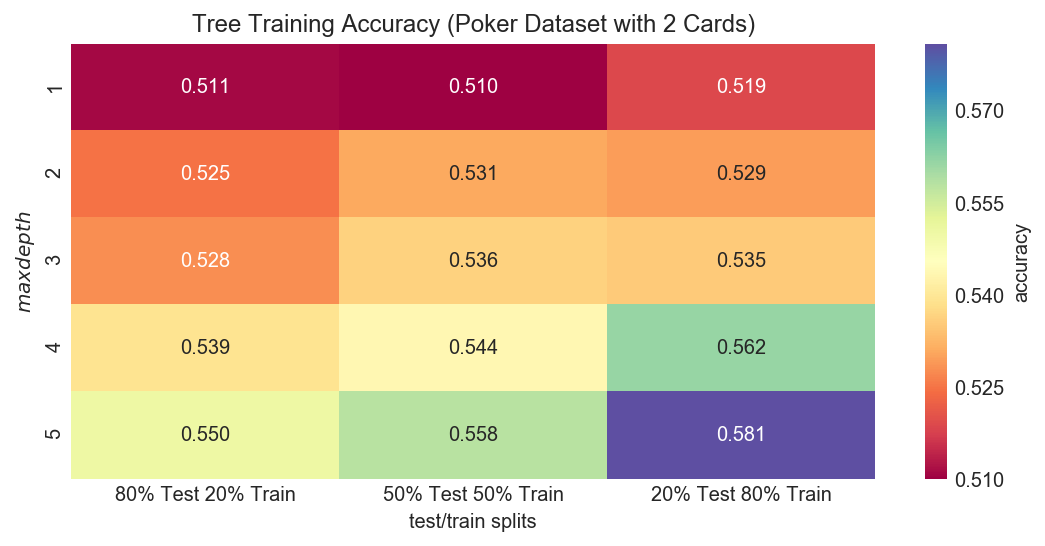

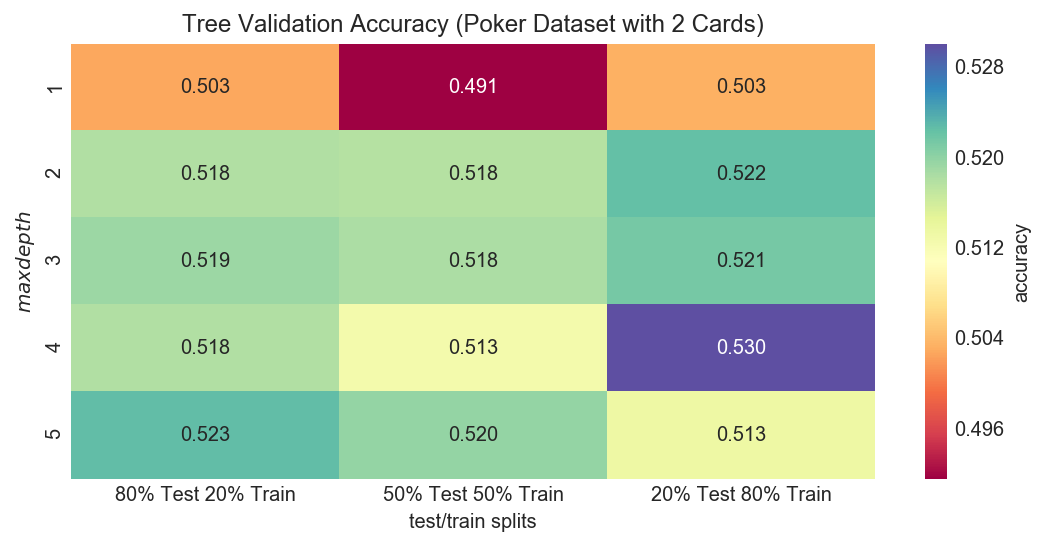

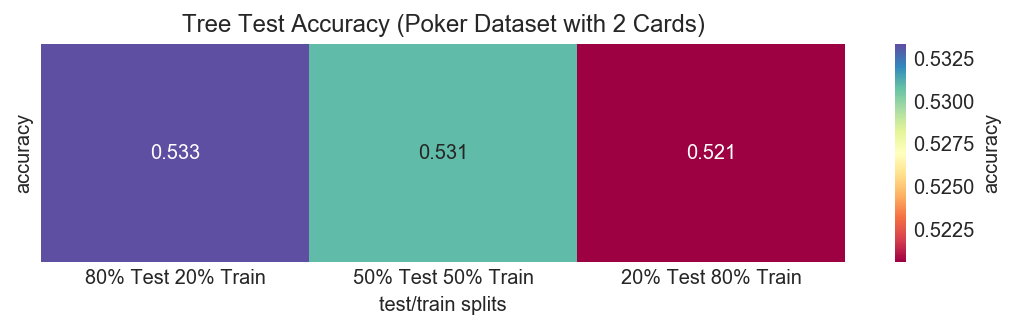

In [95]:
tree_Poker_2 = tree(X_train_val_Poker_1_Cards_2, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_2, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_2, Y_train_val_Poker_3,X_test_Poker_1_Cards_2, Y_test_Poker_1,\
            X_test_Poker_2_Cards_2, Y_test_Poker_2, X_test_Poker_3_Cards_2, Y_test_Poker_3,\
            'Tree Training Accuracy (Poker Dataset with 2 Cards)', \
            'Tree Validation Accuracy (Poker Dataset with 2 Cards)',\
            'Tree Test Accuracy (Poker Dataset with 2 Cards)')

In [96]:
#tree_overall_avg.append(np.mean(list(tree_Poker_2.values())))

temp = [] #hold split values
temp.append(tree_Poker_2['80/20 Split Train'])
temp.append(tree_Poker_2['80/20 Split Validation'])
temp.append(tree_Poker_2['80/20 Split Test'])
tree_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Poker_2['50/50 Split Train'])
temp.append(tree_Poker_2['50/50 Split Validation'])
temp.append(tree_Poker_2['50/50 Split Test'])
tree_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Poker_2['20/80 Split Train'])
temp.append(tree_Poker_2['20/80 Split Validation'])
temp.append(tree_Poker_2['20/80 Split Test'])
tree_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(tree_Poker_2['80/20 Split Test'])
temp.append(tree_Poker_2['50/50 Split Test'])
temp.append(tree_Poker_2['20/80 Split Test'])

tree_Poker_2_Average_Test = np.mean(np.array(temp))
tree_Poker_2_SD_Test = np.std(np.array(temp))
tree_Poker_2_Max_Test = np.max(np.array(temp))
tree_Poker_2_Min_Test = np.min(np.array(temp))

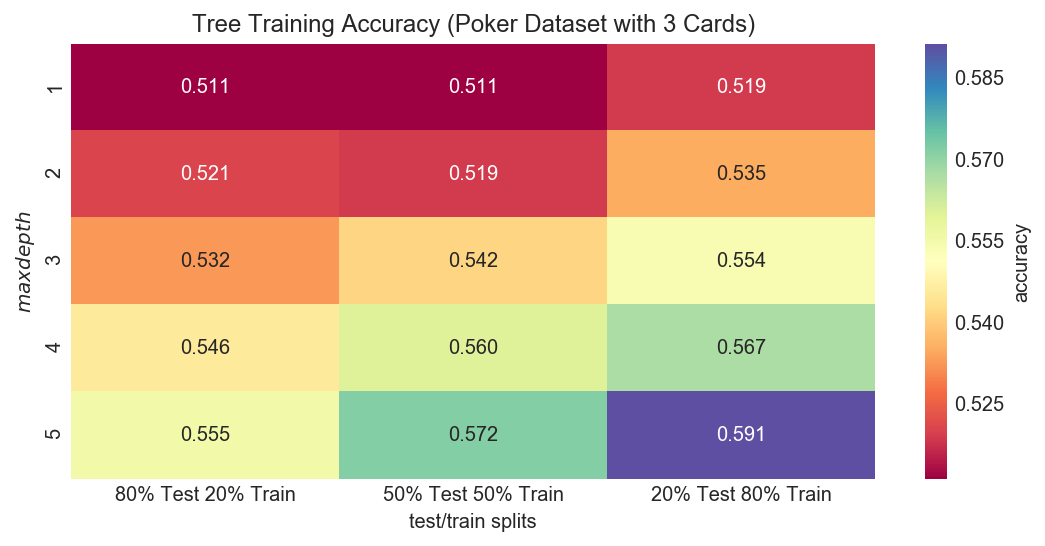

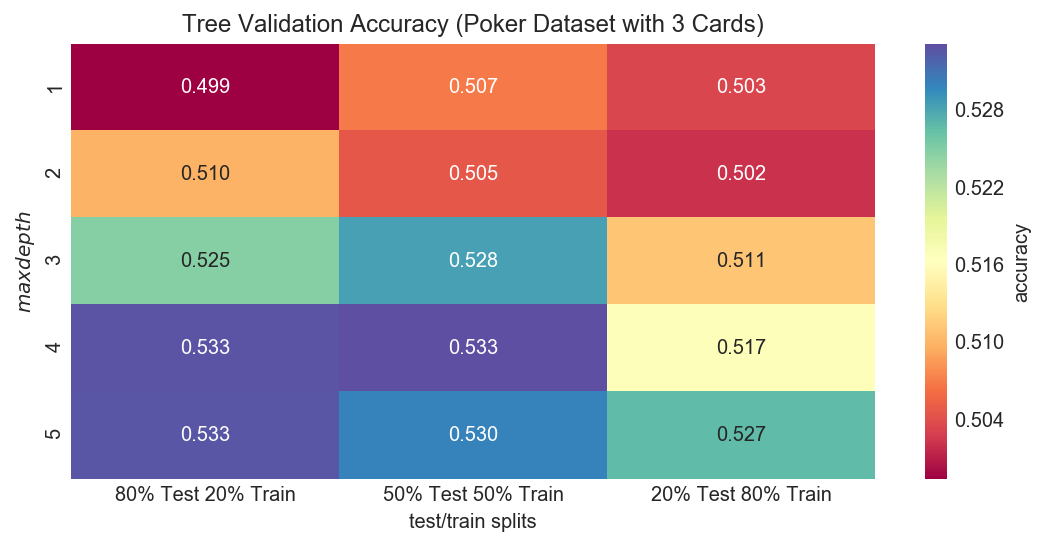

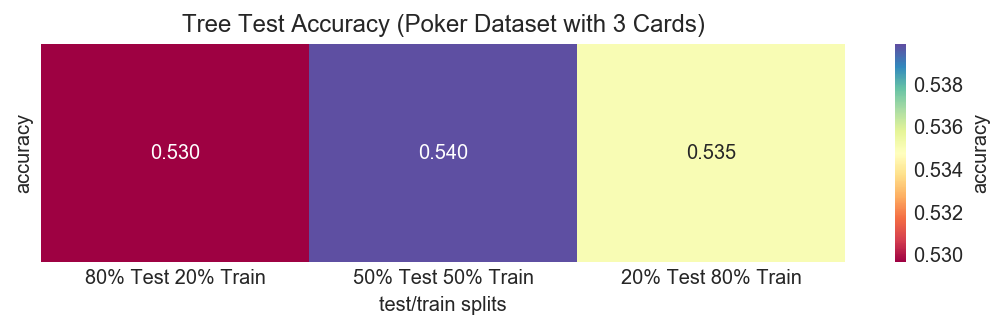

In [97]:
tree_Poker_3 = tree(X_train_val_Poker_1_Cards_3, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_3, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_3, Y_train_val_Poker_3,X_test_Poker_1_Cards_3, Y_test_Poker_1,\
            X_test_Poker_2_Cards_3, Y_test_Poker_2, X_test_Poker_3_Cards_3, Y_test_Poker_3,\
            'Tree Training Accuracy (Poker Dataset with 3 Cards)', \
            'Tree Validation Accuracy (Poker Dataset with 3 Cards)',\
            'Tree Test Accuracy (Poker Dataset with 3 Cards)')

In [98]:
#tree_overall_avg.append(np.mean(list(tree_Poker_3.values())))

temp = [] #hold split values
temp.append(tree_Poker_3['80/20 Split Train'])
temp.append(tree_Poker_3['80/20 Split Validation'])
temp.append(tree_Poker_3['80/20 Split Test'])
tree_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Poker_3['50/50 Split Train'])
temp.append(tree_Poker_3['50/50 Split Validation'])
temp.append(tree_Poker_3['50/50 Split Test'])
tree_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Poker_3['20/80 Split Train'])
temp.append(tree_Poker_3['20/80 Split Validation'])
temp.append(tree_Poker_3['20/80 Split Test'])
tree_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(tree_Poker_3['80/20 Split Test'])
temp.append(tree_Poker_3['50/50 Split Test'])
temp.append(tree_Poker_3['20/80 Split Test'])

tree_Poker_3_Average_Test = np.mean(np.array(temp))
tree_Poker_3_SD_Test = np.std(np.array(temp))
tree_Poker_3_Max_Test = np.max(np.array(temp))
tree_Poker_3_Min_Test = np.min(np.array(temp))

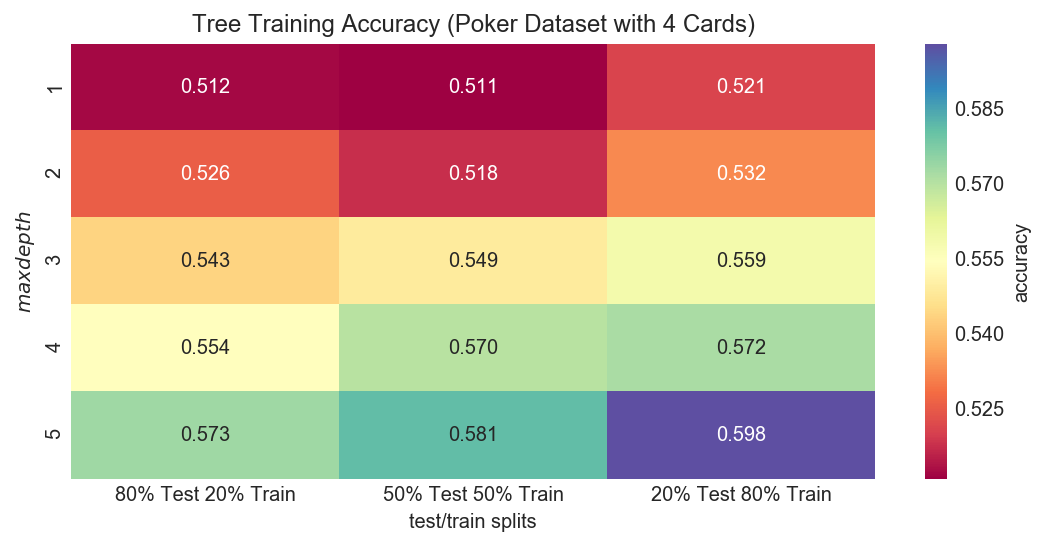

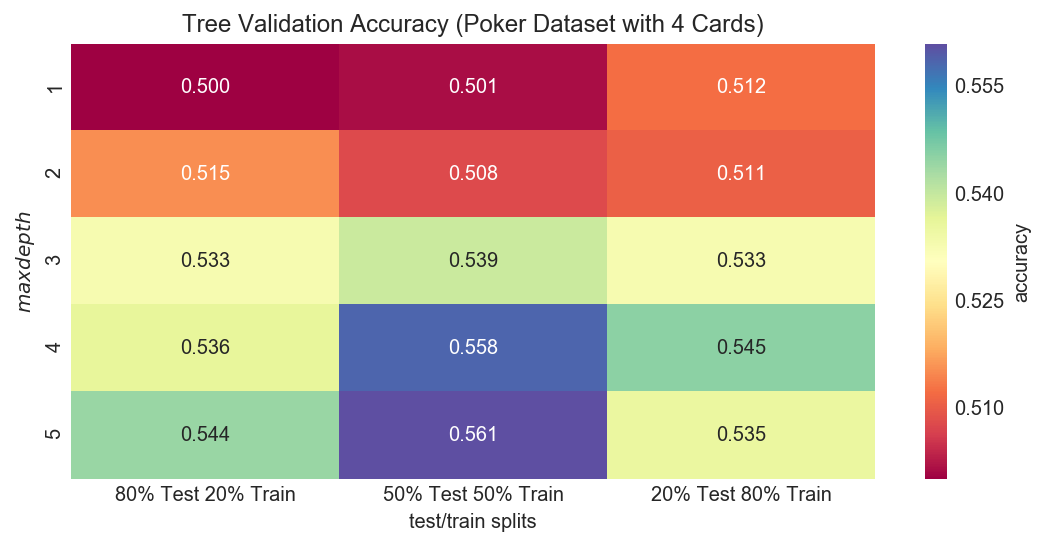

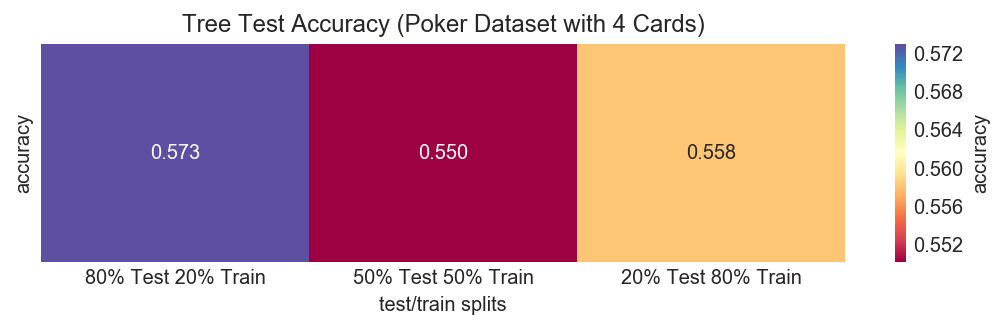

In [99]:
tree_Poker_4 = tree(X_train_val_Poker_1_Cards_4, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_4, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_4, Y_train_val_Poker_3,X_test_Poker_1_Cards_4, Y_test_Poker_1,\
            X_test_Poker_2_Cards_4, Y_test_Poker_2, X_test_Poker_3_Cards_4, Y_test_Poker_3,\
            'Tree Training Accuracy (Poker Dataset with 4 Cards)', \
            'Tree Validation Accuracy (Poker Dataset with 4 Cards)',\
            'Tree Test Accuracy (Poker Dataset with 4 Cards)')

In [100]:
#tree_overall_avg.append(np.mean(list(tree_Poker_4.values())))

temp = [] #hold split values
temp.append(tree_Poker_4['80/20 Split Train'])
temp.append(tree_Poker_4['80/20 Split Validation'])
temp.append(tree_Poker_4['80/20 Split Test'])
tree_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Poker_4['50/50 Split Train'])
temp.append(tree_Poker_4['50/50 Split Validation'])
temp.append(tree_Poker_4['50/50 Split Test'])
tree_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Poker_4['20/80 Split Train'])
temp.append(tree_Poker_4['20/80 Split Validation'])
temp.append(tree_Poker_4['20/80 Split Test'])
tree_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(tree_Poker_4['80/20 Split Test'])
temp.append(tree_Poker_4['50/50 Split Test'])
temp.append(tree_Poker_4['20/80 Split Test'])

tree_Poker_4_Average_Test = np.mean(np.array(temp))
tree_Poker_4_SD_Test = np.std(np.array(temp))
tree_Poker_4_Max_Test = np.max(np.array(temp))
tree_Poker_4_Min_Test = np.min(np.array(temp))

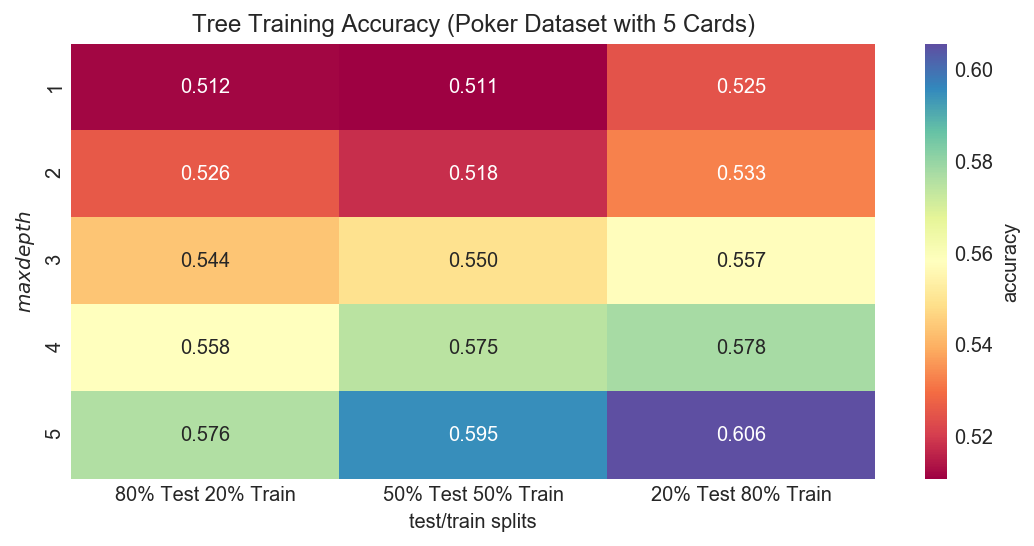

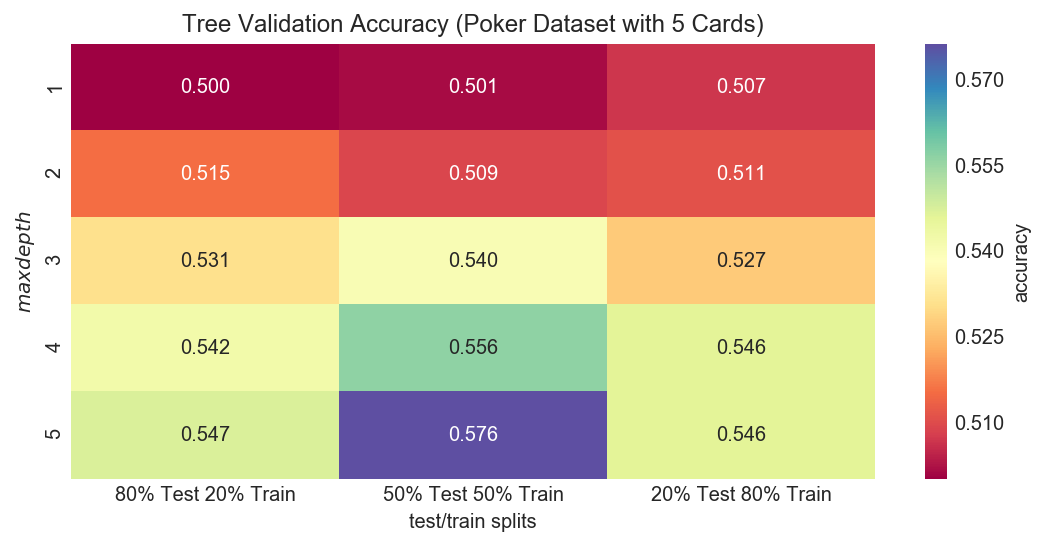

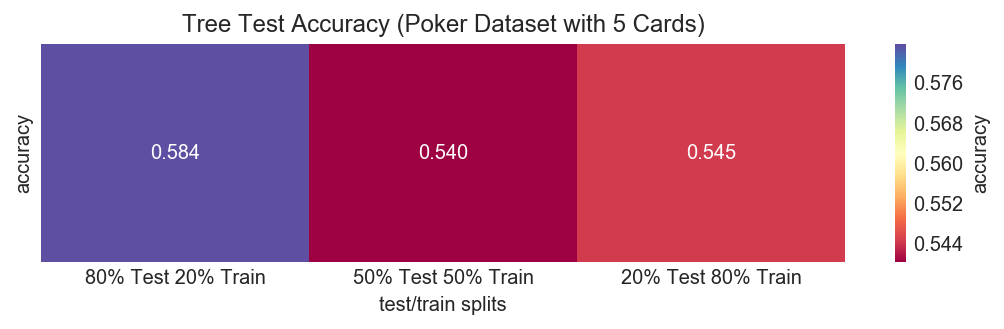

In [101]:
tree_Poker_5 = tree(X_train_val_Poker_1_Cards_5, Y_train_val_Poker_1,X_train_val_Poker_2_Cards_5, Y_train_val_Poker_2,\
            X_train_val_Poker_3_Cards_5, Y_train_val_Poker_3,X_test_Poker_1_Cards_5, Y_test_Poker_1,\
            X_test_Poker_2_Cards_5, Y_test_Poker_2, X_test_Poker_3_Cards_5, Y_test_Poker_3,\
            'Tree Training Accuracy (Poker Dataset with 5 Cards)', \
            'Tree Validation Accuracy (Poker Dataset with 5 Cards)',\
            'Tree Test Accuracy (Poker Dataset with 5 Cards)')

In [102]:
tree_overall_avg.append(np.mean(list(tree_Poker_5.values())))

temp = [] #hold split values
temp.append(tree_Poker_5['80/20 Split Train'])
temp.append(tree_Poker_5['80/20 Split Validation'])
temp.append(tree_Poker_5['80/20 Split Test'])
tree_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Poker_5['50/50 Split Train'])
temp.append(tree_Poker_5['50/50 Split Validation'])
temp.append(tree_Poker_5['50/50 Split Test'])
tree_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Poker_5['20/80 Split Train'])
temp.append(tree_Poker_5['20/80 Split Validation'])
temp.append(tree_Poker_5['20/80 Split Test'])
tree_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(tree_Poker_5['80/20 Split Test'])
temp.append(tree_Poker_5['50/50 Split Test'])
temp.append(tree_Poker_5['20/80 Split Test'])

tree_Poker_5_Average_Test = np.mean(np.array(temp))
tree_Poker_5_SD_Test = np.std(np.array(temp))
tree_Poker_5_Max_Test = np.max(np.array(temp))
tree_Poker_5_Min_Test = np.min(np.array(temp))

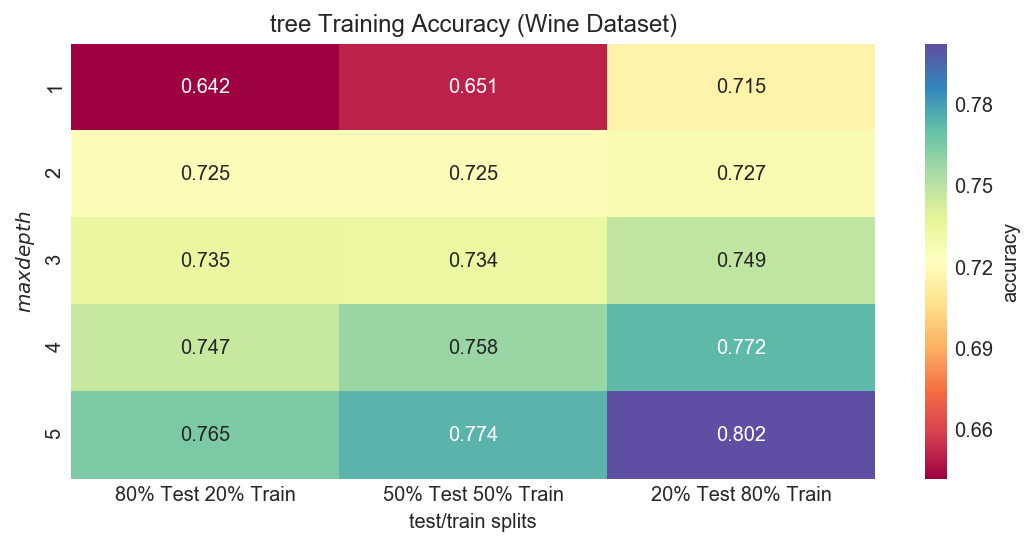

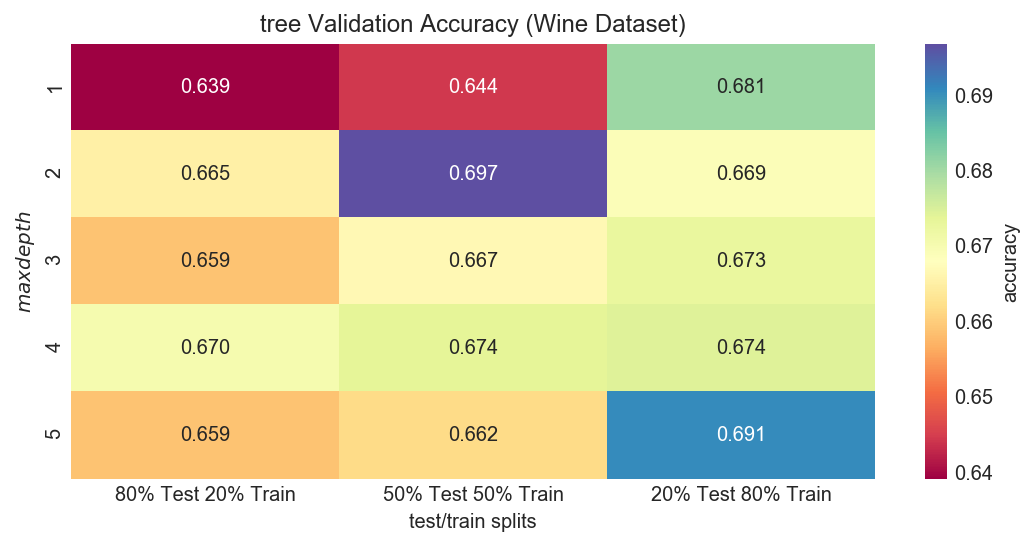

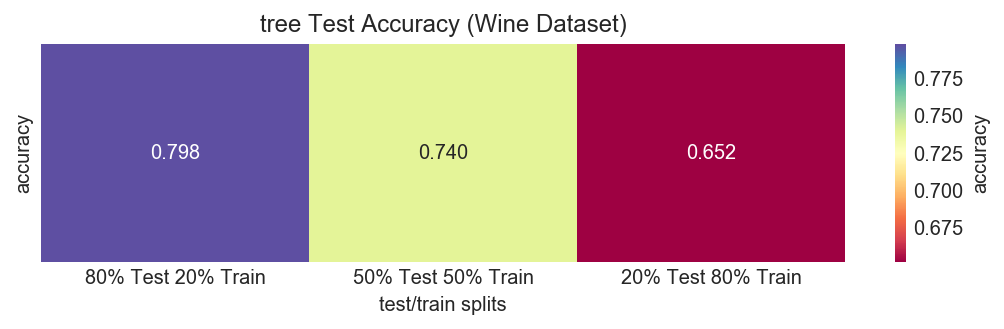

In [103]:
tree_Wine = tree(X_train_val_Wine_1, Y_train_val_Wine_1,X_train_val_Wine_2, Y_train_val_Wine_2,\
            X_train_val_Wine_3, Y_train_val_Wine_3,X_test_Wine_1, Y_test_Wine_1, \
            X_test_Wine_2, Y_test_Wine_2,X_test_Wine_3, Y_test_Wine_3,\
            'tree Training Accuracy (Wine Dataset)', \
            'tree Validation Accuracy (Wine Dataset)',\
            'tree Test Accuracy (Wine Dataset)')

In [104]:
tree_overall_avg.append(np.mean(list(tree_Wine.values())))

temp = [] #hold split values
temp.append(tree_Wine['80/20 Split Train'])
temp.append(tree_Wine['80/20 Split Validation'])
temp.append(tree_Wine['80/20 Split Test'])
tree_80_20_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Wine['50/50 Split Train'])
temp.append(tree_Wine['50/50 Split Validation'])
temp.append(tree_Wine['50/50 Split Test'])
tree_50_50_split_avg.append(np.mean(np.array(temp)))

temp = [] 
temp.append(tree_Wine['20/80 Split Train'])
temp.append(tree_Wine['20/80 Split Validation'])
temp.append(tree_Wine['20/80 Split Test'])
tree_20_80_split_avg.append(np.mean(np.array(temp)))

temp = []
temp.append(tree_Wine['80/20 Split Test'])
temp.append(tree_Wine['50/50 Split Test'])
temp.append(tree_Wine['20/80 Split Test'])

tree_Wine_Average_Test = np.mean(np.array(temp))
tree_Wine_SD_Test = np.std(np.array(temp))
tree_Wine_Max_Test = np.max(np.array(temp))
tree_Wine_Min_Test = np.min(np.array(temp))

### Overall Data Visualization in Graphs

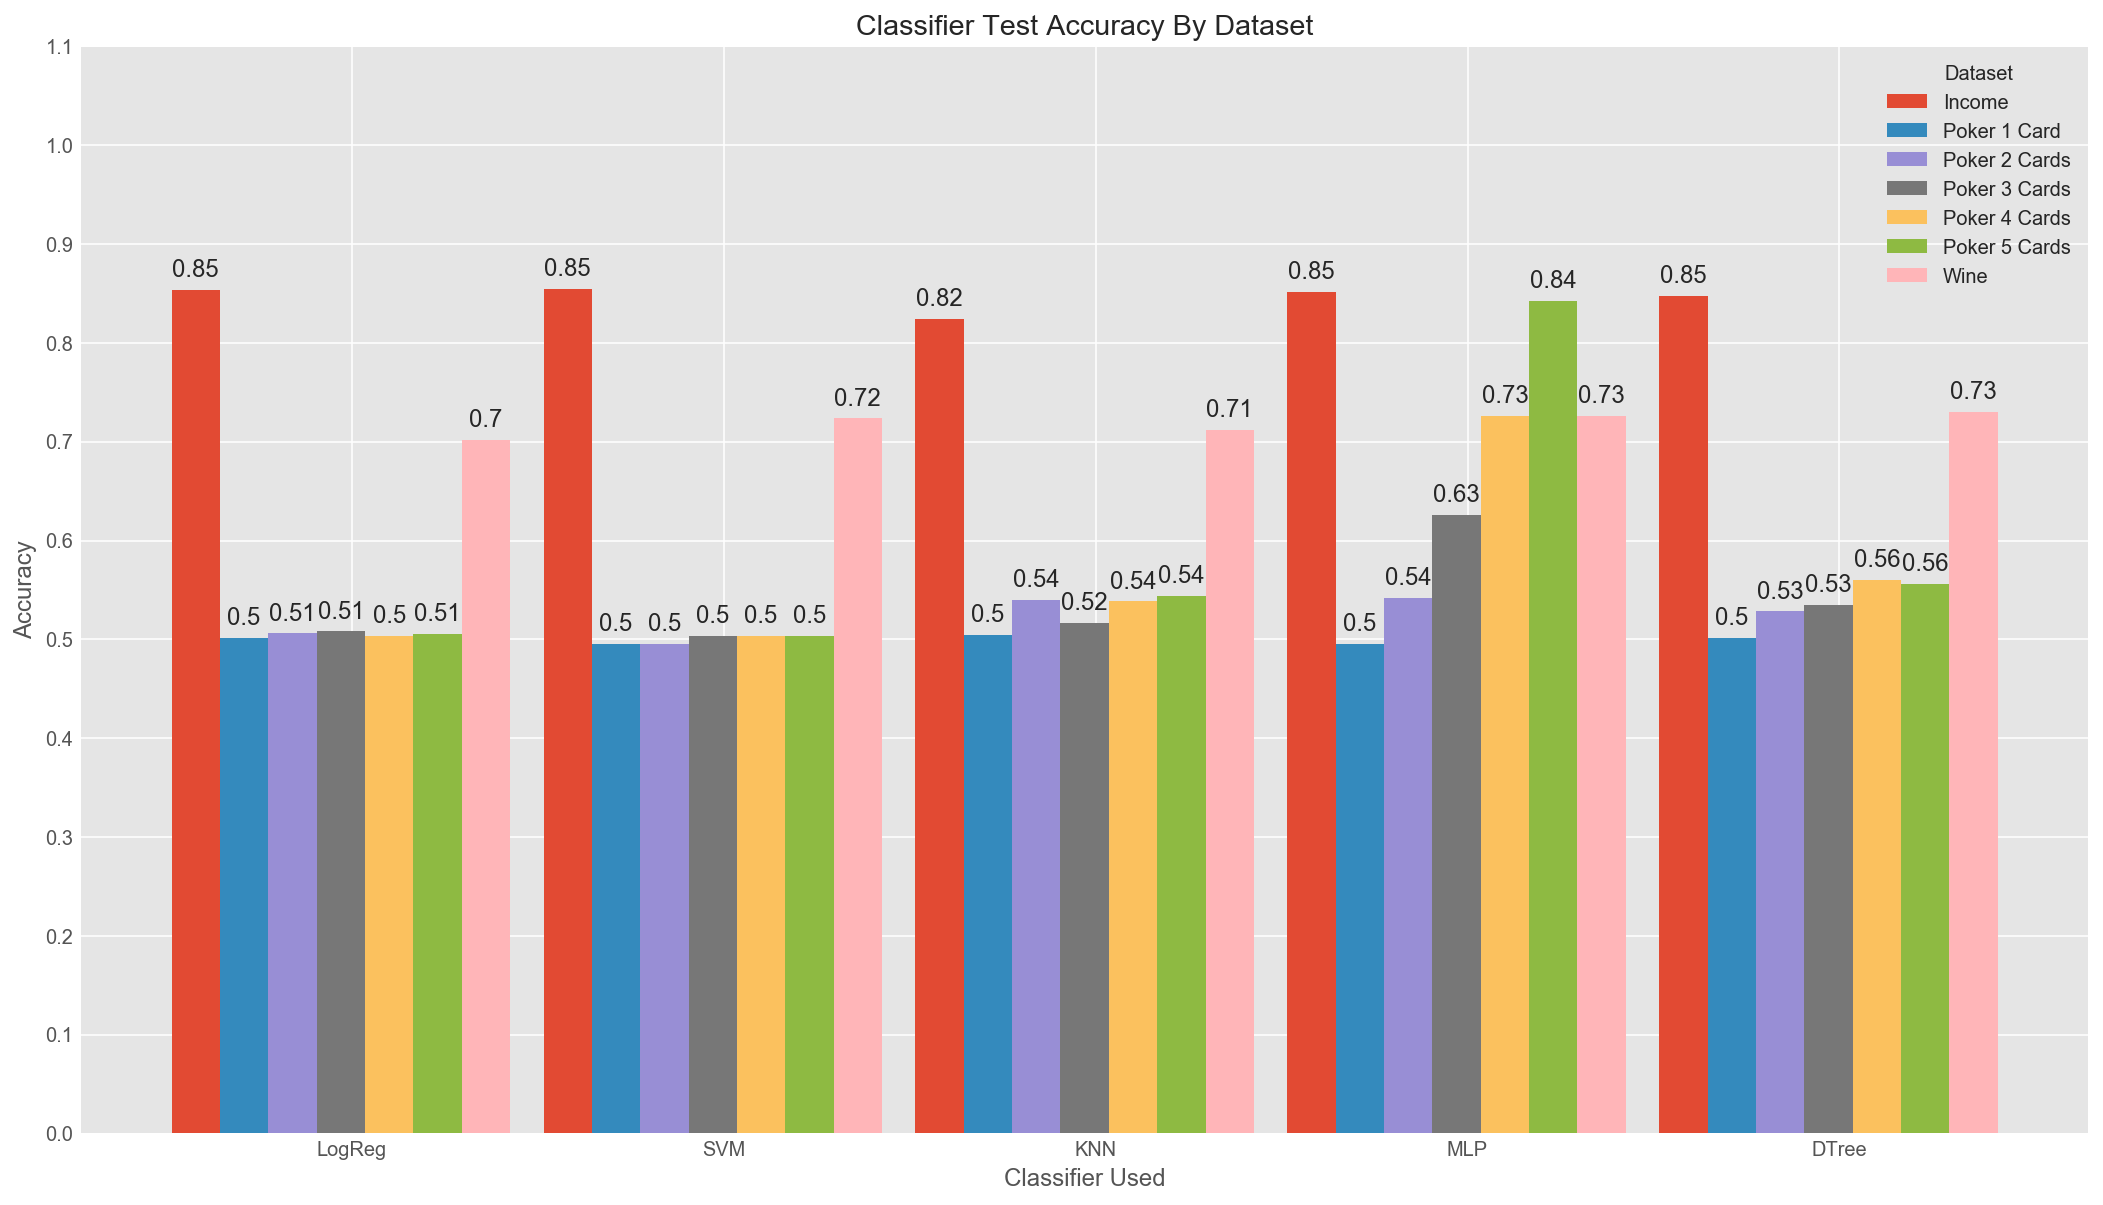

In [105]:
mpl.style.use('ggplot')
datasets_Income =     [logReg_Income_Average_Test,svm_Income_Average_Test, knn_Income_Average_Test,\
                      mlp_Income_Average_Test, tree_Income_Average_Test]
datasets_Poker_1 =    [logReg_Poker_1_Average_Test, svm_Poker_1_Average_Test, knn_Poker_1_Average_Test,\
                      mlp_Poker_1_Average_Test, tree_Poker_1_Average_Test]
datasets_Poker_2 =    [logReg_Poker_2_Average_Test, svm_Poker_2_Average_Test, knn_Poker_2_Average_Test,\
                      mlp_Poker_2_Average_Test, tree_Poker_2_Average_Test]
datasets_Poker_3 =    [logReg_Poker_3_Average_Test, svm_Poker_3_Average_Test, knn_Poker_3_Average_Test,\
                      mlp_Poker_3_Average_Test, tree_Poker_3_Average_Test]
datasets_Poker_4 =    [logReg_Poker_4_Average_Test, svm_Poker_4_Average_Test, knn_Poker_4_Average_Test,\
                      mlp_Poker_4_Average_Test, tree_Poker_4_Average_Test]
datasets_Poker_5 =    [logReg_Poker_5_Average_Test, svm_Poker_5_Average_Test, knn_Poker_5_Average_Test,\
                      mlp_Poker_5_Average_Test, tree_Poker_5_Average_Test]
datasets_Wine =       [logReg_Wine_Average_Test, svm_Wine_Average_Test, knn_Wine_Average_Test,\
                      mlp_Wine_Average_Test, tree_Wine_Average_Test]

fig, ax = plt.subplots(figsize=(18,10))

ind = np.arange(5)    # the x locations for the groups
width = 0.13    # the width of the bars

ax.set_title('Classifier Test Accuracy By Dataset')
ax.set_xlabel('Classifier Used')
ax.set_xticks(np.arange(7) + width / 0.31)
ax.set_xticklabels(['LogReg', 'SVM', 'KNN', 'MLP', 'DTree'])


p1 = ax.bar(np.arange(5),datasets_Income, width, bottom=0)
p2 = ax.bar(np.arange(5)+width,datasets_Poker_1, width, bottom=0)
p3 = ax.bar(np.arange(5)+width*2,datasets_Poker_2, width, bottom=0)
p4 = ax.bar(np.arange(5)+width*3,datasets_Poker_3, width, bottom=0)
p5 = ax.bar(np.arange(5)+width*4,datasets_Poker_4, width, bottom=0)
p6 = ax.bar(np.arange(5)+width*5,datasets_Poker_5, width, bottom=0)
p7 = ax.bar(np.arange(5)+width*6,datasets_Wine, width, bottom=0)

ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0]), ['Income', 'Poker 1 Card', 'Poker 2 Cards', 'Poker 3 Cards',\
            'Poker 4 Cards', 'Poker 5 Cards', 'Wine'], title="Dataset")

ax.set_ylabel('Accuracy')
ax.autoscale_view()
ax.set_ylim(0,1.1)
ax.set_yticks(np.linspace(0,1.1,num =12))
plt.rcParams.update({'font.size': 12})
#set labels on the bars
for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%.2g" % p.get_height(), xy=(x,h), xytext=(0,4), rotation=0, 
                   textcoords="offset points", ha="center", va="bottom")



plt.show()

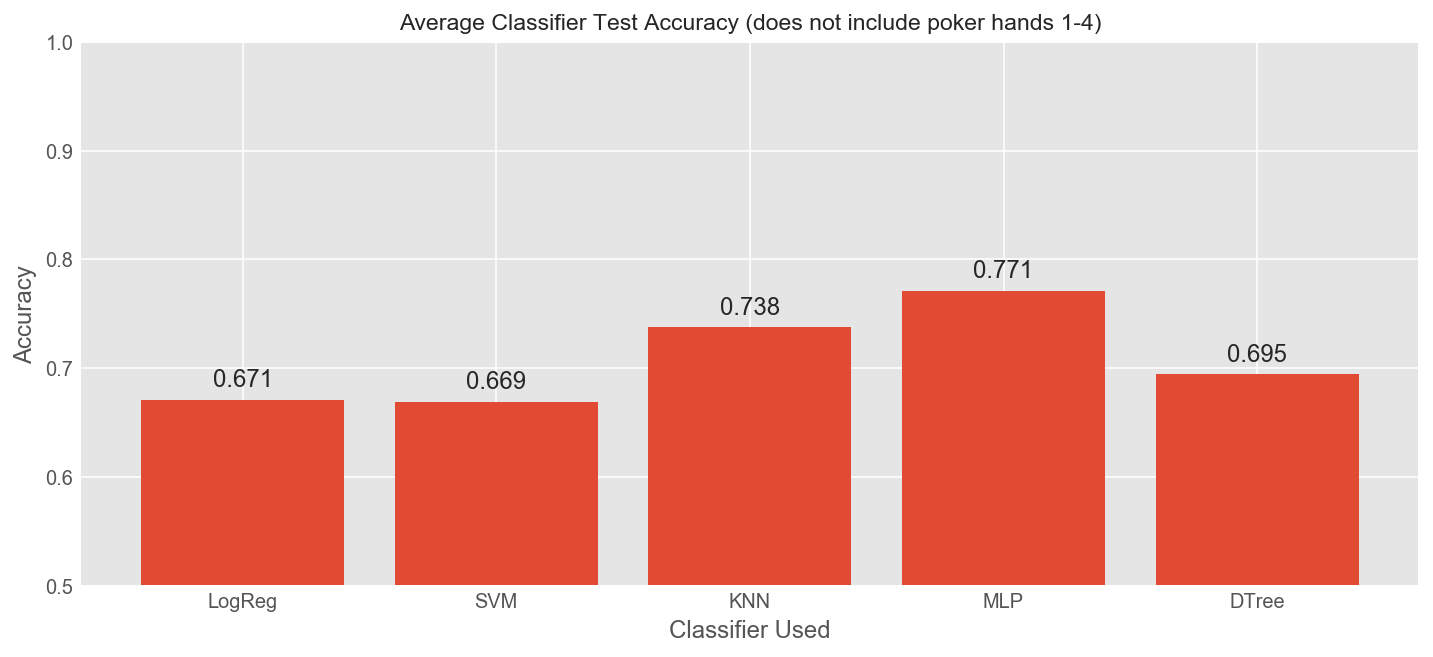

In [106]:
mpl.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,5))
plt.rcParams.update({'font.size': 8})

ax.set_title('Average Classifier Test Accuracy (does not include poker hands 1-4)')
ax.set_xlabel('Classifier Used')

ax.set_xticklabels(['','LogReg', 'SVM', 'KNN', 'MLP', 'DTree'], ha='center')

accuracies = [np.mean(logReg_overall_avg), np.mean(svm_overall_avg), np.mean(knn_overall_avg),\
              np.mean(mlp_overall_avg),np.mean(tree_overall_avg)]
plt.bar(np.arange(5), accuracies, align='center')

ax.set_ylabel('Accuracy')
ax.set_ylim(0.5,1.0)
ax.set_yticks(np.linspace(0.5,1.0,num =6))
plt.rcParams.update({'font.size': 12})
#set labels on the bars
for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%.3g" % p.get_height(), xy=(x,h), xytext=(0,4), rotation=0, 
                   textcoords="offset points", ha="center", va="bottom")



plt.show()

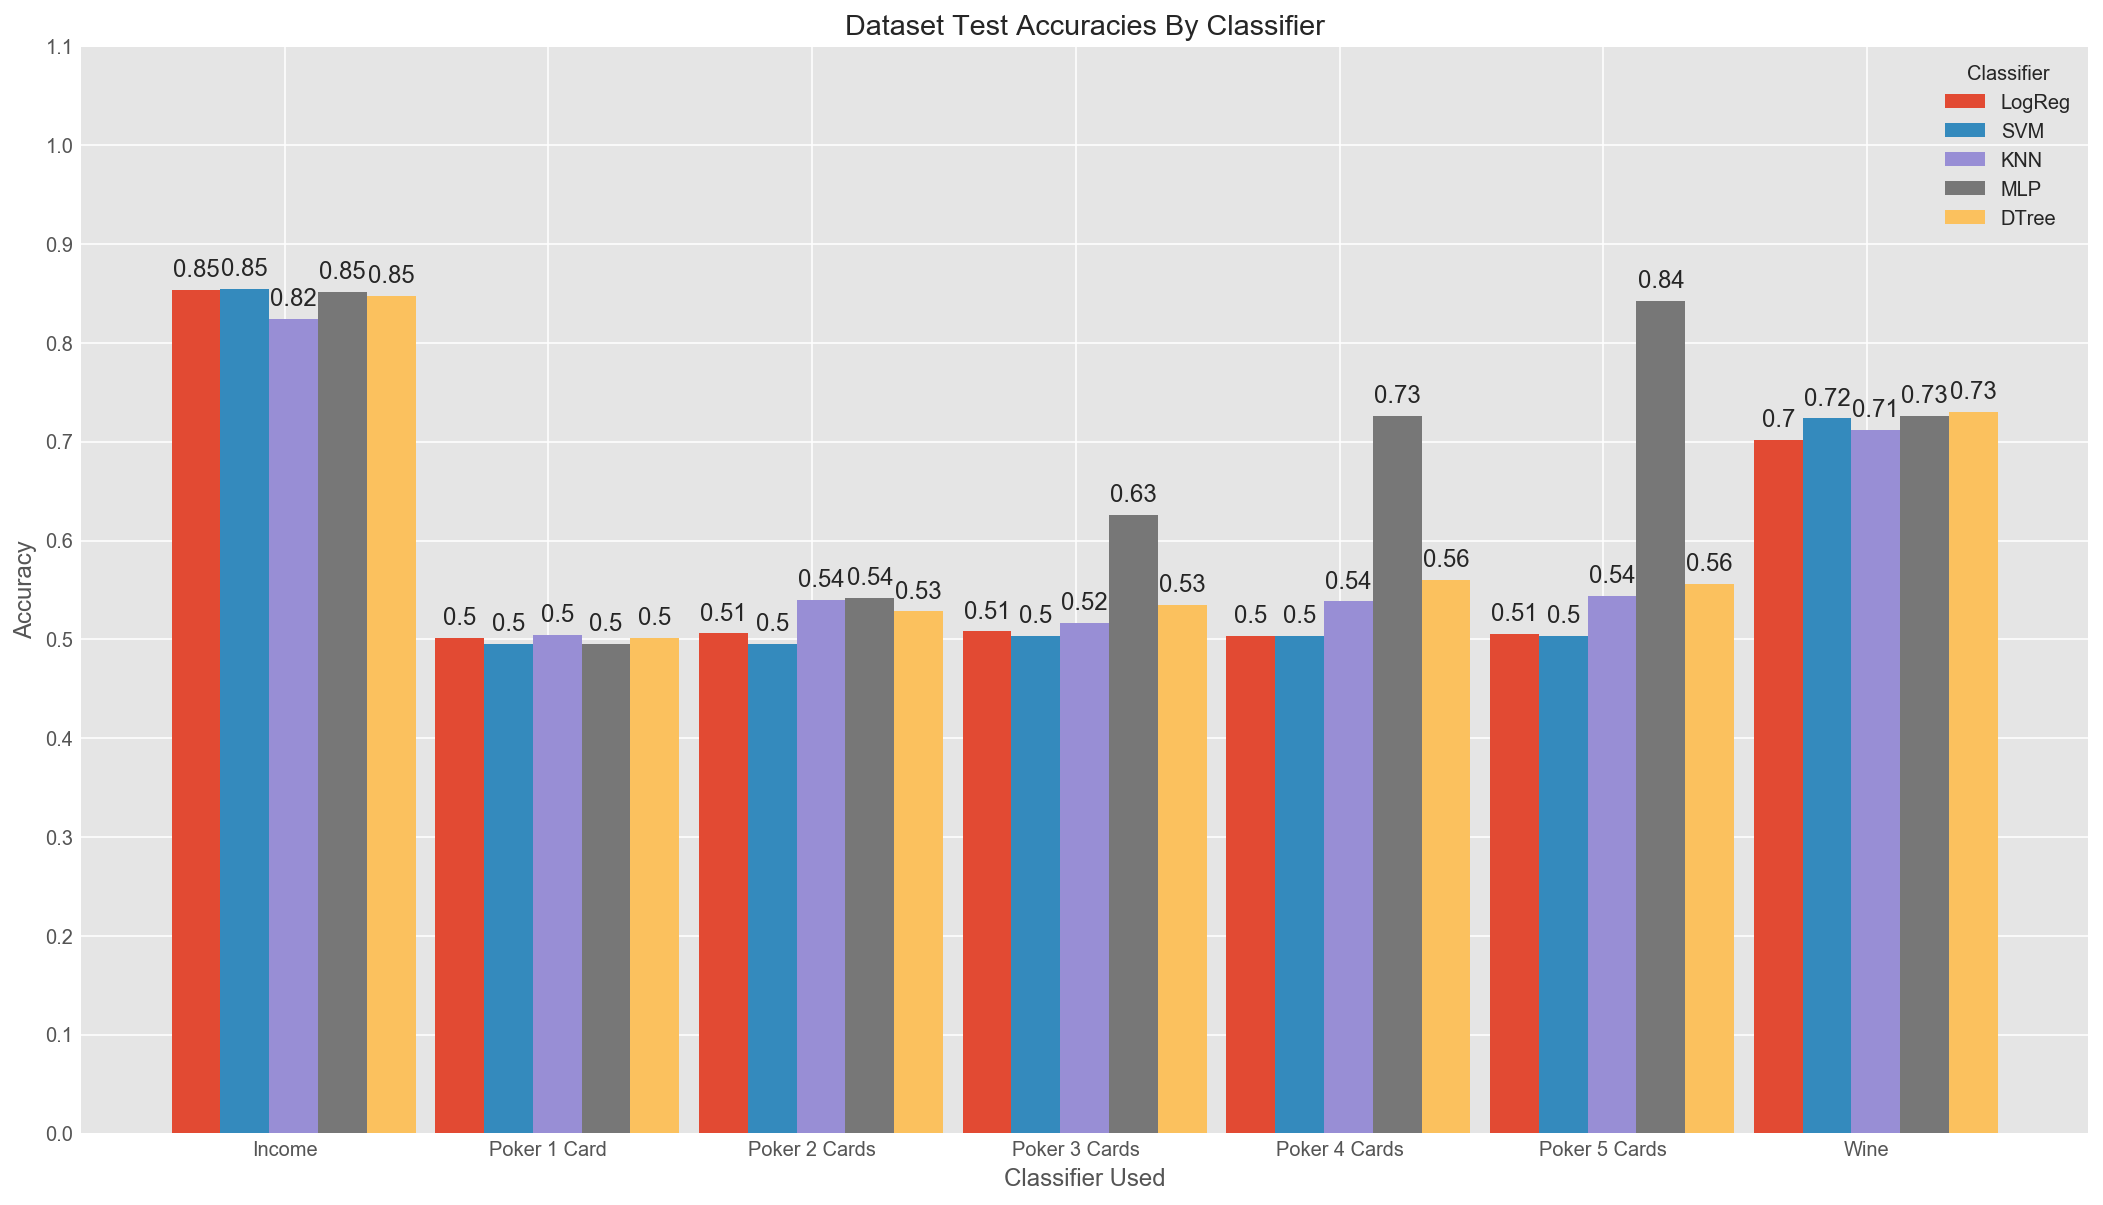

In [124]:
mpl.style.use('ggplot')
datasets_logReg = [logReg_Income_Average_Test, logReg_Poker_1_Average_Test, logReg_Poker_2_Average_Test, \
                  logReg_Poker_3_Average_Test, logReg_Poker_4_Average_Test, logReg_Poker_5_Average_Test,\
                  logReg_Wine_Average_Test]
datasets_svm =    [svm_Income_Average_Test, svm_Poker_1_Average_Test, svm_Poker_2_Average_Test, \
                  svm_Poker_3_Average_Test, svm_Poker_4_Average_Test, svm_Poker_5_Average_Test,\
                  svm_Wine_Average_Test]
datasets_knn =    [knn_Income_Average_Test, knn_Poker_1_Average_Test, knn_Poker_2_Average_Test, \
                  knn_Poker_3_Average_Test, knn_Poker_4_Average_Test, knn_Poker_5_Average_Test,\
                  knn_Wine_Average_Test]
datasets_mlp =    [mlp_Income_Average_Test, mlp_Poker_1_Average_Test, mlp_Poker_2_Average_Test, \
                  mlp_Poker_3_Average_Test, mlp_Poker_4_Average_Test, mlp_Poker_5_Average_Test,\
                  mlp_Wine_Average_Test]
datasets_tree =  [tree_Income_Average_Test, tree_Poker_1_Average_Test, tree_Poker_2_Average_Test, \
                  tree_Poker_3_Average_Test, tree_Poker_4_Average_Test, tree_Poker_5_Average_Test,\
                  tree_Wine_Average_Test]
fig, ax = plt.subplots(figsize=(18,10))

ind = np.arange(5)    # the x locations for the groups
width = 0.185     # the width of the bars

ax.set_title('Dataset Test Accuracies By Classifier')
ax.set_xlabel('Classifier Used')
ax.set_xticks(np.arange(7) + width / 0.55)
ax.set_xticklabels(['Income', 'Poker 1 Card', 'Poker 2 Cards', 'Poker 3 Cards',\
            'Poker 4 Cards', 'Poker 5 Cards', 'Wine'])

p1 = ax.bar(np.arange(7),datasets_logReg, width, bottom=0)
p2 = ax.bar(np.arange(7)+width,datasets_svm, width, bottom=0)
p3 = ax.bar(np.arange(7)+width*2,datasets_knn, width, bottom=0)
p4 = ax.bar(np.arange(7)+width*3,datasets_mlp, width, bottom=0)
p5 = ax.bar(np.arange(7)+width*4,datasets_tree, width, bottom=0)

ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0],), ('LogReg', 'SVM', 'KNN', 'MLP', 'DTree',), title="Classifier")
# ax.yaxis.set_units(inch)
ax.set_ylabel('Accuracy')
ax.autoscale_view()
ax.set_ylim(0,1.1)
ax.set_yticks(np.linspace(0,1.1,num =12))
plt.rcParams.update({'font.size': 12})
#set labels on the bars
for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%.2g" % p.get_height(), xy=(x,h), xytext=(0,4), rotation=0, 
                   textcoords="offset points", ha="center", va="bottom")


plt.show()


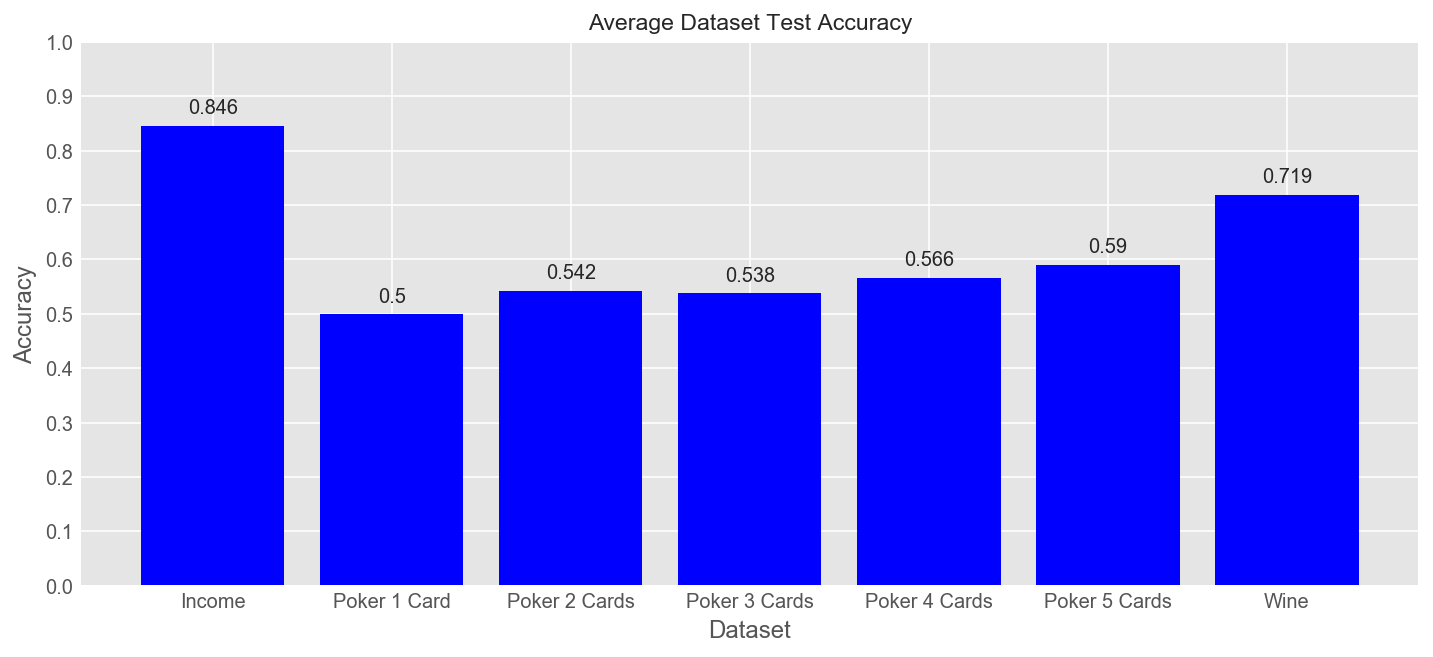

In [108]:
mpl.style.use('ggplot')
income_overall_acc = np.mean([logReg_Income['80/20 Split Test'],logReg_Income['50/50 Split Test'],\
                             logReg_Income['20/80 Split Test'],svm_Income['80/20 Split Test'],\
                             svm_Income['50/50 Split Test'], svm_Income['20/80 Split Test'],\
                             knn_Income['80/20 Split Test'],knn_Income['50/50 Split Test'],\
                             knn_Income['20/80 Split Test'],mlp_Income['80/20 Split Test'],\
                             mlp_Income['50/50 Split Test'],mlp_Income['20/80 Split Test'],\
                             tree_Income['80/20 Split Test'],tree_Income['50/50 Split Test'],\
                             tree_Income['20/80 Split Test']])
poker_1_overall_acc = np.mean([logReg_Poker_1['80/20 Split Test'],logReg_Poker_1['50/50 Split Test'],\
                             logReg_Poker_1['20/80 Split Test'],svm_Poker_1['80/20 Split Test'],\
                             svm_Poker_1['50/50 Split Test'], svm_Poker_1['20/80 Split Test'],\
                             knn_Poker_1['80/20 Split Test'],knn_Poker_1['50/50 Split Test'],\
                             knn_Poker_1['20/80 Split Test'],mlp_Poker_1['80/20 Split Test'],\
                             mlp_Poker_1['50/50 Split Test'],mlp_Poker_1['20/80 Split Test'],\
                             tree_Poker_1['80/20 Split Test'],tree_Poker_1['50/50 Split Test'],\
                             tree_Poker_1['20/80 Split Test']])
poker_2_overall_acc = np.mean([logReg_Poker_2['80/20 Split Test'],logReg_Poker_2['50/50 Split Test'],\
                             logReg_Poker_2['20/80 Split Test'],svm_Poker_2['80/20 Split Test'],\
                             svm_Poker_2['50/50 Split Test'], svm_Poker_2['20/80 Split Test'],\
                             knn_Poker_2['80/20 Split Test'],knn_Poker_2['50/50 Split Test'],\
                             knn_Poker_2['20/80 Split Test'],mlp_Income['80/20 Split Test'],\
                             mlp_Poker_2['50/50 Split Test'],mlp_Poker_2['20/80 Split Test'],\
                             tree_Poker_2['80/20 Split Test'],tree_Poker_2['50/50 Split Test'],\
                             tree_Poker_2['20/80 Split Test']])
poker_3_overall_acc = np.mean([logReg_Poker_3['80/20 Split Test'],logReg_Poker_3['50/50 Split Test'],\
                             logReg_Poker_3['20/80 Split Test'],svm_Poker_3['80/20 Split Test'],\
                             svm_Poker_3['50/50 Split Test'], svm_Poker_3['20/80 Split Test'],\
                             knn_Poker_3['80/20 Split Test'],knn_Poker_3['50/50 Split Test'],\
                             knn_Poker_3['20/80 Split Test'],mlp_Poker_3['80/20 Split Test'],\
                             mlp_Poker_3['50/50 Split Test'],mlp_Poker_3['20/80 Split Test'],\
                             tree_Poker_3['80/20 Split Test'],tree_Poker_3['50/50 Split Test'],\
                             tree_Poker_3['20/80 Split Test']])
poker_4_overall_acc = np.mean([logReg_Poker_4['80/20 Split Test'],logReg_Poker_4['50/50 Split Test'],\
                             logReg_Poker_4['20/80 Split Test'],svm_Poker_4['80/20 Split Test'],\
                             svm_Poker_4['50/50 Split Test'], svm_Poker_4['20/80 Split Test'],\
                             knn_Poker_4['80/20 Split Test'],knn_Poker_4['50/50 Split Test'],\
                             knn_Poker_4['20/80 Split Test'],mlp_Poker_4['80/20 Split Test'],\
                             mlp_Poker_4['50/50 Split Test'],mlp_Poker_4['20/80 Split Test'],\
                             tree_Poker_4['80/20 Split Test'],tree_Poker_4['50/50 Split Test'],\
                             tree_Poker_4['20/80 Split Test']])
poker_5_overall_acc = np.mean([logReg_Poker_5['80/20 Split Test'],logReg_Poker_5['50/50 Split Test'],\
                             logReg_Poker_5['20/80 Split Test'],svm_Poker_5['80/20 Split Test'],\
                             svm_Poker_5['50/50 Split Test'], svm_Poker_5['20/80 Split Test'],\
                             knn_Poker_5['80/20 Split Test'],knn_Poker_5['50/50 Split Test'],\
                             knn_Poker_5['20/80 Split Test'],mlp_Poker_5['80/20 Split Test'],\
                             mlp_Poker_5['50/50 Split Test'],mlp_Poker_5['20/80 Split Test'],\
                             tree_Poker_5['80/20 Split Test'],tree_Poker_5['50/50 Split Test'],\
                             tree_Poker_5['20/80 Split Test']])
wine_overall_acc = np.mean([logReg_Wine['80/20 Split Test'],logReg_Wine['50/50 Split Test'],\
                             logReg_Wine['20/80 Split Test'],svm_Wine['80/20 Split Test'],\
                             svm_Wine['50/50 Split Test'], svm_Wine['20/80 Split Test'],\
                             knn_Wine['80/20 Split Test'],knn_Wine['50/50 Split Test'],\
                             knn_Wine['20/80 Split Test'],mlp_Wine['80/20 Split Test'],\
                             mlp_Wine['50/50 Split Test'],mlp_Wine['20/80 Split Test'],\
                             tree_Wine['80/20 Split Test'],tree_Wine['50/50 Split Test'],\
                             tree_Wine['20/80 Split Test']])




fig, ax = plt.subplots(figsize=(12,5))
plt.rcParams.update({'font.size': 8})

ax.set_title('Average Dataset Test Accuracy')
ax.set_xlabel('Dataset')

ax.set_xticklabels(['','Income', 'Poker 1 Card', 'Poker 2 Cards', 'Poker 3 Cards',\
            'Poker 4 Cards', 'Poker 5 Cards', 'Wine'], ha='center')

accuracies = [income_overall_acc, poker_1_overall_acc, poker_2_overall_acc, poker_3_overall_acc, \
             poker_4_overall_acc, poker_5_overall_acc, wine_overall_acc]
plt.bar(np.arange(7), accuracies, align='center', color="blue")

ax.set_ylabel('Accuracy')
ax.set_ylim(0,1.0)
ax.set_yticks(np.linspace(0,1.0,num =11))
plt.rcParams.update({'font.size': 10})
#set labels on the bars
for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%.3g" % p.get_height(), xy=(x,h), xytext=(0,4), rotation=0, 
                   textcoords="offset points", ha="center", va="bottom")


plt.show()

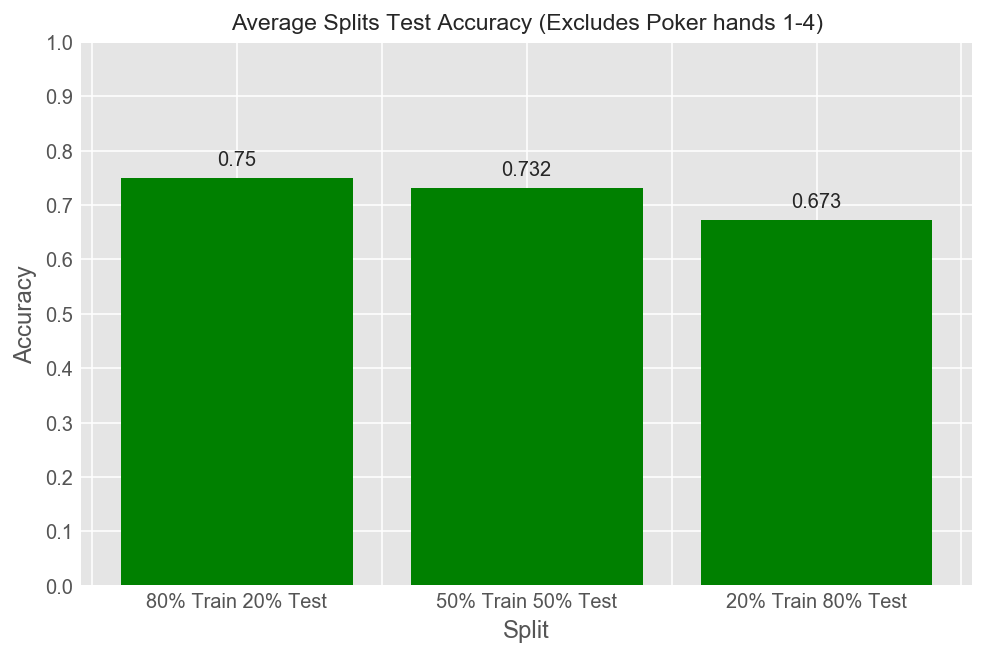

In [132]:
mpl.style.use('ggplot')
overall_test_acc_80_20 = np.mean([logReg_Income['80/20 Split Test'],svm_Income['80/20 Split Test'],\
                                  knn_Income['80/20 Split Test'],mlp_Income['80/20 Split Test'],\
                                  tree_Income['80/20 Split Test'],logReg_Poker_5['80/20 Split Test'],\
                                  svm_Poker_5['80/20 Split Test'], knn_Poker_5['80/20 Split Test'],\
                                  mlp_Poker_5['80/20 Split Test'], tree_Poker_5['80/20 Split Test'],\
                                  logReg_Wine['80/20 Split Test'], svm_Wine['80/20 Split Test'],\
                                  knn_Wine['80/20 Split Test'], mlp_Wine['80/20 Split Test'],\
                                  tree_Wine['80/20 Split Test']])
overall_test_acc_50_50 = np.mean([logReg_Income['50/50 Split Test'],svm_Income['50/50 Split Test'],\
                                  knn_Income['50/50 Split Test'],mlp_Income['50/50 Split Test'],\
                                  tree_Income['50/50 Split Test'],logReg_Poker_5['50/50 Split Test'],\
                                  svm_Poker_5['50/50 Split Test'], knn_Poker_5['50/50 Split Test'],\
                                  mlp_Poker_5['50/50 Split Test'], tree_Poker_5['50/50 Split Test'],\
                                  logReg_Wine['50/50 Split Test'], svm_Wine['50/50 Split Test'],\
                                  knn_Wine['50/50 Split Test'], mlp_Wine['50/50 Split Test'],\
                                  tree_Wine['50/50 Split Test']])
overall_test_acc_20_80 = np.mean([logReg_Income['20/80 Split Test'],svm_Income['20/80 Split Test'],\
                                  knn_Income['20/80 Split Test'],mlp_Income['20/80 Split Test'],\
                                  tree_Income['20/80 Split Test'],logReg_Poker_5['20/80 Split Test'],\
                                  svm_Poker_5['20/80 Split Test'], knn_Poker_5['20/80 Split Test'],\
                                  mlp_Poker_5['20/80 Split Test'], tree_Poker_5['20/80 Split Test'],\
                                  logReg_Wine['20/80 Split Test'], svm_Wine['20/80 Split Test'],\
                                  knn_Wine['20/80 Split Test'], mlp_Wine['20/80 Split Test'],\
                                  tree_Wine['20/80 Split Test']])

fig, ax = plt.subplots(figsize=(8,5))
plt.rcParams.update({'font.size': 8})

ax.set_title('Average Splits Test Accuracy (Excludes Poker hands 1-4)')
ax.set_xlabel('Split')
ax.set_xticklabels(['', '', '80% Train 20% Test', '', '50% Train 50% Test', '', '20% Train 80% Test'], ha='center')

accuracies = [overall_test_acc_80_20, overall_test_acc_50_50, overall_test_acc_20_80]
plt.bar(np.arange(3), accuracies, align='center', color="green")

ax.set_ylabel('Accuracy')
ax.set_ylim(0,1.0)
ax.set_yticks(np.linspace(0,1.0,num =11))
plt.rcParams.update({'font.size': 10})


#set labels on the bars
for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%.3g" % p.get_height(), xy=(x,h), xytext=(0,4), rotation=0, 
                   textcoords="offset points", ha="center", va="bottom")

plt.show()